# Expore data

## Import & definitions

In [1]:
import os
import sys
from pathlib import Path
import re
import random
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json
import joblib
# Third Party
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
# from helpers.ocean_helpers import save_list
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import L1L2
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

# definitions
PAST_HISTORY = int(60 / 5) * 6 # 4 hours / 72*5min = 6 hours used to predict next values in future
FUTURE_TARGET = 12 + 3 # number of 5 min to predict  : 15
STEP = 1
BATCH_SIZE = 32
TRAIN_SPLIT_RATIO = 0.8 #0.9891 # 1-(60/5*24)/50977
MODE_TRAIN_AE = False # False
MODE_AUTO_SELECT = 2  #0 # 0: False, 1: True, 2: from disk

MODE_TRAIN_PREDICTOR = False
MODE_TRAIN_LSTM = False

# paths
path_data = "data"
path_save_df_feat = os.path.join(path_data, "df_features_05m.csv")

path_save_pred_vals = "data/pred_vals.csv"
path_save_auto_select = "data/list_auto_select.csv"

path_mdl_autoencoder =  os.path.join(path_data, "mdl_autoencoder")
path_mdl_encoder  =  os.path.join(path_data, "mdl_encoder")
path_mdl_predict_lstm  =  os.path.join(path_data, "mdl_predict_lstm")
path_mdl_predict_autoenc_lstm  =  os.path.join(
    path_data, "mdl_predict_autoenc_lstm")

path_scaler = os.path.join(path_data, "scaler.bin")
path_scaler_y = os.path.join(path_data, "scaler_y.bin")
path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")

In [2]:
PAST_HISTORY

72

In [3]:
print(60/5*24*2)
1-(60/5*24*2)/52981

576.0


0.9891281780260848

In [4]:
# helpers: save/load list
def save_list(list_: list, file_name: str):
    """Save a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    p.write_text(str(list_))
    
def load_list(file_name: str) -> list:
    """Load from a file shaped: [1.2, 3.4, 5.6, ..]"""
    p = Path(file_name)
    s = p.read_text()
    list_ = eval(s)
    return list_

In [5]:
def plot_train_history(history, title, saveFolder=None):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    fig = plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    ax = fig.gca()
    ax.set_xlabel("epoch[-]")
    if saveFolder is not None:
        title_clean = re.sub('[^-a-zA-Z0-9 \.]', ' ', title)
        plt.savefig(os.path.join(saveFolder, f"output_{title_clean}.jpg")) 
    plt.show()


def naming_plot(n_unit_enc, encoding_dim, dropout_autoenc):
    return f"TS {TRAIN_SPLIT_RATIO} - units {n_unit_enc} - enc_dim {encoding_dim} - drop {dropout_autoenc}"

## Load raw features

In [6]:
# load
df_feat_raw = pd.read_csv(path_save_df_feat)
df_feat_raw

/var/folders/m4/ng3wlwj109df2b8j9f4y4m7m0000gn/T/ipykernel_27109/3998402900.py:2: DtypeWarning: Columns (118,119,120,121,122,123,124,134) have mixed types. Specify dtype option on import or set low_memory=False.
  df_feat_raw = pd.read_csv(path_save_df_feat)


Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
65657  1692228300000   1810.64   1810.64  1809.20    1809.58    208.5162   
65658  1692228600000   1809.58   1811.00  1809.41    1810.20    503.7164   
65659  1692228900000   1810.20   1810.21  1806.02    1808.61   1317.2484   
65660  1692229200000   1808.60   1809.56  1807.16    1807.99    384.6119   
65661  1692229500000   1807.99   1809.40  1807.81    1809.40    195.7627   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1753.872341       1753.333968   
1      2023-01-01 00:05:00       1753.872341       1753.333968   
2      2023-01-01 00:10:00       1753.872341       1753.333968   
3      2023-01-01 00:15:00       1753.872341       1753.333968   
4      2023-01-01 00:20:00       1753.872341       1753.333968   
...                    ...               ...               ...   
65657  2023-08-16 23:25:00       1807.440000       1813.695000   
65658  2023-08-16 23:30:00       1807.440000       1813.695000   
65659  2023-08-16 23:35:00       1808.677500       1813.695000   
65660  2023-08-16 23:40:00       1808.677500       1813.695000   
65661  2023-08-16 23:45:00       1808.677500       1813.695000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0                 NaN  ...   NaN         NaN            NaN           NaN   
1                 NaN  ...   NaN         NaN            NaN           NaN   
2                 NaN  ...   NaN         NaN            NaN           NaN   
3                 NaN  ...   NaN         NaN            NaN           NaN   
4                 NaN  ...   NaN         NaN            NaN           NaN   
...               ...  ...   ...         ...            ...           ...   
65657        1809.495  ...   NaN         NaN            NaN           NaN   
65658        1810.720  ...   NaN         NaN            NaN           NaN   
65659        1810.605  ...   NaN         NaN            NaN           NaN   
65660        1810.605  ...   NaN         NaN            NaN           NaN   
65661        1810.605  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   NaN         0.0               NaN         0.0      0.0   
1                   NaN         0.0               NaN         0.0      0.0   
2                   NaN         0.0               NaN         0.0      0.0   
3                   NaN         0.0               NaN         0.0      0.0   
4                   NaN         0.0               NaN         0.0      0.0   
...                 ...         ...               ...         ...      ...   
65657               NaN         0.0               NaN         0.0      0.0   
65658               NaN         0.0               NaN         0.0      0.0   
65659               NaN         0.0               NaN         0.0      0.0   
65660               NaN         0.0               NaN         0.0      0.0   
65661               NaN         0.0               NaN         0.0      0.0   

       date  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
65657   NaN  
65658   NaN  
65659   NaN  
65660   NaN  
65661   NaN  

[65662 rows x 135 columns]

### drop nan

In [7]:
def get_missing(df):
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    nb_missing = nb_missing[nb_missing.values > 0]
    print("missing data : ")
    print(nb_missing)
    print("")
    print("on {} samples".format(df.shape[0]))
    return nb_missing

nb_missing = get_missing(df_feat_raw)

missing data : 
vwap_z_score_BTC            1
vwap_z_score_ETH            1
ichi_tenkan_BTC             8
ichi_tenkan_ETH             8
min_low_h_BTC              13
rsi_h_BTC                  13
max_high_h_ETH             13
min_low_h_ETH              13
rsi_h_ETH                  13
max_high_h_BTC             13
chop_h_BTC                 14
chop_h_ETH                 14
ichi_cloud_a_ETH           25
ichi_kijun_ETH             25
ichi_kijun_BTC             25
ichi_cloud_a_BTC           25
ichi_tenkan_day_BTC       215
ichi_tenkan_day_ETH       215
dxy                       264
rsi_d_ETH                 335
min_low_d_BTC             335
rsi_d_BTC                 335
max_high_d_ETH            335
min_low_d_ETH             335
max_high_d_BTC            335
chop_d_ETH                335
chop_d_BTC                335
ichi_kijun_day_ETH        623
ichi_cloud_a_day_ETH      623
ichi_kijun_day_BTC        623
ichi_cloud_a_day_BTC      623
fvx                       732
spx                     

#### Cheat Backward Filling

In [8]:
df_feat = df_feat_raw.copy()

In [9]:
df_feat = df_feat.bfill(axis ='rows')

In [10]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
65657  1692228300000   1810.64   1810.64  1809.20    1809.58    208.5162   
65658  1692228600000   1809.58   1811.00  1809.41    1810.20    503.7164   
65659  1692228900000   1810.20   1810.21  1806.02    1808.61   1317.2484   
65660  1692229200000   1808.60   1809.56  1807.16    1807.99    384.6119   
65661  1692229500000   1807.99   1809.40  1807.81    1809.40    195.7627   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1753.872341       1753.333968   
1      2023-01-01 00:05:00       1753.872341       1753.333968   
2      2023-01-01 00:10:00       1753.872341       1753.333968   
3      2023-01-01 00:15:00       1753.872341       1753.333968   
4      2023-01-01 00:20:00       1753.872341       1753.333968   
...                    ...               ...               ...   
65657  2023-08-16 23:25:00       1807.440000       1813.695000   
65658  2023-08-16 23:30:00       1807.440000       1813.695000   
65659  2023-08-16 23:35:00       1808.677500       1813.695000   
65660  2023-08-16 23:40:00       1808.677500       1813.695000   
65661  2023-08-16 23:45:00       1808.677500       1813.695000   

       ichi_kijun_ETH  ...  keep  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...   1.0         0.0            0.0           0.0   
1            1194.710  ...   1.0         0.0            0.0           0.0   
2            1194.710  ...   1.0         0.0            0.0           0.0   
3            1194.710  ...   1.0         0.0            0.0           0.0   
4            1194.710  ...   1.0         0.0            0.0           0.0   
...               ...  ...   ...         ...            ...           ...   
65657        1809.495  ...   NaN         NaN            NaN           NaN   
65658        1810.720  ...   NaN         NaN            NaN           NaN   
65659        1810.605  ...   NaN         NaN            NaN           NaN   
65660        1810.605  ...   NaN         NaN            NaN           NaN   
65661        1810.605  ...   NaN         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
65657               NaN         0.0               NaN         0.0      0.0   
65658               NaN         0.0               NaN         0.0      0.0   
65659               NaN         0.0               NaN         0.0      0.0   
65660               NaN         0.0               NaN         0.0      0.0   
65661               NaN         0.0               NaN         0.0      0.0   

                      date  
0      2023-01-02 05:00:00  
1      2023-01-02 05:00:00  
2      2023-01-02 05:00:00  
3      2023-01-02 05:00:00  
4      2023-01-02 05:00:00  
...                    ...  
65657                  NaN  
65658                  NaN  
65659                  NaN  
65660                  NaN  
65661                  NaN  

[65662 rows x 135 columns]

In [11]:
nb_missing = get_missing(df_feat)

missing data : 
Consensus_num       1569
delta_event_real    1569
delta_event_pred    1569
Previous_num        1569
Actual_num          1569
Event               1569
Date                1569
Previous            1569
Consensus           1569
Actual              1569
Country             1569
Time (ET)           1569
keep                1569
date                1569
dtype: int64

on 65662 samples


In [12]:
#print(df_feat.shape)
#df_feat = df_feat.dropna(subset=["Consensus_num"]).copy()
#df_feat.reset_index(inplace=True)
#df_feat.shape

## Features Selection

### Proportional to the Price

In [13]:
list_col = df_feat.columns.to_list()
list_col

['Time',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'fear_greed',
 'fear_greed_class',
 'fvx',
 'spx',
 'dxy',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH',
 'hour',
 'hour_cos',
 'hour_sin',
 'weekday',
 'weekday_cos',
 'weekday_sin',
 'day',
 'days_in_month',
 'day_ratio',
 'da

In [14]:
list_col_ETH = [col for col in list_col if re.search("_ETH", col) is not None]
list_col_ETH

['Open_ETH',
 'High_ETH',
 'Low_ETH',
 'Close_ETH',
 'Volume_ETH',
 'date_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'rsi_h_ETH',
 'rsi_d_ETH',
 'rsi_w_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'atr_h_ETH',
 'chop_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'atr_d_ETH',
 'chop_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'atr_w_ETH',
 'chop_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'vwap_z_score_ETH',
 'nupl_ETH',
 'supply_ETH',
 'act_addr_ETH',
 'market_dom_ETH']

In [15]:
df_feat[list_col_ETH]

Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0       1196.13   1196.32  1195.65    1196.32    334.5592   
1       1196.31   1196.69  1194.90    1195.38    682.3876   
2       1195.38   1195.81  1194.55    1194.55    228.9387   
3       1194.55   1195.98  1194.31    1195.98    601.8903   
4       1195.98   1196.37  1195.97    1196.06    144.8048   
...         ...       ...      ...        ...         ...   
65657   1810.64   1810.64  1809.20    1809.58    208.5162   
65658   1809.58   1811.00  1809.41    1810.20    503.7164   
65659   1810.20   1810.21  1806.02    1808.61   1317.2484   
65660   1808.60   1809.56  1807.16    1807.99    384.6119   
65661   1807.99   1809.40  1807.81    1809.40    195.7627   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1753.872341       1753.333968   
1      2023-01-01 00:05:00       1753.872341       1753.333968   
2      2023-01-01 00:10:00       1753.872341       1753.333968   
3      2023-01-01 00:15:00       1753.872341       1753.333968   
4      2023-01-01 00:20:00       1753.872341       1753.333968   
...                    ...               ...               ...   
65657  2023-08-16 23:25:00       1807.440000       1813.695000   
65658  2023-08-16 23:30:00       1807.440000       1813.695000   
65659  2023-08-16 23:35:00       1808.677500       1813.695000   
65660  2023-08-16 23:40:00       1808.677500       1813.695000   
65661  2023-08-16 23:45:00       1808.677500       1813.695000   

       ichi_kijun_ETH  ichi_tenkan_ETH  ...   vwap_m_ETH  vwap_3m_ETH  \
0            1194.710         1194.710  ...  1196.096667  1196.096667   
1            1194.710         1194.710  ...  1195.801420  1195.801420   
2            1194.710         1194.710  ...  1195.648641  1195.648641   
3            1194.710         1194.710  ...  1195.575250  1195.575250   
4            1194.710         1194.710  ...  1195.615807  1195.615807   
...               ...              ...  ...          ...          ...   
65657        1809.495         1810.170  ...  1843.337489  1884.427421   
65658        1810.720         1810.170  ...  1843.328705  1884.419924   
65659        1810.605         1809.310  ...  1843.312554  1884.406984   
65660        1810.605         1809.115  ...  1843.306098  1884.402761   
65661        1810.605         1808.925  ...  1843.300361  1884.399910   

       vwap_6m_ETH   vwap_y_ETH  vwap_all_ETH  vwap_z_score_ETH  nupl_ETH  \
0      1196.096667  1196.096667   1196.096667         -0.634018  0.000187   
1      1195.801420  1195.801420   1195.801420         -0.634018 -0.000353   
2      1195.648641  1195.648641   1195.648641         -1.240604 -0.000920   
3      1195.575250  1195.575250   1195.575250          0.521593  0.000338   
4      1195.615807  1195.615807   1195.615807          0.626856  0.000371   
...            ...          ...           ...               ...       ...   
65657  1850.673839  1859.928867   1733.811028          0.429492  0.041871   
65658  1850.671677  1859.907623   1733.811438          0.433007  0.042199   
65659  1850.667274  1859.888994   1733.812482          0.423991  0.041356   
65660  1850.664572  1859.876661   1733.812787          0.420478  0.041027   
65661  1850.661778  1859.870157   1733.812944          0.428473  0.041775   

         supply_ETH  act_addr_ETH  market_dom_ETH  
0      1.205254e+08      522461.0       17.889820  
1      1.205254e+08      522461.0       17.889820  
2      1.205254e+08      522461.0       17.889820  
3      1.205254e+08      522461.0       17.889820  
4      1.205254e+08      522461.0       17.889820  
...             ...           ...             ...  
65657  1.201395e+08      450150.0       18.409253  
65658  1.201395e+08      450150.0       18.409253  
65659  1.201395e+08      450150.0       18.409253  
65660  1.201395e+08      450150.0       18.409253  
65661  1.201395e+08      450150.0       18.409253  

[65662 rows x 46 columns]

In [16]:
list_price_dep_ETH = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
    'ichi_cloud_a_ETH',
    'ichi_cloud_b_ETH',
    'ichi_kijun_ETH',
    'ichi_tenkan_ETH',
    'ichi_cloud_a_day_ETH',
    'ichi_cloud_b_day_ETH',
    'ichi_kijun_day_ETH',
    'ichi_tenkan_day_ETH',
    'ichi_cloud_a_week_ETH',
    'ichi_cloud_b_week_ETH',
    'ichi_kijun_week_ETH',
    'ichi_tenkan_week_ETH',
    'max_high_h_ETH',
    'min_low_h_ETH',
    'max_high_d_ETH',
    'min_low_d_ETH',
    'max_high_w_ETH',
    'min_low_w_ETH',
    'vwap_h_ETH',
    'vwap_d_ETH',
    'vwap_w_ETH',
    'vwap_m_ETH',
    'vwap_3m_ETH',
    'vwap_6m_ETH',
    'vwap_y_ETH',
    'vwap_all_ETH',
]


#    'max_high_h_ETH',
#    'ichi_tenkan_week_ETH',

In [17]:
list_col_BTC = [col for col in list_col if re.search("_BTC", col) is not None]
list_col_BTC

['Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'Volume_BTC',
 'date_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'rsi_h_BTC',
 'rsi_d_BTC',
 'rsi_w_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'atr_h_BTC',
 'chop_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'atr_d_BTC',
 'chop_d_BTC',
 'max_high_w_BTC',
 'min_low_w_BTC',
 'atr_w_BTC',
 'chop_w_BTC',
 'vwap_h_BTC',
 'vwap_d_BTC',
 'vwap_w_BTC',
 'vwap_m_BTC',
 'vwap_3m_BTC',
 'vwap_6m_BTC',
 'vwap_y_BTC',
 'vwap_all_BTC',
 'vwap_z_score_BTC',
 'nupl_BTC',
 'supply_BTC',
 'act_addr_BTC',
 'market_dom_BTC']

In [18]:
list_price_dep_BTC = [
    'Open_BTC',
    'High_BTC',
    'Low_BTC',
    'Close_BTC',
    'ichi_cloud_a_BTC',
    'ichi_cloud_b_BTC',
    'ichi_kijun_BTC',
    'ichi_tenkan_BTC',
    'ichi_cloud_a_day_BTC',
    'ichi_cloud_b_day_BTC',
    'ichi_kijun_day_BTC',
    'ichi_tenkan_day_BTC',
    'ichi_cloud_a_week_BTC',
    'ichi_cloud_b_week_BTC',
    'ichi_kijun_week_BTC',
    'ichi_tenkan_week_BTC',
    'max_high_h_BTC',
    'min_low_h_BTC',
    'max_high_d_BTC',
    'min_low_d_BTC',
    'max_high_w_BTC',
    'min_low_w_BTC',
    'vwap_h_BTC',
    'vwap_d_BTC',
    'vwap_w_BTC',
    'vwap_m_BTC',
    'vwap_3m_BTC',
    'vwap_6m_BTC',
    'vwap_y_BTC',
    'vwap_all_BTC',
    'vwap_z_score_BTC',
]

In [19]:
list_col_BNB = [col for col in list_col if re.search("_BNB", col) is not None]
list_col_BNB

['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB', 'Volume_BNB', 'date_BNB']

In [20]:
list_price_dep_BNB = ['Open_BNB', 'High_BNB', 'Low_BNB', 'Close_BNB']

#### add special indices

In [21]:
df_feat[["fvx", "spx", "dxy"]]

fvx          spx         dxy
0      3.910  3823.179932  103.494003
1      3.910  3823.179932  103.494003
2      3.910  3823.179932  103.494003
3      3.910  3823.179932  103.494003
4      3.910  3823.179932  103.494003
...      ...          ...         ...
65657  4.408  4404.330078  103.424004
65658  4.408  4404.330078  103.424004
65659  4.408  4404.330078  103.424004
65660  4.408  4404.330078  103.424004
65661  4.408  4404.330078  103.424004

[65662 rows x 3 columns]

In [22]:
list_price_dep_special = ["fvx", "spx", "dxy"]

### Not proportional to the Price 

In [23]:
set(list_col) - set(list_price_dep_ETH) - set(list_price_dep_BTC) - set(list_price_dep_BNB) - set(list_price_dep_special)

{'Actual',
 'Actual_num',
 'Consensus',
 'Consensus_num',
 'Country',
 'Date',
 'Event',
 'Previous',
 'Previous_num',
 'Time',
 'Time (ET)',
 'Volume_BNB',
 'Volume_BTC',
 'Volume_ETH',
 'act_addr_BTC',
 'act_addr_ETH',
 'atr_d_BTC',
 'atr_d_ETH',
 'atr_h_BTC',
 'atr_h_ETH',
 'atr_w_BTC',
 'atr_w_ETH',
 'chop_d_BTC',
 'chop_d_ETH',
 'chop_h_BTC',
 'chop_h_ETH',
 'chop_w_BTC',
 'chop_w_ETH',
 'date',
 'date_BNB',
 'date_BTC',
 'date_ETH',
 'day',
 'day_in_month_cos',
 'day_in_month_sin',
 'day_off',
 'day_ratio',
 'days_in_month',
 'delta_event_pred',
 'delta_event_real',
 'event_pred',
 'event_real',
 'fear_greed',
 'fear_greed_class',
 'hour',
 'hour_cos',
 'hour_sin',
 'keep',
 'market_dom_BTC',
 'market_dom_ETH',
 'month',
 'month_cos',
 'month_sin',
 'nupl_BTC',
 'nupl_ETH',
 'rsi_d_BTC',
 'rsi_d_ETH',
 'rsi_h_BTC',
 'rsi_h_ETH',
 'rsi_w_BTC',
 'rsi_w_ETH',
 'supply_BTC',
 'supply_ETH',
 'vwap_z_score_ETH',
 'weekday',
 'weekday_cos',
 'weekday_sin'}

In [24]:
list_col_other = [
    'Volume_BNB',
    'Volume_BTC',
    'Volume_ETH',
    'chop_d_BTC',
    'chop_d_ETH',
    'chop_h_BTC',
    'chop_h_ETH',
    'chop_w_BTC',
    'chop_w_ETH',
    'rsi_d_BTC',
    'rsi_d_ETH',
    'rsi_h_BTC',
    'rsi_h_ETH',
    'rsi_w_BTC',
    'rsi_w_ETH',
    'vwap_z_score_ETH',
    #'dxy',
    #'spx',
    #'fvx',
    'act_addr_BTC',
    'act_addr_ETH',
    'market_dom_BTC',
    'market_dom_ETH',
    'nupl_BTC',
    'nupl_ETH',
    'fear_greed',
    'supply_BTC',
    'supply_ETH',
    'hour_cos',
    'hour_sin',
    'weekday_cos',
    'weekday_sin',
    'day_in_month_cos',
    'day_in_month_sin',
    #'month_cos',
    #'month_sin',
    'day_off',
    'event_pred',
    'event_real',
]

### Final selection

In [25]:
list_col_select_simple = [
    "Close_ETH",
    "Open_ETH",
    "High_ETH",
    "Low_ETH",
]

list_col_select_global = (
    list_price_dep_ETH +
    list_price_dep_BTC +
    list_price_dep_BNB +  
    list_price_dep_special +  
    list_col_other
)


# selection
list_col_select = list_col_select_global

# only col in df_feat
list_col_select = [feat for feat in list_col_select if feat in df_feat.columns]
print("num features : ", len(list_col_select))

num features :  102


In [26]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

## Features preparation

df_feat [selected features]   
--> X_train_raw, X_test_raw, y_train_raw, y_test_raw  
--> X_train (with prices ratio of ETH Close price at last lag) <-- used by autoencoder 


X [nb samples, nb lags, nb features]


In [27]:
df_feat.shape[0]

65662

In [28]:
TRAIN_SPLIT = round(TRAIN_SPLIT_RATIO * df_feat.shape[0])
TRAIN_SPLIT

52530

In [29]:
bol_train = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat.shape[0])]
df_feat["train"] = bol_train
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
65657  1692228300000   1810.64   1810.64  1809.20    1809.58    208.5162   
65658  1692228600000   1809.58   1811.00  1809.41    1810.20    503.7164   
65659  1692228900000   1810.20   1810.21  1806.02    1808.61   1317.2484   
65660  1692229200000   1808.60   1809.56  1807.16    1807.99    384.6119   
65661  1692229500000   1807.99   1809.40  1807.81    1809.40    195.7627   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1753.872341       1753.333968   
1      2023-01-01 00:05:00       1753.872341       1753.333968   
2      2023-01-01 00:10:00       1753.872341       1753.333968   
3      2023-01-01 00:15:00       1753.872341       1753.333968   
4      2023-01-01 00:20:00       1753.872341       1753.333968   
...                    ...               ...               ...   
65657  2023-08-16 23:25:00       1807.440000       1813.695000   
65658  2023-08-16 23:30:00       1807.440000       1813.695000   
65659  2023-08-16 23:35:00       1808.677500       1813.695000   
65660  2023-08-16 23:40:00       1808.677500       1813.695000   
65661  2023-08-16 23:45:00       1808.677500       1813.695000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
65657        1809.495  ...         NaN            NaN           NaN   
65658        1810.720  ...         NaN            NaN           NaN   
65659        1810.605  ...         NaN            NaN           NaN   
65660        1810.605  ...         NaN            NaN           NaN   
65661        1810.605  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
65657               NaN         0.0               NaN         0.0      0.0   
65658               NaN         0.0               NaN         0.0      0.0   
65659               NaN         0.0               NaN         0.0      0.0   
65660               NaN         0.0               NaN         0.0      0.0   
65661               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
65657                  NaN  False  
65658                  NaN  False  
65659                  NaN  False  
65660                  NaN  False  
65661                  NaN  False  

[65662 rows x 136 columns]

In [30]:
df_feat[df_feat["train"] == True]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
52526  1688289000000   1914.80   1916.00  1914.66    1915.99    160.4792   
52527  1688289300000   1915.99   1916.86  1915.50    1916.50    457.8807   
52528  1688289600000   1916.51   1916.51  1915.02    1915.16    724.5146   
52529  1688289900000   1915.16   1917.38  1915.15    1916.29    888.1785   
52530  1688290200000   1916.29   1917.45  1915.68    1916.60    397.9442   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1753.872341       1753.333968   
1      2023-01-01 00:05:00       1753.872341       1753.333968   
2      2023-01-01 00:10:00       1753.872341       1753.333968   
3      2023-01-01 00:15:00       1753.872341       1753.333968   
4      2023-01-01 00:20:00       1753.872341       1753.333968   
...                    ...               ...               ...   
52526  2023-07-02 09:10:00       1914.562500       1916.610000   
52527  2023-07-02 09:15:00       1914.562500       1916.405000   
52528  2023-07-02 09:20:00       1914.467500       1915.280000   
52529  2023-07-02 09:25:00       1914.015000       1914.820000   
52530  2023-07-02 09:30:00       1914.105000       1914.375000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
52526        1914.915  ...         0.0            0.0           0.0   
52527        1914.915  ...         0.0            0.0           0.0   
52528        1914.915  ...         0.0            0.0           0.0   
52529        1914.915  ...         0.0            0.0           0.0   
52530        1914.915  ...         0.0            0.0           0.0   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
52526               0.0         0.0               0.0         0.0      0.0   
52527               0.0         0.0               0.0         0.0      0.0   
52528               0.0         0.0               0.0         0.0      0.0   
52529               0.0         0.0               0.0         0.0      0.0   
52530               0.0         0.0               0.0         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
52526  2023-07-03 05:00:00   True  
52527  2023-07-03 05:00:00   True  
52528  2023-07-03 05:00:00   True  
52529  2023-07-03 05:00:00   True  
52530  2023-07-03 05:00:00   True  

[52531 rows x 136 columns]

In [31]:
df_feat[df_feat["train"] == False]

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
52531  1688290500000   1916.59   1917.92  1916.59    1917.11    428.2310   
52532  1688290800000   1917.11   1919.36  1916.60    1917.30    371.4509   
52533  1688291100000   1917.31   1919.64  1917.20    1917.73    681.7909   
52534  1688291400000   1917.73   1917.98  1916.41    1917.29    535.8736   
52535  1688291700000   1917.30   1917.84  1916.05    1917.78    660.6488   
...              ...       ...       ...      ...        ...         ...   
65657  1692228300000   1810.64   1810.64  1809.20    1809.58    208.5162   
65658  1692228600000   1809.58   1811.00  1809.41    1810.20    503.7164   
65659  1692228900000   1810.20   1810.21  1806.02    1808.61   1317.2484   
65660  1692229200000   1808.60   1809.56  1807.16    1807.99    384.6119   
65661  1692229500000   1807.99   1809.40  1807.81    1809.40    195.7627   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
52531  2023-07-02 09:35:00         1914.1625          1914.375   
52532  2023-07-02 09:40:00         1914.1400          1914.375   
52533  2023-07-02 09:45:00         1914.1750          1914.375   
52534  2023-07-02 09:50:00         1914.5425          1914.375   
52535  2023-07-02 09:55:00         1914.5425          1914.290   
...                    ...               ...               ...   
65657  2023-08-16 23:25:00         1807.4400          1813.695   
65658  2023-08-16 23:30:00         1807.4400          1813.695   
65659  2023-08-16 23:35:00         1808.6775          1813.695   
65660  2023-08-16 23:40:00         1808.6775          1813.695   
65661  2023-08-16 23:45:00         1808.6775          1813.695   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
52531        1914.915  ...         0.0            0.0           0.0   
52532        1915.595  ...         0.0            0.0           0.0   
52533        1915.735  ...         0.0            0.0           0.0   
52534        1915.735  ...         0.0            0.0           0.0   
52535        1915.735  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
65657        1809.495  ...         NaN            NaN           NaN   
65658        1810.720  ...         NaN            NaN           NaN   
65659        1810.605  ...         NaN            NaN           NaN   
65660        1810.605  ...         NaN            NaN           NaN   
65661        1810.605  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
52531               0.0         0.0               0.0         0.0      0.0   
52532               0.0         0.0               0.0         0.0      0.0   
52533               0.0         0.0               0.0         0.0      0.0   
52534               0.0         0.0               0.0         0.0      0.0   
52535               0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
65657               NaN         0.0               NaN         0.0      0.0   
65658               NaN         0.0               NaN         0.0      0.0   
65659               NaN         0.0               NaN         0.0      0.0   
65660               NaN         0.0               NaN         0.0      0.0   
65661               NaN         0.0               NaN         0.0      0.0   

                      date  train  
52531  2023-07-03 05:00:00  False  
52532  2023-07-03 05:00:00  False  
52533  2023-07-03 05:00:00  False  
52534  2023-07-03 05:00:00  False  
52535  2023-07-03 05:00:00  False  
...                    ...    ...  
65657                  NaN  False  
65658                  NaN  False  
65659                  NaN  False  
65660                  NaN  False  
65661                  NaN  False  

[13131 rows x 136 columns]

In [32]:
def gen_sequence(id_df, seq_length, len_pred, seq_cols, i_price_dep=None):

    data_matrix = id_df[seq_cols].values # data of selected col
    num_elements = data_matrix.shape[0] # nb samples

    for start, stop in zip(
            range(0, num_elements - seq_length - len_pred), 
            range(seq_length, num_elements - len_pred)
        ):
            out_matrix = data_matrix[start:stop, :].copy()
            if i_price_dep is not None:
                out_matrix[:, i_price_dep] = (
                    out_matrix[:, i_price_dep] / out_matrix[-1, 0]
                )
            yield out_matrix

def gen_labels(id_df, seq_length, len_pred, label, divide_price=False):

    data_matrix = id_df[label].values 
    num_elements = data_matrix.shape[0]

    for start, stop in zip(
            range(seq_length, num_elements - len_pred), 
            range(seq_length + len_pred, num_elements)
        ):
        out_matrix = data_matrix[start:stop, :].copy()
        if divide_price:
            out_matrix = out_matrix / data_matrix[start-1, 0]
        yield np.swapaxes(out_matrix,0,1).squeeze()

In [33]:
x = np.array([[1,2,3]])
x = np.swapaxes(x,0,1)
x = np.swapaxes(x,0,1).squeeze()
x

array([1, 2, 3])

In [34]:
i_col_price_dep = [
    (
        (col in list_price_dep_ETH) 
        or (col in list_price_dep_BTC) 
        or (col in list_price_dep_BNB)
        or (col in list_price_dep_special)
    ) 
    for col in list_col_select ]

In [35]:
X_train, X_test = [], []
y_train, y_test = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        i_col_price_dep
        ):
            if is_train:
                X_train.append(seq)
            else:
                X_test.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH'], divide_price=True):

        if is_train:
            y_train.append(seq_y)
        else:
            y_test.append(seq_y)    

X_train = np.asarray(X_train)
y_train = np.array(y_train)
X_test = np.asarray(X_test)
y_test = np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(52444, 72, 102) (52444, 15)
(13044, 72, 102) (13044, 15)


In [36]:
X_train

array([[[1.00149011, 1.00133106, 1.00149011, ..., 0.        ,
         0.        , 0.        ],
        [1.0007032 , 1.00148174, 1.00179986, ..., 0.        ,
         0.        , 0.        ],
        [1.00000837, 1.0007032 , 1.00106317, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99983257, 0.99962329, 0.99984094, ..., 0.        ,
         0.        , 0.        ],
        [0.99977397, 0.99984094, 0.99987443, ..., 0.        ,
         0.        , 0.        ],
        [1.        , 0.99978234, 1.00010883, ..., 0.        ,
         0.        , 0.        ]],

       [[1.00024266, 1.00102084, 1.00133881, ..., 0.        ,
         0.        , 0.        ],
        [0.99954815, 1.00024266, 1.00060247, ..., 0.        ,
         0.        , 0.        ],
        [1.00074471, 0.99954815, 1.00074471, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.99931386, 0.9993808 , 0.99941427, ..., 0.        ,
         0.        , 0.        ],
        [0.9

In [37]:
seq_y

array([1.00082447, 1.00031309, 1.00033396, 1.00002087, 0.99894072,
       0.99812147, 0.99889897, 0.9985911 , 0.99774576, 0.99914944,
       0.99917553, 0.99979127, 1.0000574 , 0.99935817, 0.99994782])

In [38]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00020893, 1.00097152, 1.00179679, ..., 1.00014625, 1.00076259,
        1.00102897],
       [1.00076243, 1.00158753, 1.00107576, ..., 1.00055355, 1.00081987,
        1.00012011],
       [1.00082447, 1.00031309, 1.00033396, ..., 1.0000574 , 0.99935817,
        0.99994782]])

In [39]:
seq_y

array([1.00082447, 1.00031309, 1.00033396, 1.00002087, 0.99894072,
       0.99812147, 0.99889897, 0.9985911 , 0.99774576, 0.99914944,
       0.99917553, 0.99979127, 1.0000574 , 0.99935817, 0.99994782])

In [40]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00020893, 1.00097152, 1.00179679, ..., 1.00014625, 1.00076259,
        1.00102897],
       [1.00076243, 1.00158753, 1.00107576, ..., 1.00055355, 1.00081987,
        1.00012011],
       [1.00082447, 1.00031309, 1.00033396, ..., 1.0000574 , 0.99935817,
        0.99994782]])

In [41]:
df_feat["Close_ETH"].iloc[PAST_HISTORY] / df_feat["Close_ETH"].iloc[PAST_HISTORY-1] == y_train[0,0]

True

In [42]:
X_train.shape

(52444, 72, 102)

In [43]:
X_train_raw, X_test_raw = [], []
y_train_raw, y_test_raw = [], []

for is_train, _df in df_feat.groupby("train"):

    for seq in gen_sequence(
        _df, 
        PAST_HISTORY,
        FUTURE_TARGET,
        list_col_select,
        ):
            if is_train:
                X_train_raw.append(seq)
            else:
                X_test_raw.append(seq)
    
    for seq_y in gen_labels(_df, PAST_HISTORY, FUTURE_TARGET, ['Close_ETH']):

        if is_train:
            y_train_raw.append(seq_y)
        else:
            y_test_raw.append(seq_y)    

X_train_raw = np.asarray(X_train_raw)
y_train_raw = np.array(y_train_raw)
X_test_raw = np.asarray(X_test_raw)
y_test_raw = np.array(y_test_raw)

print(X_train_raw.shape, y_train_raw.shape)
print(X_test_raw.shape, y_test_raw.shape)

(52444, 72, 102) (52444, 15)
(13044, 72, 102) (13044, 15)


## Standardization

In [44]:
if MODE_TRAIN_AE:
    scaler = StandardScaler()
    X_train_sca = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)
    joblib.dump(scaler, path_scaler)
    
    scaler_y = StandardScaler()
    y_train_sca = scaler_y.fit_transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
    joblib.dump(scaler_y, path_scaler_y)
else:
    print("Load standardization from disk...")
    scaler = joblib.load(path_scaler)
    X_train_sca = scaler.transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
    X_test_sca = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)

    scaler_y =  joblib.load(path_scaler_y)
    y_train_sca = scaler_y.transform(y_train.ravel().reshape(-1, 1)).reshape(y_train.shape)
    y_test_sca = scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)

Load standardization from disk...


In [45]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00020893, 1.00097152, 1.00179679, ..., 1.00014625, 1.00076259,
        1.00102897],
       [1.00076243, 1.00158753, 1.00107576, ..., 1.00055355, 1.00081987,
        1.00012011],
       [1.00082447, 1.00031309, 1.00033396, ..., 1.0000574 , 0.99935817,
        0.99994782]])

In [46]:
np.mean(y_train_sca)

1.3118532664819603e-05

In [47]:
np.std(y_train_sca)

0.9996758440678976

In [48]:
np.mean(y_test_sca)

-0.025834495263627886

In [49]:
np.std(y_test_sca)

0.5486975067419393

### Check unscaling

In [50]:
df_feat[list_col_select].head(10)

Close_ETH  Open_ETH  High_ETH  Low_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0    1196.32   1196.13   1196.32  1195.65       1753.872341       1753.333968   
1    1195.38   1196.31   1196.69  1194.90       1753.872341       1753.333968   
2    1194.55   1195.38   1195.81  1194.55       1753.872341       1753.333968   
3    1195.98   1194.55   1195.98  1194.31       1753.872341       1753.333968   
4    1196.06   1195.98   1196.37  1195.97       1753.872341       1753.333968   
5    1196.61   1196.06   1196.70  1196.06       1753.872341       1753.333968   
6    1194.36   1196.62   1196.62  1193.72       1753.872341       1753.333968   
7    1194.22   1194.37   1194.43  1192.72       1753.872341       1753.333968   
8    1193.64   1194.22   1194.22  1193.02       1753.872341       1753.333968   
9    1194.64   1193.64   1195.06  1193.63       1753.872341       1753.333968   

   ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0         1194.71          1194.71           1757.030308   
1         1194.71          1194.71           1757.030308   
2         1194.71          1194.71           1757.030308   
3         1194.71          1194.71           1757.030308   
4         1194.71          1194.71           1757.030308   
5         1194.71          1194.71           1757.030308   
6         1194.71          1194.71           1757.030308   
7         1194.71          1194.71           1757.030308   
8         1194.71          1194.71           1757.030308   
9         1194.71          1194.71           1757.030308   

   ichi_cloud_b_day_ETH  ...    supply_ETH  hour_cos  hour_sin  weekday_cos  \
0           1747.895122  ...  1.205254e+08       1.0       0.0      0.62349   
1           1747.895122  ...  1.205254e+08       1.0       0.0      0.62349   
2           1747.895122  ...  1.205254e+08       1.0       0.0      0.62349   
3           1747.895122  ...  1.205254e+08       1.0       0.0      0.62349   
4           1747.895122  ...  1.205254e+08       1.0       0.0      0.62349   
5           1747.895122  ...  1.205254e+08       1.0       0.0      0.62349   
6           1747.895122  ...  1.205254e+08       1.0       0.0      0.62349   
7           1747.895122  ...  1.205254e+08       1.0       0.0      0.62349   
8           1747.895122  ...  1.205254e+08       1.0       0.0      0.62349   
9           1747.895122  ...  1.205254e+08       1.0       0.0      0.62349   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0    -0.781831           0.97953          0.201299      0.0         0.0   
1    -0.781831           0.97953          0.201299      0.0         0.0   
2    -0.781831           0.97953          0.201299      0.0         0.0   
3    -0.781831           0.97953          0.201299      0.0         0.0   
4    -0.781831           0.97953          0.201299      0.0         0.0   
5    -0.781831           0.97953          0.201299      0.0         0.0   
6    -0.781831           0.97953          0.201299      0.0         0.0   
7    -0.781831           0.97953          0.201299      0.0         0.0   
8    -0.781831           0.97953          0.201299      0.0         0.0   
9    -0.781831           0.97953          0.201299      0.0         0.0   

   event_real  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
5         0.0  
6         0.0  
7         0.0  
8         0.0  
9         0.0  

[10 rows x 102 columns]

In [51]:
df_feat["Close_ETH"].iloc[0:10]

0    1196.32
1    1195.38
2    1194.55
3    1195.98
4    1196.06
5    1196.61
6    1194.36
7    1194.22
8    1193.64
9    1194.64
Name: Close_ETH, dtype: float64

In [52]:
X_train_raw[0,:10, 0] == df_feat["Close_ETH"].iloc[0:10].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [53]:
# Check unscaling
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by  Close price last lag
X_train_unscaled = scaler.inverse_transform(X_train_sca.reshape(-1,X_train_sca.shape[-1])).reshape(X_train_sca.shape)
print("X train unscaled : ", X_train_unscaled[:,-1,0])
print("X train          : ", X_train[:,-1,0])
# Close price ?
if np.testing.assert_array_almost_equal(X_train[0,:10, 0] * X_train_raw[0,-1, 0],
                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
    print("Almost equal")
print("unscaled to raw: ", X_train[0,:10, 0] * X_train_raw[0,-1, 0])
print("X_train_raw:     ", X_train_raw[0,:10, 0])

X train unscaled :  [1. 1. 1. ... 1. 1. 1.]
X train          :  [1. 1. 1. ... 1. 1. 1.]
Almost equal
unscaled to raw:  [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]
X_train_raw:      [1196.32 1195.38 1194.55 1195.98 1196.06 1196.61 1194.36 1194.22 1193.64
 1194.64]


In [54]:
# Check unscaling
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
# X [nb samples, nb lags, nb features]
# X_train_sca -> unscaler -> X_train -> multiply by Close price last lag => X_raw
X_test_unscaled = scaler.inverse_transform(X_test_sca.reshape(-1,X_test_sca.shape[-1])).reshape(X_test_sca.shape)
print("X test unscaled: ", X_test_unscaled[:,-1,0])
print("X test         : ", X_test[:,-1,0])
# Close price ?
#if np.testing.assert_array_almost_equal(X_test[0,:10, 0] * X_test_raw[0,-1, 0],
#                                     df_feat["Close_ETH"].iloc[0:10].values, decimal=5) is None:
#    print("Almost equal")
print("unscaled to raw: ", X_test[0,:10, 0] * X_test_raw[0,-1, 0])
print("X_test_raw     : ", X_test_raw[0,:10, 0])

X test unscaled:  [1. 1. 1. ... 1. 1. 1.]
X test         :  [1. 1. 1. ... 1. 1. 1.]
unscaled to raw:  [1917.11 1917.3  1917.73 1917.29 1917.78 1918.92 1917.61 1917.73 1916.98
 1916.62]
X_test_raw     :  [1917.11 1917.3  1917.73 1917.29 1917.78 1918.92 1917.61 1917.73 1916.98
 1916.62]


## Check Inputs TRAIN/TEST 

In [55]:
X_train.reshape(-1, X_train.shape[-1]).shape

(3775968, 102)

In [56]:
X_train[:,-1,:].shape

(52444, 102)

In [57]:
X_test[:,-1,:].shape

(13044, 102)

In [58]:
df = pd.DataFrame(np.vstack((np.hstack((X_train_sca[:,-1,:], np.ones((X_train_sca.shape[0], 1)))),
           np.hstack((X_test_sca[:,-1,:], np.zeros((X_test_sca.shape[0], 1)))))),
           columns=list_col_select + ["TRAIN"])
df

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0       0.029751  0.007125 -0.053530  0.103201         -0.015383   
1       0.029751 -0.017656 -0.064249  0.078326         -0.044277   
2       0.029751  0.039010 -0.044607  0.110322         -0.038655   
3       0.029751  0.111681  0.017060  0.116536          0.021834   
4       0.029751 -0.040688 -0.062463  0.056094         -0.014896   
...          ...       ...       ...       ...               ...   
65483   0.029751 -0.024091 -0.065142  0.072755          0.415795   
65484   0.029751 -0.025811 -0.054561  0.071028          0.376484   
65485   0.029751  0.167336  0.073177  0.099083          0.476585   
65486   0.029751  0.000393 -0.058669  0.097333          0.464098   
65487   0.029751 -0.006014 -0.064553  0.090902          0.438409   

       ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
0              0.042520       -0.106821        -0.014874   
1              0.009789       -0.134622        -0.044093   
2              0.015143       -0.121738        -0.013543   
3              0.069323       -0.046090         0.065922   
4              0.021688       -0.112600        -0.003944   
...                 ...             ...              ...   
65483          0.399125       -0.135284        -0.183557   
65484          0.361712       -0.187233        -0.176542   
65485          0.454330       -0.058628        -0.041570   
65486          0.434210       -0.088212        -0.070891   
65487          0.409765       -0.146003        -0.065676   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
0                  7.387093              6.950158  ...  0.366175  1.366092   
1                  7.376502              6.940152  ...  0.000143  1.414280   
2                  7.378234              6.941789  ...  0.000143  1.414280   
3                  7.395765              6.958352  ...  0.000143  1.414280   
4                  7.380352              6.943790  ...  0.000143  1.414280   
...                     ...                   ...  ...       ...       ...   
65483              0.303994              0.363349  ...  1.224909 -0.707003   
65484              0.295656              0.355416  ...  1.224909 -0.707003   
65485              0.316297              0.375053  ...  1.224909 -0.707003   
65486              0.311813              0.370787  ...  1.224909 -0.707003   
65487              0.306365              0.365604  ...  1.224909 -0.707003   

       weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin   day_off  \
0         0.881841    -1.105846          1.374626          0.283684 -0.053575   
1         0.881841    -1.105846          1.374626          0.283684 -0.053575   
2         0.881841    -1.105846          1.374626          0.283684 -0.053575   
3         0.881841    -1.105846          1.374626          0.283684 -0.053575   
4         0.881841    -1.105846          1.374626          0.283684 -0.053575   
...            ...          ...               ...               ...       ...   
65483    -0.314578     1.378631         -1.410994         -0.145099 -0.053575   
65484    -0.314578     1.378631         -1.410994         -0.145099 -0.053575   
65485    -0.314578     1.378631         -1.410994         -0.145099 -0.053575   
65486    -0.314578     1.378631         -1.410994         -0.145099 -0.053575   
65487    -0.314578     1.378631         -1.410994         -0.145099 -0.053575   

       event_pred  event_real  TRAIN  
0       -0.001212         0.0    1.0  
1       -0.001212         0.0    1.0  
2       -0.001212         0.0    1.0  
3       -0.001212         0.0    1.0  
4       -0.001212         0.0    1.0  
...           ...         ...    ...  
65483   -0.001212         0.0    0.0  
65484   -0.001212         0.0    0.0  
65485   -0.001212         0.0    0.0  
65486   -0.001212         0.0    0.0  
65487   -0.001212         0.0    0.0  

[65488 rows x 103 columns]

In [59]:
df[df["TRAIN"] == 1].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  5.244400e+04  52444.000000  52444.000000  52444.000000   
mean   2.975073e-02      0.029339      0.029612      0.029406   
std    1.886009e-14      0.167256      0.127340      0.130542   
min    2.975073e-02     -5.097411     -0.065142     -5.038470   
25%    2.975073e-02     -0.036391     -0.044438     -0.000114   
50%    2.975073e-02      0.029599     -0.005544      0.066238   
75%    2.975073e-02      0.094236      0.058693      0.105856   
max    2.975073e-02      3.306342      3.238932      0.127210   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      52444.000000      52444.000000    52444.000000     52444.000000   
mean           0.017489          0.016819        0.027553         0.028929   
std            0.624818          0.678138        0.361195         0.232132   
min           -5.164770         -5.350698       -3.558141        -3.508147   
25%           -0.202901         -0.227813       -0.127133        -0.071114   
50%            0.031371          0.035360        0.039075         0.033780   
75%            0.252866          0.294968        0.196107         0.136436   
max            6.313408          5.811598        3.714528         3.240060   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          52444.000000          52444.000000  ...  52444.000000   
mean              -0.001183             -0.000923  ...      0.000026   
std                0.972914              0.976406  ...      0.999791   
min               -2.915635             -2.495839  ...     -1.414096   
25%               -0.409585             -0.455582  ...     -0.999875   
50%               -0.039536             -0.057902  ...      0.000143   
75%                0.297595              0.368556  ...      1.000160   
max                7.410620              6.972386  ...      1.414381   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  52444.000000  52444.000000  52444.000000      52444.000000   
mean       0.000823      0.000580     -0.000740          0.000803   
std        1.000228      0.999933      1.000086          1.000154   
min       -1.414098     -1.274031     -1.378930         -1.418232   
25%       -0.999891     -1.274031     -1.105846         -0.951419   
50%        0.000091     -0.314578     -0.000150         -0.007363   
75%        1.000073      0.881841      1.105546          0.964680   
max        1.414280      1.414298      1.378631          1.403507   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      52444.000000  52444.000000  5.244400e+04  5.244400e+04  52444.0  
mean           0.000555     -0.000036 -8.085334e-07  5.419440e-19      1.0  
std            0.999856      0.999677  9.996758e-01  9.996758e-01      0.0  
min           -1.419303     -0.053575 -6.349505e+01 -7.239406e+01      1.0  
25%           -1.029163     -0.053575 -1.211506e-03  0.000000e+00      1.0  
50%           -0.001681     -0.053575 -1.211506e-03  0.000000e+00      1.0  
75%            1.025801     -0.053575 -1.211506e-03  0.000000e+00      1.0  
max            1.415941     18.665298  6.349263e+01  7.239406e+01      1.0  

[8 rows x 103 columns]

In [60]:
df[df["TRAIN"] == 0].describe()

Close_ETH      Open_ETH      High_ETH       Low_ETH  \
count  1.304400e+04  13044.000000  13044.000000  13044.000000   
mean   2.975073e-02      0.030621     -0.017628      0.077788   
std    4.732507e-15      0.089819      0.070117      0.069903   
min    2.975073e-02     -1.001925     -0.065142     -1.086871   
25%    2.975073e-02     -0.006178     -0.060519      0.060638   
50%    2.975073e-02      0.030156     -0.037846      0.099275   
75%    2.975073e-02      0.067950     -0.000935      0.122148   
max    2.975073e-02      1.402328      1.318996      0.127210   

       ichi_cloud_a_ETH  ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
count      13044.000000      13044.000000    13044.000000     13044.000000   
mean           0.053133          0.068855        0.049057         0.037562   
std            0.360432          0.383365        0.211846         0.133090   
min           -3.744070         -3.607521       -2.060004        -1.419491   
25%           -0.080738         -0.082926       -0.047766        -0.025974   
50%            0.044302          0.060421        0.050089         0.038458   
75%            0.169995          0.205867        0.142483         0.101282   
max            3.557123          3.465155        2.297337         1.492232   

       ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...      hour_cos  \
count          13044.000000          13044.000000  ...  13044.000000   
mean               0.054611              0.115319  ...      0.001166   
std                0.278144              0.286996  ...      0.998452   
min               -1.106558             -1.020885  ...     -1.414096   
25%               -0.058450             -0.006837  ...     -0.999875   
50%                0.079646              0.163246  ...      0.000143   
75%                0.201598              0.298699  ...      1.000160   
max                0.937599              0.695694  ...      1.414381   

           hour_sin   weekday_cos   weekday_sin  day_in_month_cos  \
count  13044.000000  13044.000000  13044.000000      13044.000000   
mean      -0.007682      0.051182      0.044156         -0.100993   
std        1.001591      0.997101      1.000686          0.982753   
min       -1.414098     -1.274031     -1.378930         -1.410994   
25%       -0.999891     -1.274031     -1.105846         -1.077871   
50%        0.000091     -0.314578     -0.000150         -0.078822   
75%        1.000073      0.881841      1.105546          0.964680   
max        1.414280      1.414298      1.378631          1.403507   

       day_in_month_sin       day_off    event_pred    event_real    TRAIN  
count      13044.000000  13044.000000  13044.000000  13044.000000  13044.0  
mean           0.289668      0.018177     -0.006079      0.011100      0.0  
std            0.970048      1.156757      0.962937      1.267732      0.0  
min           -1.417484     -0.053575    -63.495049    -72.394061      0.0  
25%           -0.560729     -0.053575     -0.001212      0.000000      0.0  
50%            0.557367     -0.053575     -0.001212      0.000000      0.0  
75%            1.201376     -0.053575     -0.001212      0.000000      0.0  
max            1.414122     18.665298     63.492626     72.394061      0.0  

[8 rows x 103 columns]

Text(0.5, 1.0, 'Features scaled boxplot')

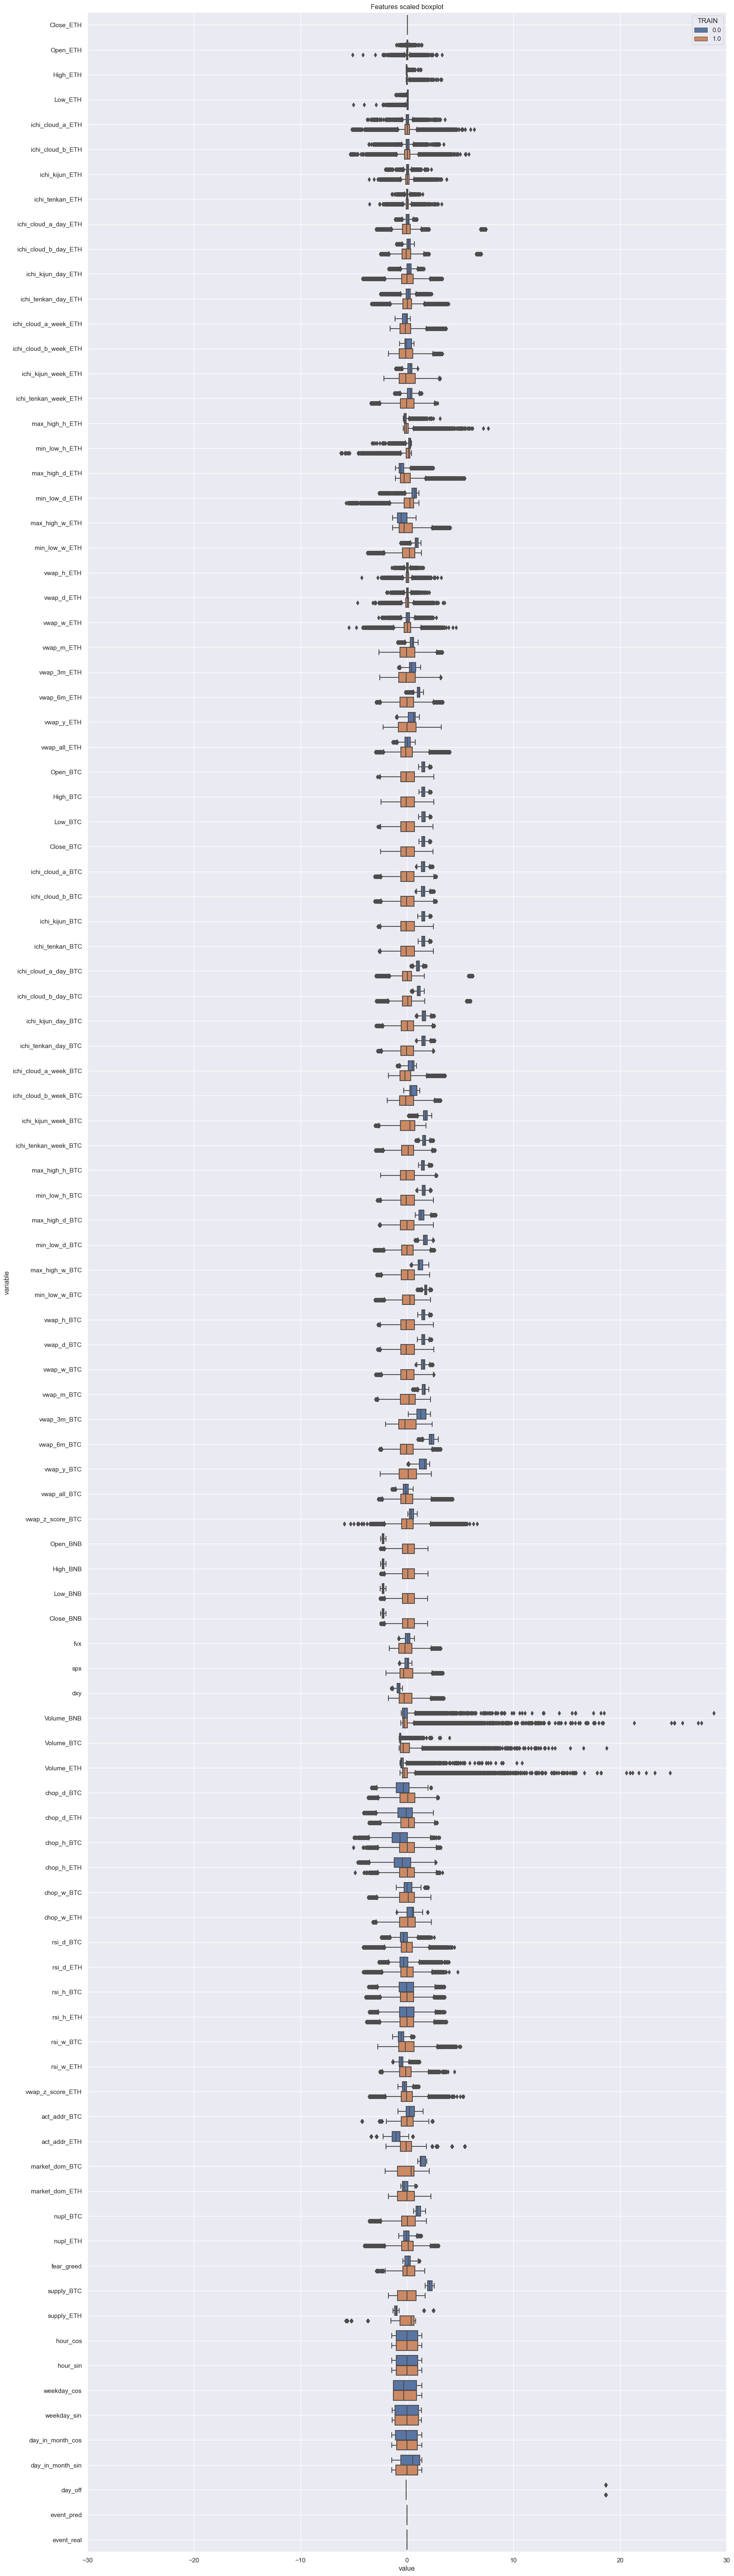

In [61]:
df_comp = df.melt(id_vars=["TRAIN"], value_vars=list_col_select, value_name="value")
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="value", y="variable" , hue="TRAIN")
fig = plt.gcf()
ax = fig.gca()
ax.set_xlim([-30,30])
ax.yaxis.grid(True)
plt.title("Features scaled boxplot")

<AxesSubplot: >

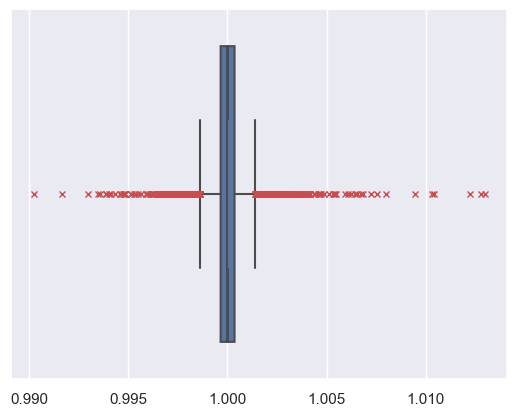

In [62]:
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    notch=True,
    flierprops={"markeredgecolor":"r", "marker": "x"}
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


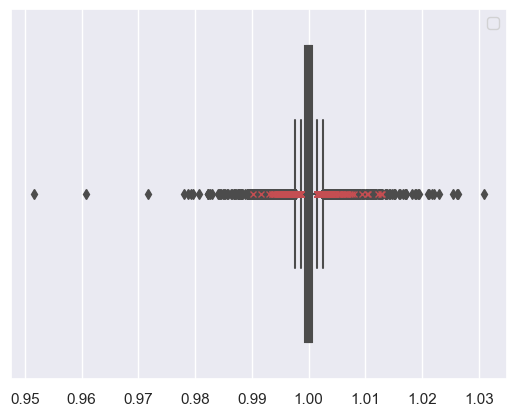

In [63]:
ax = sns.boxplot(
    x=X_train[:,-1,:][:,1],  
)
sns.boxplot(
    x=X_test[:,-1,:][:,1],  
    ax=ax, 
    flierprops={"markeredgecolor":"r", "marker": "x"},
)
plt.legend(loc='upper right')

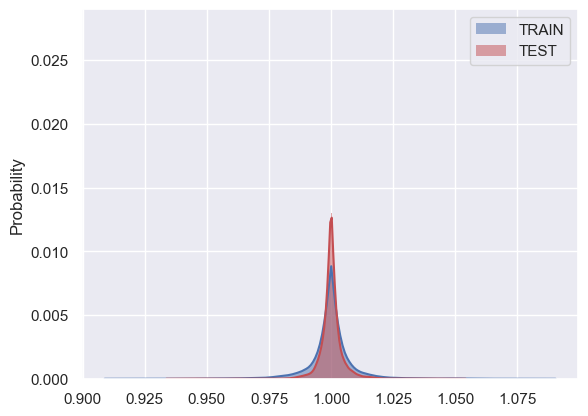

In [64]:

ax = sns.histplot(x=X_train.reshape(-1, X_train.shape[-1])[:,0],  stat="probability", kde=True, label="TRAIN")
sns.histplot(
    x=X_test.reshape(-1, X_test.shape[-1])[:,0],  
    stat="probability", 
    kde=True, 
    ax=ax, 
    color="r",
    label="TEST")
plt.legend(loc='upper right')

## Correlation

To simplify, we try to find correlation between all features X t-0 and target y t+1

In [65]:
X_train_sca.shape

(52444, 72, 102)

In [66]:
X_train_sca[:,-1,:].shape

(52444, 102)

In [67]:
y_train_sca[:,0][:, np.newaxis]

array([[ 0.08592967],
       [-0.03561572],
       [-0.19129716],
       ...,
       [ 0.02887058],
       [ 0.15444641],
       [ 0.16852105]])

In [68]:
np.hstack((X_train_sca[:,-1,:], y_train_sca[:,0][:, np.newaxis])).shape

(52444, 103)

In [69]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [70]:
list_col_select

['Close_ETH',
 'Open_ETH',
 'High_ETH',
 'Low_ETH',
 'ichi_cloud_a_ETH',
 'ichi_cloud_b_ETH',
 'ichi_kijun_ETH',
 'ichi_tenkan_ETH',
 'ichi_cloud_a_day_ETH',
 'ichi_cloud_b_day_ETH',
 'ichi_kijun_day_ETH',
 'ichi_tenkan_day_ETH',
 'ichi_cloud_a_week_ETH',
 'ichi_cloud_b_week_ETH',
 'ichi_kijun_week_ETH',
 'ichi_tenkan_week_ETH',
 'max_high_h_ETH',
 'min_low_h_ETH',
 'max_high_d_ETH',
 'min_low_d_ETH',
 'max_high_w_ETH',
 'min_low_w_ETH',
 'vwap_h_ETH',
 'vwap_d_ETH',
 'vwap_w_ETH',
 'vwap_m_ETH',
 'vwap_3m_ETH',
 'vwap_6m_ETH',
 'vwap_y_ETH',
 'vwap_all_ETH',
 'Open_BTC',
 'High_BTC',
 'Low_BTC',
 'Close_BTC',
 'ichi_cloud_a_BTC',
 'ichi_cloud_b_BTC',
 'ichi_kijun_BTC',
 'ichi_tenkan_BTC',
 'ichi_cloud_a_day_BTC',
 'ichi_cloud_b_day_BTC',
 'ichi_kijun_day_BTC',
 'ichi_tenkan_day_BTC',
 'ichi_cloud_a_week_BTC',
 'ichi_cloud_b_week_BTC',
 'ichi_kijun_week_BTC',
 'ichi_tenkan_week_BTC',
 'max_high_h_BTC',
 'min_low_h_BTC',
 'max_high_d_BTC',
 'min_low_d_BTC',
 'max_high_w_BTC',
 'min_low_

In [71]:
def plot_corr(corr_matrix, title='Corrélation with 2 variables', aspect=None):
    # Afficher la matrice de corrélation
    if aspect is None:
        aspect = 1
    fig_size = (16, 16*len(corr_matrix.index)/len(corr_matrix.columns))
    fig, ax = plt.subplots(figsize=fig_size)
    im = ax.matshow(corr_matrix, aspect=aspect)
    plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
    plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
    plt.title(title)
    fig.colorbar(im)
    plt.show()

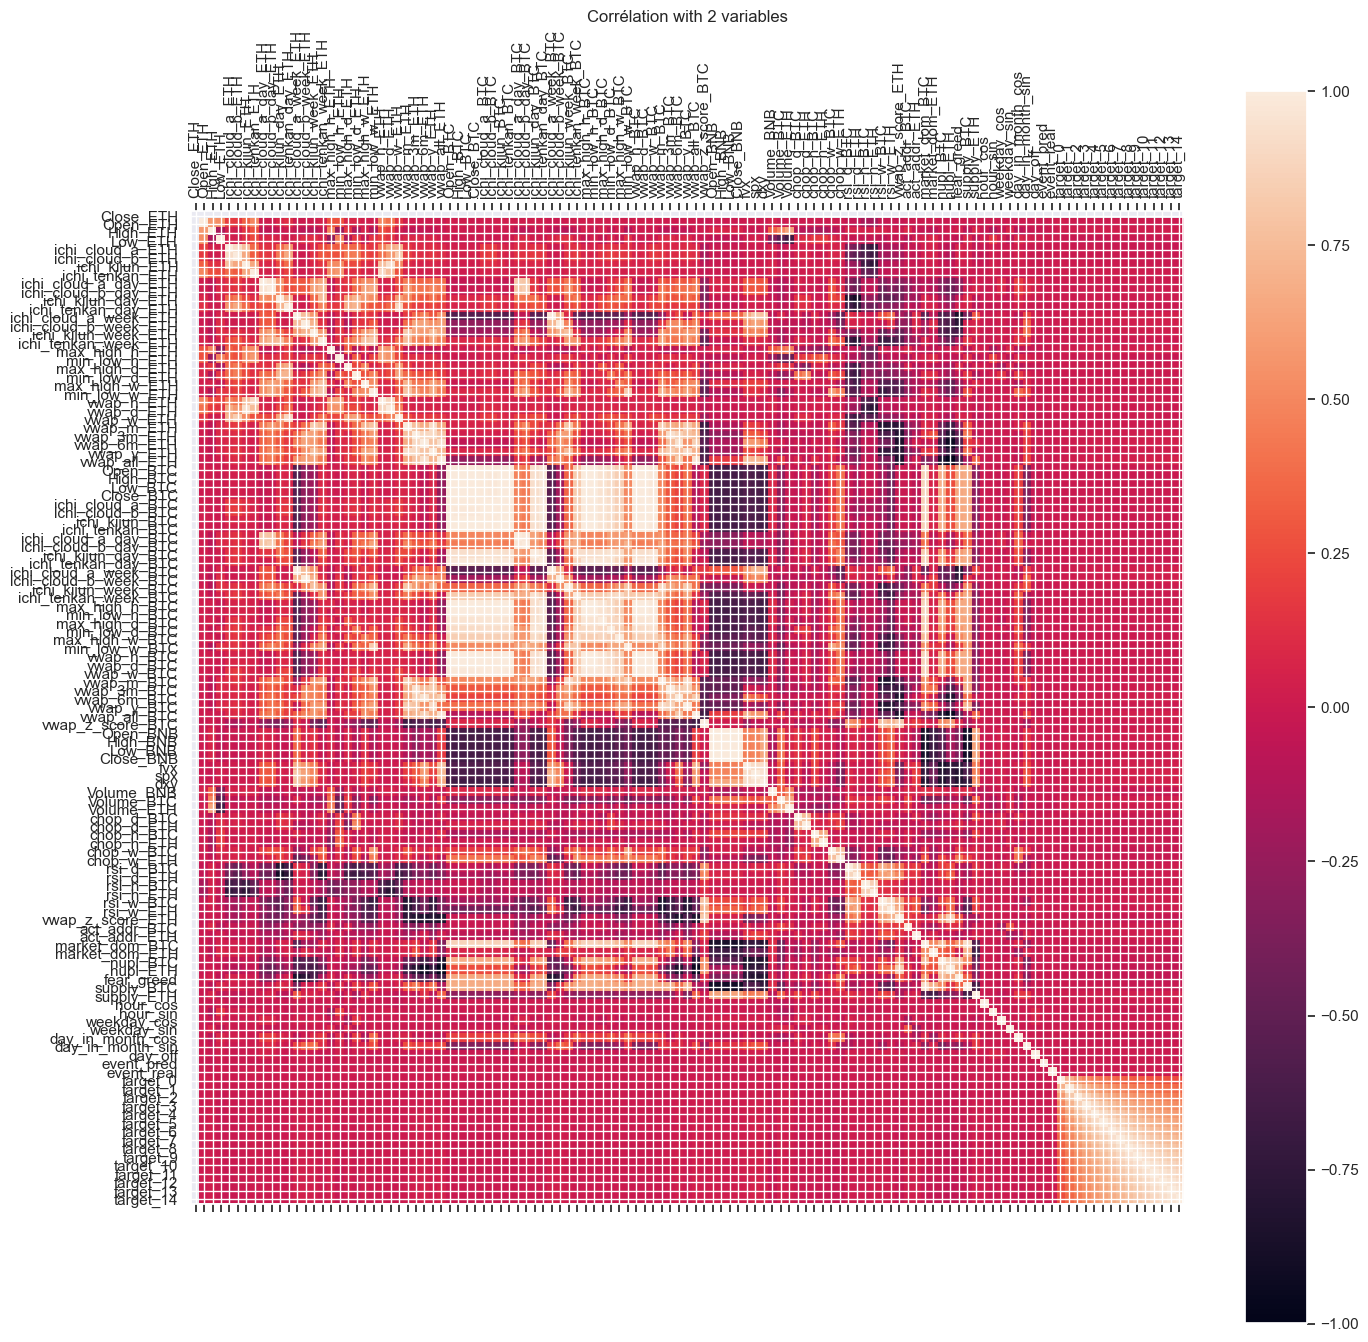

In [72]:

nb_plot = len(list_col_select)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_select[:nb_plot] + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)


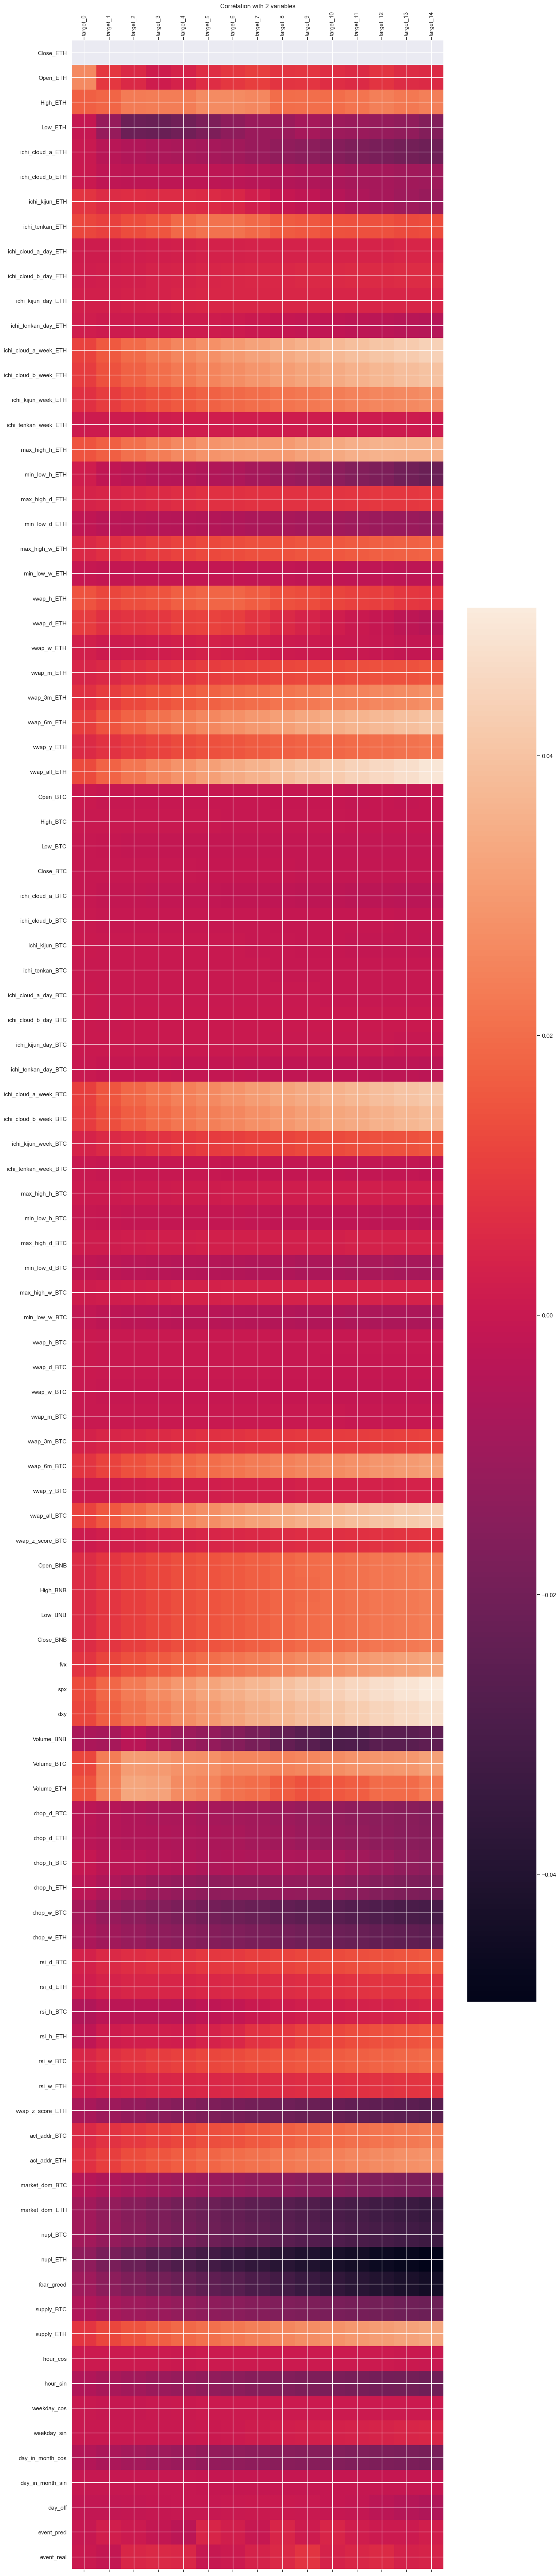

In [73]:
corr_matrix_targets = corr_matrix.copy().loc[list_col_select[:nb_plot], list_col_targets]
fig = plot_corr(corr_matrix_targets)


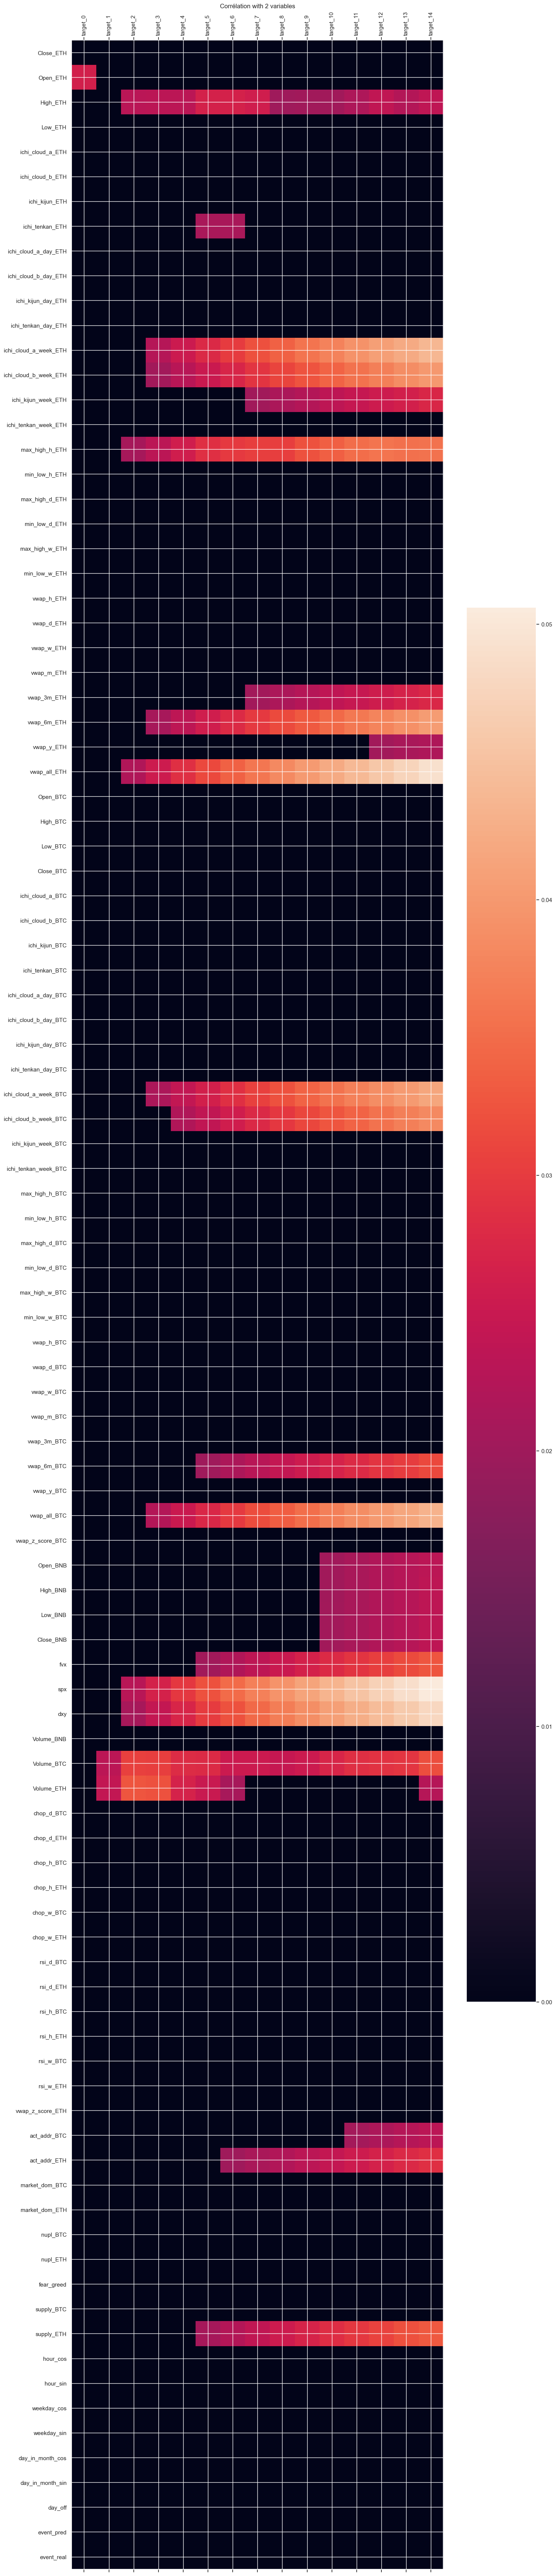

In [74]:
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0))

In [75]:
list_ichi_level=["lower", "neutral", "higher"]
df["ichi_cloud_a_week_cat"] = "neutral"
df.loc[df["ichi_cloud_a_week_ETH"] >= 1.05, "ichi_cloud_a_week_cat"] = "lower"
df.loc[df["ichi_cloud_a_week_ETH"] <= 0.95, "ichi_cloud_a_week_cat"] = "higher"

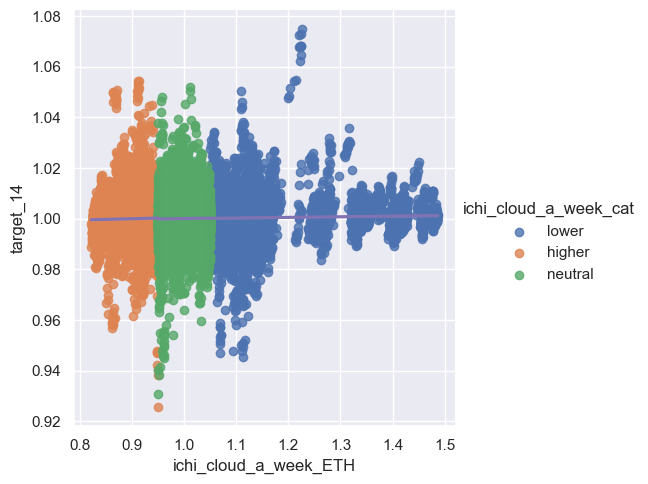

In [76]:
sns.lmplot(x="ichi_cloud_a_week_ETH", y="target_14",
            hue="ichi_cloud_a_week_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='ichi_cloud_a_week_cat'>

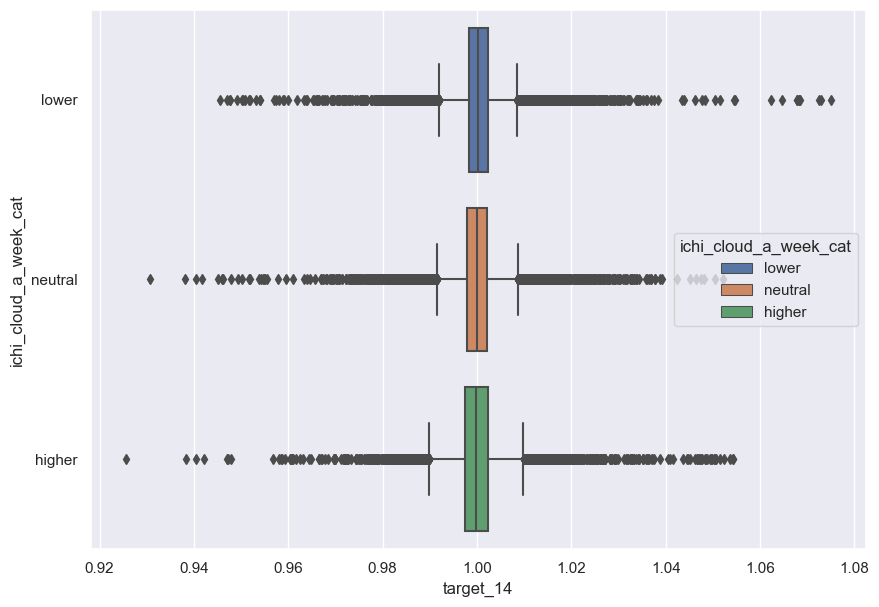

In [77]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="ichi_cloud_a_week_cat", 
    hue="ichi_cloud_a_week_cat", dodge=False, 
    order=list_ichi_level, hue_order=list_ichi_level)

In [78]:
"""df["vwap_all_ETH_under"] = df["vwap_all_ETH"] >= 1.05
df["vwap_all_ETH_above"] = df["vwap_all_ETH"] <= 0.95
df["vwap_all_ETH_neutral"] = ((df["vwap_all_ETH"] > 0.95) & (df["vwap_all_ETH"] < 1.05))
"""
list_vwap_level=["lower", "neutral", "higher"]
df["vwap_all_ETH_cat"] = "neutral"
df.loc[df["vwap_all_ETH"] >= 1.05, "vwap_all_ETH_cat"] = "lower"
df.loc[df["vwap_all_ETH"] <= 0.95, "vwap_all_ETH_cat"] = "higher"


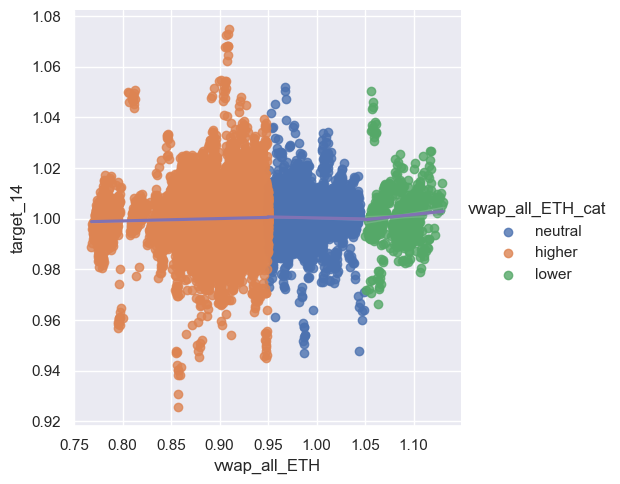

In [79]:
sns.lmplot(x="vwap_all_ETH", y="target_14", hue="vwap_all_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='vwap_all_ETH_cat'>

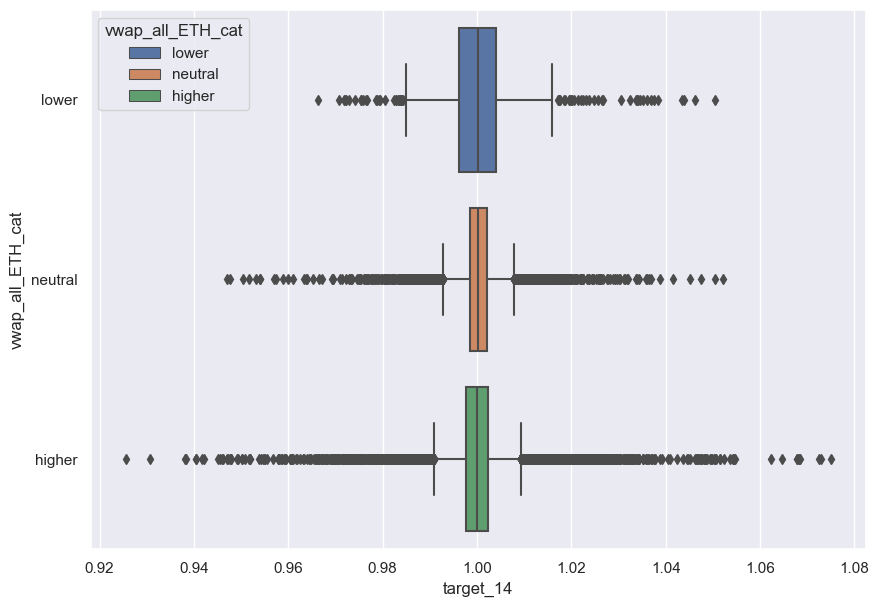

In [80]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="vwap_all_ETH_cat", 
    hue="vwap_all_ETH_cat", dodge=False, 
    order=list_vwap_level, hue_order=list_vwap_level)

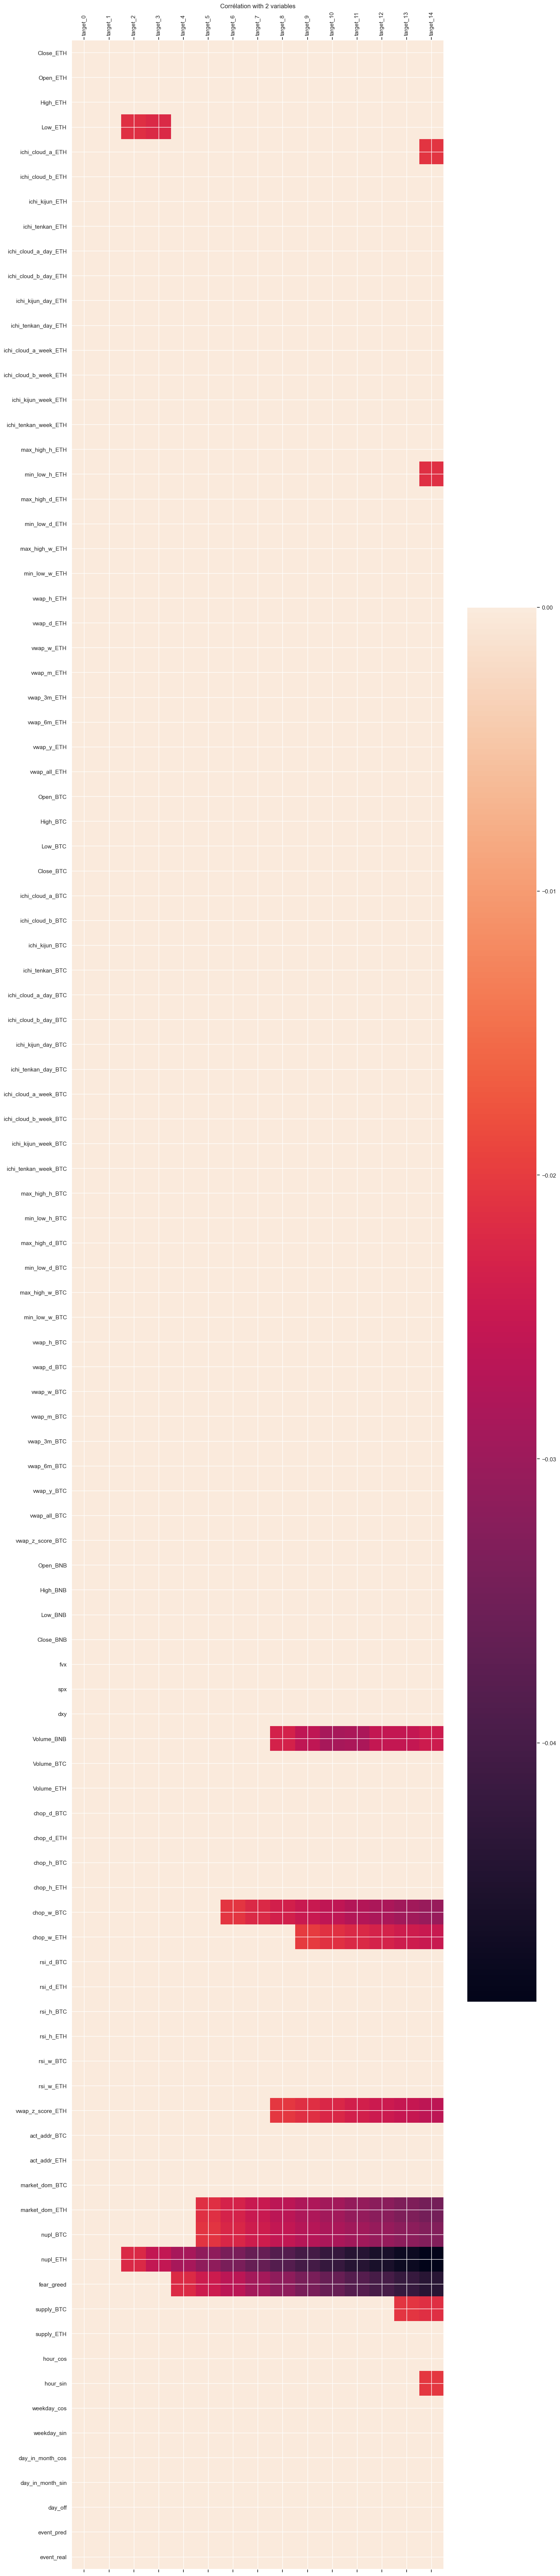

In [81]:
plot_corr(corr_matrix_targets.where(corr_matrix_targets<-0.02, 0))

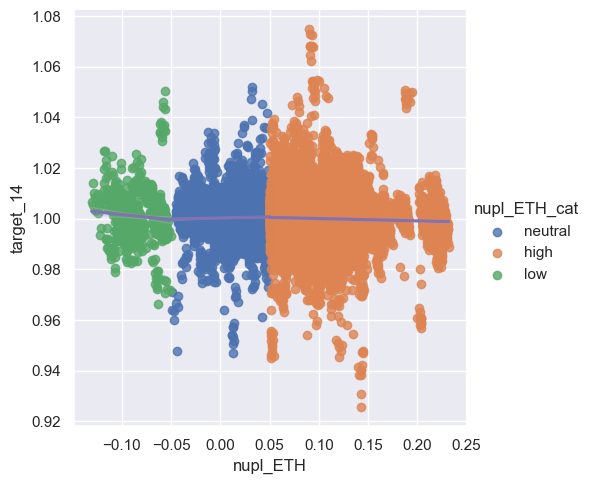

In [82]:


list_nupl_level=["low", "neutral", "high"]
df["nupl_ETH_cat"] = "neutral"
df.loc[df["nupl_ETH"] <= -0.05, "nupl_ETH_cat"] = "low"
df.loc[df["nupl_ETH"] >= 0.05, "nupl_ETH_cat"] = "high"

sns.lmplot(x="nupl_ETH", y="target_14", hue="nupl_ETH_cat", data=df,
           line_kws={"color": "C4"})

<AxesSubplot: xlabel='target_14', ylabel='nupl_ETH_cat'>

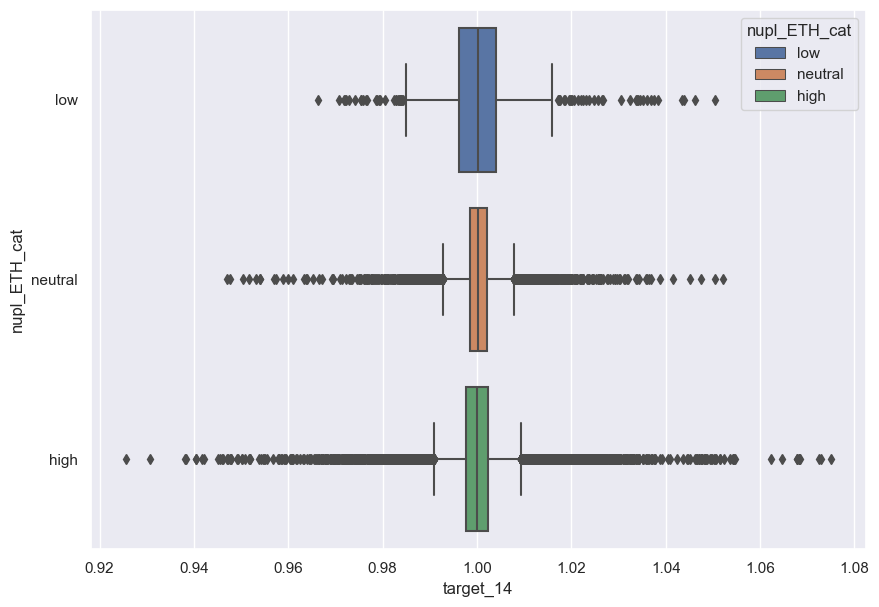

In [83]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="target_14", y="nupl_ETH_cat", 
    hue="nupl_ETH_cat", dodge=False, 
    order=list_nupl_level, hue_order=list_nupl_level)

In [84]:
df["target_14"].describe()

count    52444.000000
mean         1.000153
std          0.006014
min          0.925613
25%          0.997888
50%          1.000045
75%          1.002304
max          1.074927
Name: target_14, dtype: float64

In [85]:
df["target_1"].describe()

count    52444.000000
mean         1.000020
std          0.002206
min          0.967271
25%          0.999169
50%          1.000011
75%          1.000859
max          1.053076
Name: target_1, dtype: float64

<AxesSubplot: xlabel='target_14'>

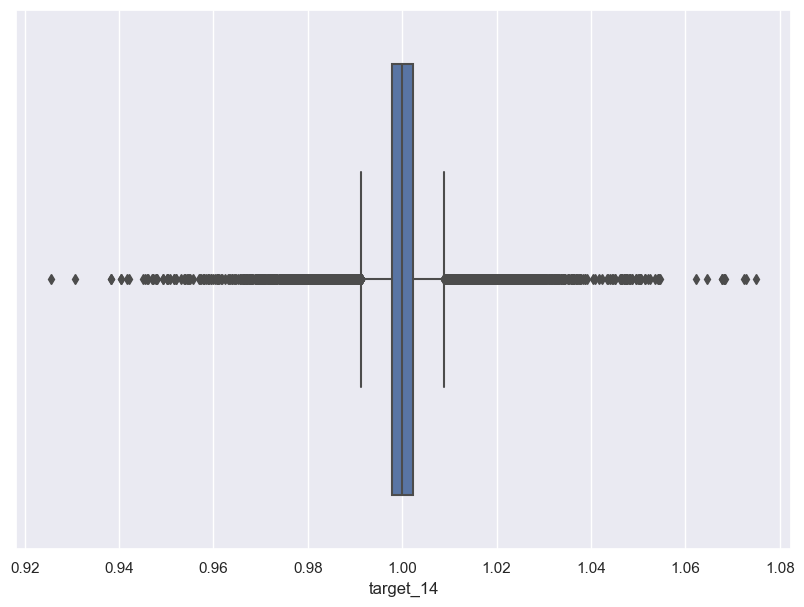

In [86]:
fig = plt.figure(figsize=(10, 7))
sns.boxplot(x=df["target_14"]) 

In [87]:
y_train

array([[1.00046043, 1.00038509, 0.99962329, ..., 0.99989117, 1.00015069,
        0.99985769],
       [0.99992469, 0.99916324, 0.99983265, ..., 0.9996904 , 0.99939753,
        0.99880344],
       [0.99923849, 0.99990795, 0.99943096, ..., 0.9994728 , 0.99887866,
        0.99859414],
       ...,
       [1.00020893, 1.00097152, 1.00179679, ..., 1.00014625, 1.00076259,
        1.00102897],
       [1.00076243, 1.00158753, 1.00107576, ..., 1.00055355, 1.00081987,
        1.00012011],
       [1.00082447, 1.00031309, 1.00033396, ..., 1.0000574 , 0.99935817,
        0.99994782]])

In [88]:
y_train_sca

array([[ 0.08592967,  0.06883625, -0.10399729, ..., -0.04322066,
         0.0156567 , -0.05081774],
       [-0.03561572, -0.20836971, -0.05649807, ..., -0.08877079,
        -0.15521464, -0.29000072],
       [-0.19129716, -0.03941408, -0.14763078, ..., -0.13813808,
        -0.27293432, -0.33748463],
       ...,
       [ 0.02887058,  0.20188329,  0.38911622, ...,  0.01465036,
         0.15448255,  0.2149185 ],
       [ 0.15444641,  0.34164023,  0.22553267, ...,  0.10705557,
         0.16747889,  0.00871958],
       [ 0.16852105,  0.05250195,  0.05723742, ..., -0.0055076 ,
        -0.16414597, -0.03036884]])

## Autoencoder

### Model creation

### Training

In [89]:
X_train_sca.shape

(52444, 72, 102)

In [90]:
3*3*3*10*35/3600

2.625

In [91]:
#n_unit_enc = 16
#encoding_dim = 4
#dropout_autoenc = 0.5
seed = 1
epochs = 30 #100 #150 #6 #300
patience = 10 #30 #20 #40 #3 #100
mse_curr_min = None
if MODE_TRAIN_AE:
    for n_unit_enc in [64]: #[32, 64, 128]: #[104]: #
        for encoding_dim in [16]:#[16, 20, 32]:
            for dropout_autoenc in [0.25]: #[0.05, 0.15, 0.25]: #[0.25]:
                # check already done ? 
                #ie: output_MSE autoencoder - units 16 - enc_dim 4 - drop 0.25.jpg
                plt_name = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
                path_jpg = os.path.join(path_data,
                    f"output_MSE autoencoder - {plt_name}.jpg")
                if (MODE_TRAIN_AE == False):
                    print(f"BE CAREFUL ! training inactivated => no training done...")
                    continue
                print(f"Training: {plt_name} ...")
                # Init
                tf.keras.backend.clear_session()
                np.random.seed(seed)
                random.seed(seed)
                tf.random.set_seed(seed)
                # Input dimension
                input_dim = X_train.shape[-1]
                # Reduced encoded input dimension
                # 64/8/0.5
                # Définir l'encodeur
                encoder_inputs = keras.Input(shape=(None, input_dim))
                encoder = layers.LSTM(n_unit_enc, return_sequences=True)(encoder_inputs)
                #encoder = layers.LayerNormalization()(encoder)
                #encoder = layers.Dense(encoding_dim, activation='relu')
                encoder = layers.Dropout(dropout_autoenc)(encoder)
                encoder_outputs = layers.Dense(encoding_dim)(encoder)
                encoder_model = keras.Model(encoder_inputs, encoder_outputs)
                print(encoder_model.summary())
                # Définir le décodeur
                decoder_inputs = keras.Input(shape=(None, encoding_dim))
                decoder = layers.LSTM(n_unit_enc, return_sequences=True)(decoder_inputs)
                #decoder = layers.LayerNormalization()(decoder)
                #decoder = layers.Dense(n_unit_enc, activation='relu')
                decoder = layers.Dropout(dropout_autoenc)(decoder)
                decoder_outputs = layers.Dense(input_dim)(decoder)
                decoder_model = keras.Model(decoder_inputs, decoder_outputs)
                print(decoder_model.summary())
                # Define complete autoencoder 
                autoencoder_inputs = keras.Input(shape=(None, input_dim))
                encoded = encoder_model(autoencoder_inputs)
                decoded = decoder_model(encoded)
                autoencoder = keras.Model(autoencoder_inputs, decoded)
                # Compile : autoencoder
                optim = tf.keras.optimizers.legacy.Adam()
                #optim = tf.keras.optimizers.Adam()
                autoencoder.compile(optimizer=optim, loss="mse")
                # earlystop 
                es = EarlyStopping(patience=patience, verbose=2, min_delta=0.001, 
                                monitor='val_loss', mode='auto', restore_best_weights=True)
                # Train
                if patience == 0:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                    epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                    verbose=1)
                else:
                    autoenc_step_history = autoencoder.fit(X_train_sca,X_train_sca,
                        epochs=epochs, batch_size=BATCH_SIZE, validation_data=(X_test_sca,X_test_sca),
                        verbose=1, callbacks=[es])

                plot_train_history(
                    autoenc_step_history,f"MSE autoencoder - {plt_name}",
                    saveFolder=path_data)
                #autoencoder.save(f"{path_mdl_autoencoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                #encoder_model.save(f"{path_mdl_encoder}_u{n_unit_enc}_e{encoding_dim}_d{dropout_autoenc}")
                            # save the best
                mse_curr = np.min(autoenc_step_history.history['val_loss'])
                print("MSE TEST : ", mse_curr)

                if mse_curr_min == None:
                    mse_curr_min = mse_curr
                    n_unit_enc_min = n_unit_enc
                    encoding_dim_min = encoding_dim
                    dropout_autoenc_min = dropout_autoenc
                    print("Save autoencoder: ", path_mdl_autoencoder)
                    autoencoder.save(path_mdl_autoencoder)
                    print("Save encoder: ", path_mdl_encoder)
                    encoder_model.save(path_mdl_encoder)
                else:
                    if mse_curr < mse_curr_min:
                        mse_curr_min = mse_curr
                        n_unit_enc_min = n_unit_enc
                        encoding_dim_min = encoding_dim
                        dropout_autoenc_min = dropout_autoenc
                        print("Save autoencoder: ", path_mdl_autoencoder)
                        autoencoder.save(path_mdl_autoencoder)
                        print("Save encoder: ", path_mdl_encoder)
                        encoder_model.save(path_mdl_encoder)

    mse_curr = mse_curr_min 
    n_unit_enc = n_unit_enc_min 
    encoding_dim = encoding_dim_min
    dropout_autoenc = dropout_autoenc_min
else:
    print("Load models...")
    autoencoder = tf.keras.models.load_model(path_mdl_autoencoder)
    print(autoencoder.summary())
    encoder_model = tf.keras.models.load_model(path_mdl_encoder)
    print(encoder_model.summary())
    n_unit_enc = encoder_model.layers[1].units
    dropout_autoenc = encoder_model.layers[2].rate
    encoding_dim = encoder_model.layers[3].units

print(f"Best model : n_unit:{n_unit_enc} / enc_dim: {encoding_dim} / dropout: {dropout_autoenc}")

Load models...
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None, 102)]       0         
                                                                 
 model (Functional)          (None, None, 16)          43792     
                                                                 
 model_1 (Functional)        (None, None, 102)         27366     
                                                                 
Total params: 71158 (277.96 KB)
Trainable params: 71158 (277.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 102)]       0         
                                                    

### Save model

In [92]:
# TODO select best model


In [93]:
path_mdl_autoencoder

'data/mdl_autoencoder'

In [94]:
#autoencoder.save(path_mdl_autoencoder)
#encoder_model.save(path_mdl_encoder)


In [95]:
X_train_sca_pred = autoencoder.predict(X_train_sca)
X_train_sca_pred.shape

1639/1639 [==============================] - 35s 21ms/step


(52444, 72, 102)

### Results

In [96]:
X_train[:,-1,0]

array([1., 1., 1., ..., 1., 1., 1.])

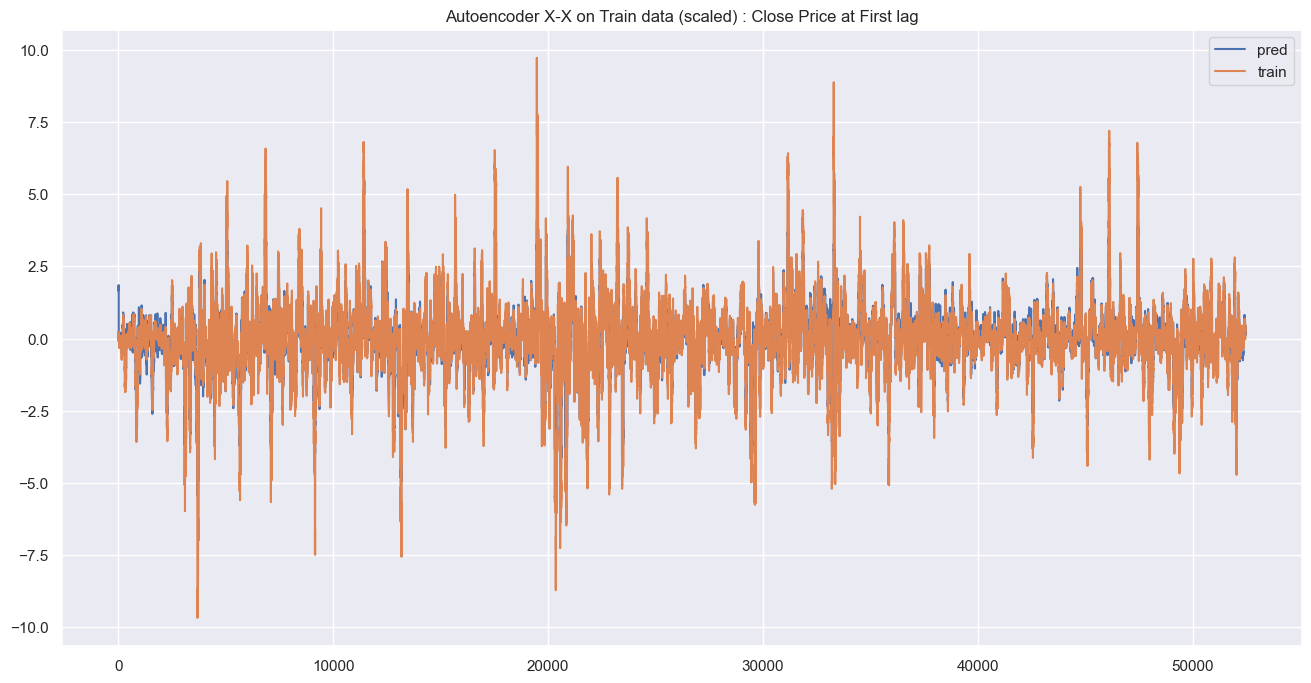

In [97]:
fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data (scaled) : Close Price at First lag")
plt.plot(X_train_sca_pred[:,0,0], label="pred")
plt.plot(X_train_sca[:,0,0], label="train")
plt.legend(loc='upper right')

##### MAE TRAIN by lags and by features

In [98]:
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)

mae_ae_train = np.mean(np.abs(X_train_sca_pred - X_train_sca), 0)
print(mae_ae_train.shape)

df_mae_ae_train = pd.DataFrame(mae_ae_train, columns=list_col_select)
df_mae_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_train.index))]
mae_ae_train_feat = np.mean(mae_ae_train, 0)[np.newaxis,:]
print(mae_ae_train_feat.shape)

df_mae_ae_train_feat = pd.DataFrame(mae_ae_train_feat, columns=list_col_select)

(52444, 72, 102)
(52444, 72, 102)
(72, 102)
(1, 102)


In [99]:
df_mae_ae_train

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.230332  0.234434  0.225714  0.228922          0.303582   
lag_1    0.174066  0.173803  0.167160  0.169838          0.259300   
lag_2    0.160084  0.156180  0.151251  0.154749          0.239541   
lag_3    0.145285  0.139152  0.134425  0.139662          0.227009   
lag_4    0.143960  0.136981  0.131898  0.138418          0.218393   
...           ...       ...       ...       ...               ...   
lag_67   0.098517  0.099798  0.088558  0.095136          0.158049   
lag_68   0.097634  0.099132  0.087740  0.094341          0.157819   
lag_69   0.096732  0.098422  0.086895  0.093493          0.157607   
lag_70   0.095822  0.097645  0.086007  0.092649          0.157377   
lag_71   0.094682  0.097198  0.084992  0.091751          0.157175   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.334060        0.246826         0.248012   
lag_1           0.290957        0.193371         0.188916   
lag_2           0.270087        0.172027         0.167299   
lag_3           0.258278        0.157299         0.147537   
lag_4           0.248540        0.153434         0.140523   
...                  ...             ...              ...   
lag_67          0.163348        0.119409         0.093231   
lag_68          0.163182        0.119014         0.092619   
lag_69          0.163030        0.118638         0.092073   
lag_70          0.162843        0.118272         0.091493   
lag_71          0.162716        0.117833         0.090890   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  \
lag_0               0.287067              0.232724  ...    0.288656  0.579441   
lag_1               0.234613              0.183277  ...    0.226482  0.429417   
lag_2               0.198928              0.149095  ...    0.184071  0.358796   
lag_3               0.181215              0.136584  ...    0.156302  0.315550   
lag_4               0.172918              0.129028  ...    0.141126  0.286853   
...                      ...                   ...  ...         ...       ...   
lag_67              0.129186              0.107257  ...    0.114801  0.184844   
lag_68              0.129195              0.107241  ...    0.114726  0.184840   
lag_69              0.129197              0.107225  ...    0.114652  0.184827   
lag_70              0.129195              0.107197  ...    0.114553  0.184843   
lag_71              0.129201              0.107166  ...    0.114469  0.184839   

        hour_sin  weekday_cos  weekday_sin  day_in_month_cos  \
lag_0   0.604319     0.572851     0.571192          0.644694   
lag_1   0.445139     0.434583     0.457690          0.488862   
lag_2   0.381880     0.363304     0.404922          0.406138   
lag_3   0.344866     0.325130     0.372151          0.359882   
lag_4   0.318722     0.295985     0.346402          0.328256   
...          ...          ...          ...               ...   
lag_67  0.202038     0.202265     0.203025          0.184449   
lag_68  0.201951     0.202142     0.202922          0.184346   
lag_69  0.201845     0.201999     0.202824          0.184249   
lag_70  0.201745     0.201901     0.202730          0.184144   
lag_71  0.201653     0.201786     0.202650          0.184024   

        day_in_month_sin   day_off  event_pred  event_real  
lag_0           0.554922  0.327114    0.036874    0.086292  
lag_1           0.427535  0.259138    0.035594    0.064719  
lag_2           0.359222  0.190724    0.034546    0.058632  
lag_3           0.322516  0.145715    0.033801    0.051484  
lag_4           0.294901  0.123558    0.033796    0.049662  
...                  ...       ...         ...         ...  
lag_67          0.186265  0.074360    0.035416    0.038582  
lag_68          0.186180  0.074318    0.035415    0.038523  
lag_69          0.186107  0.074278    0.035415    0.038454  
lag_70          0.186049  0.074220    0.035416    0.038399  
lag_71          0.185977  0.07419

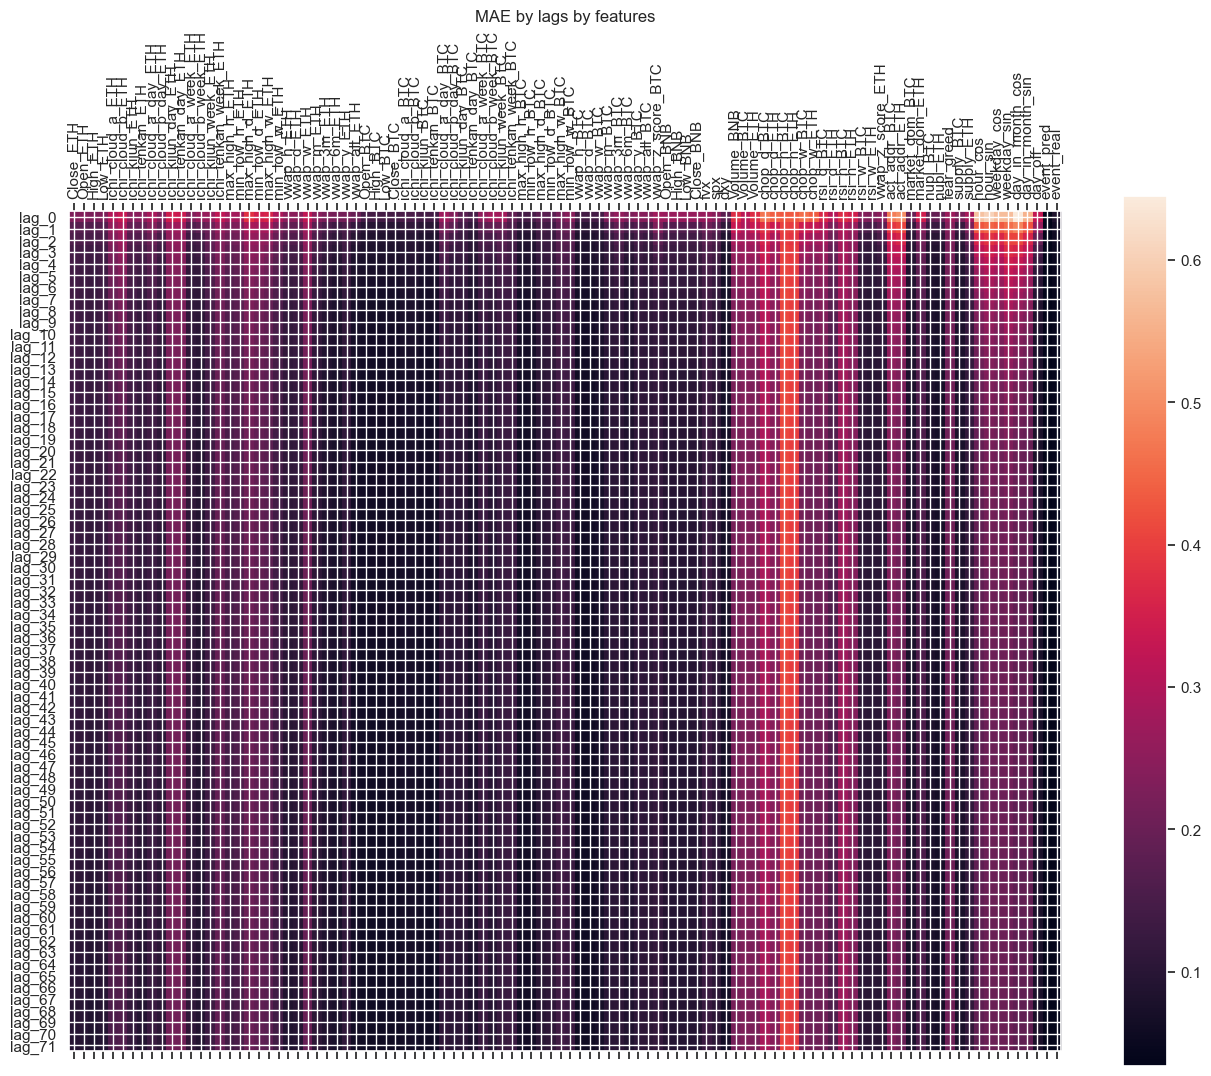

In [100]:
plot_corr(df_mae_ae_train, "MAE by lags by features", aspect=1.2 )

/Users/gregory/miniforge3/envs/ocean_tf_new/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

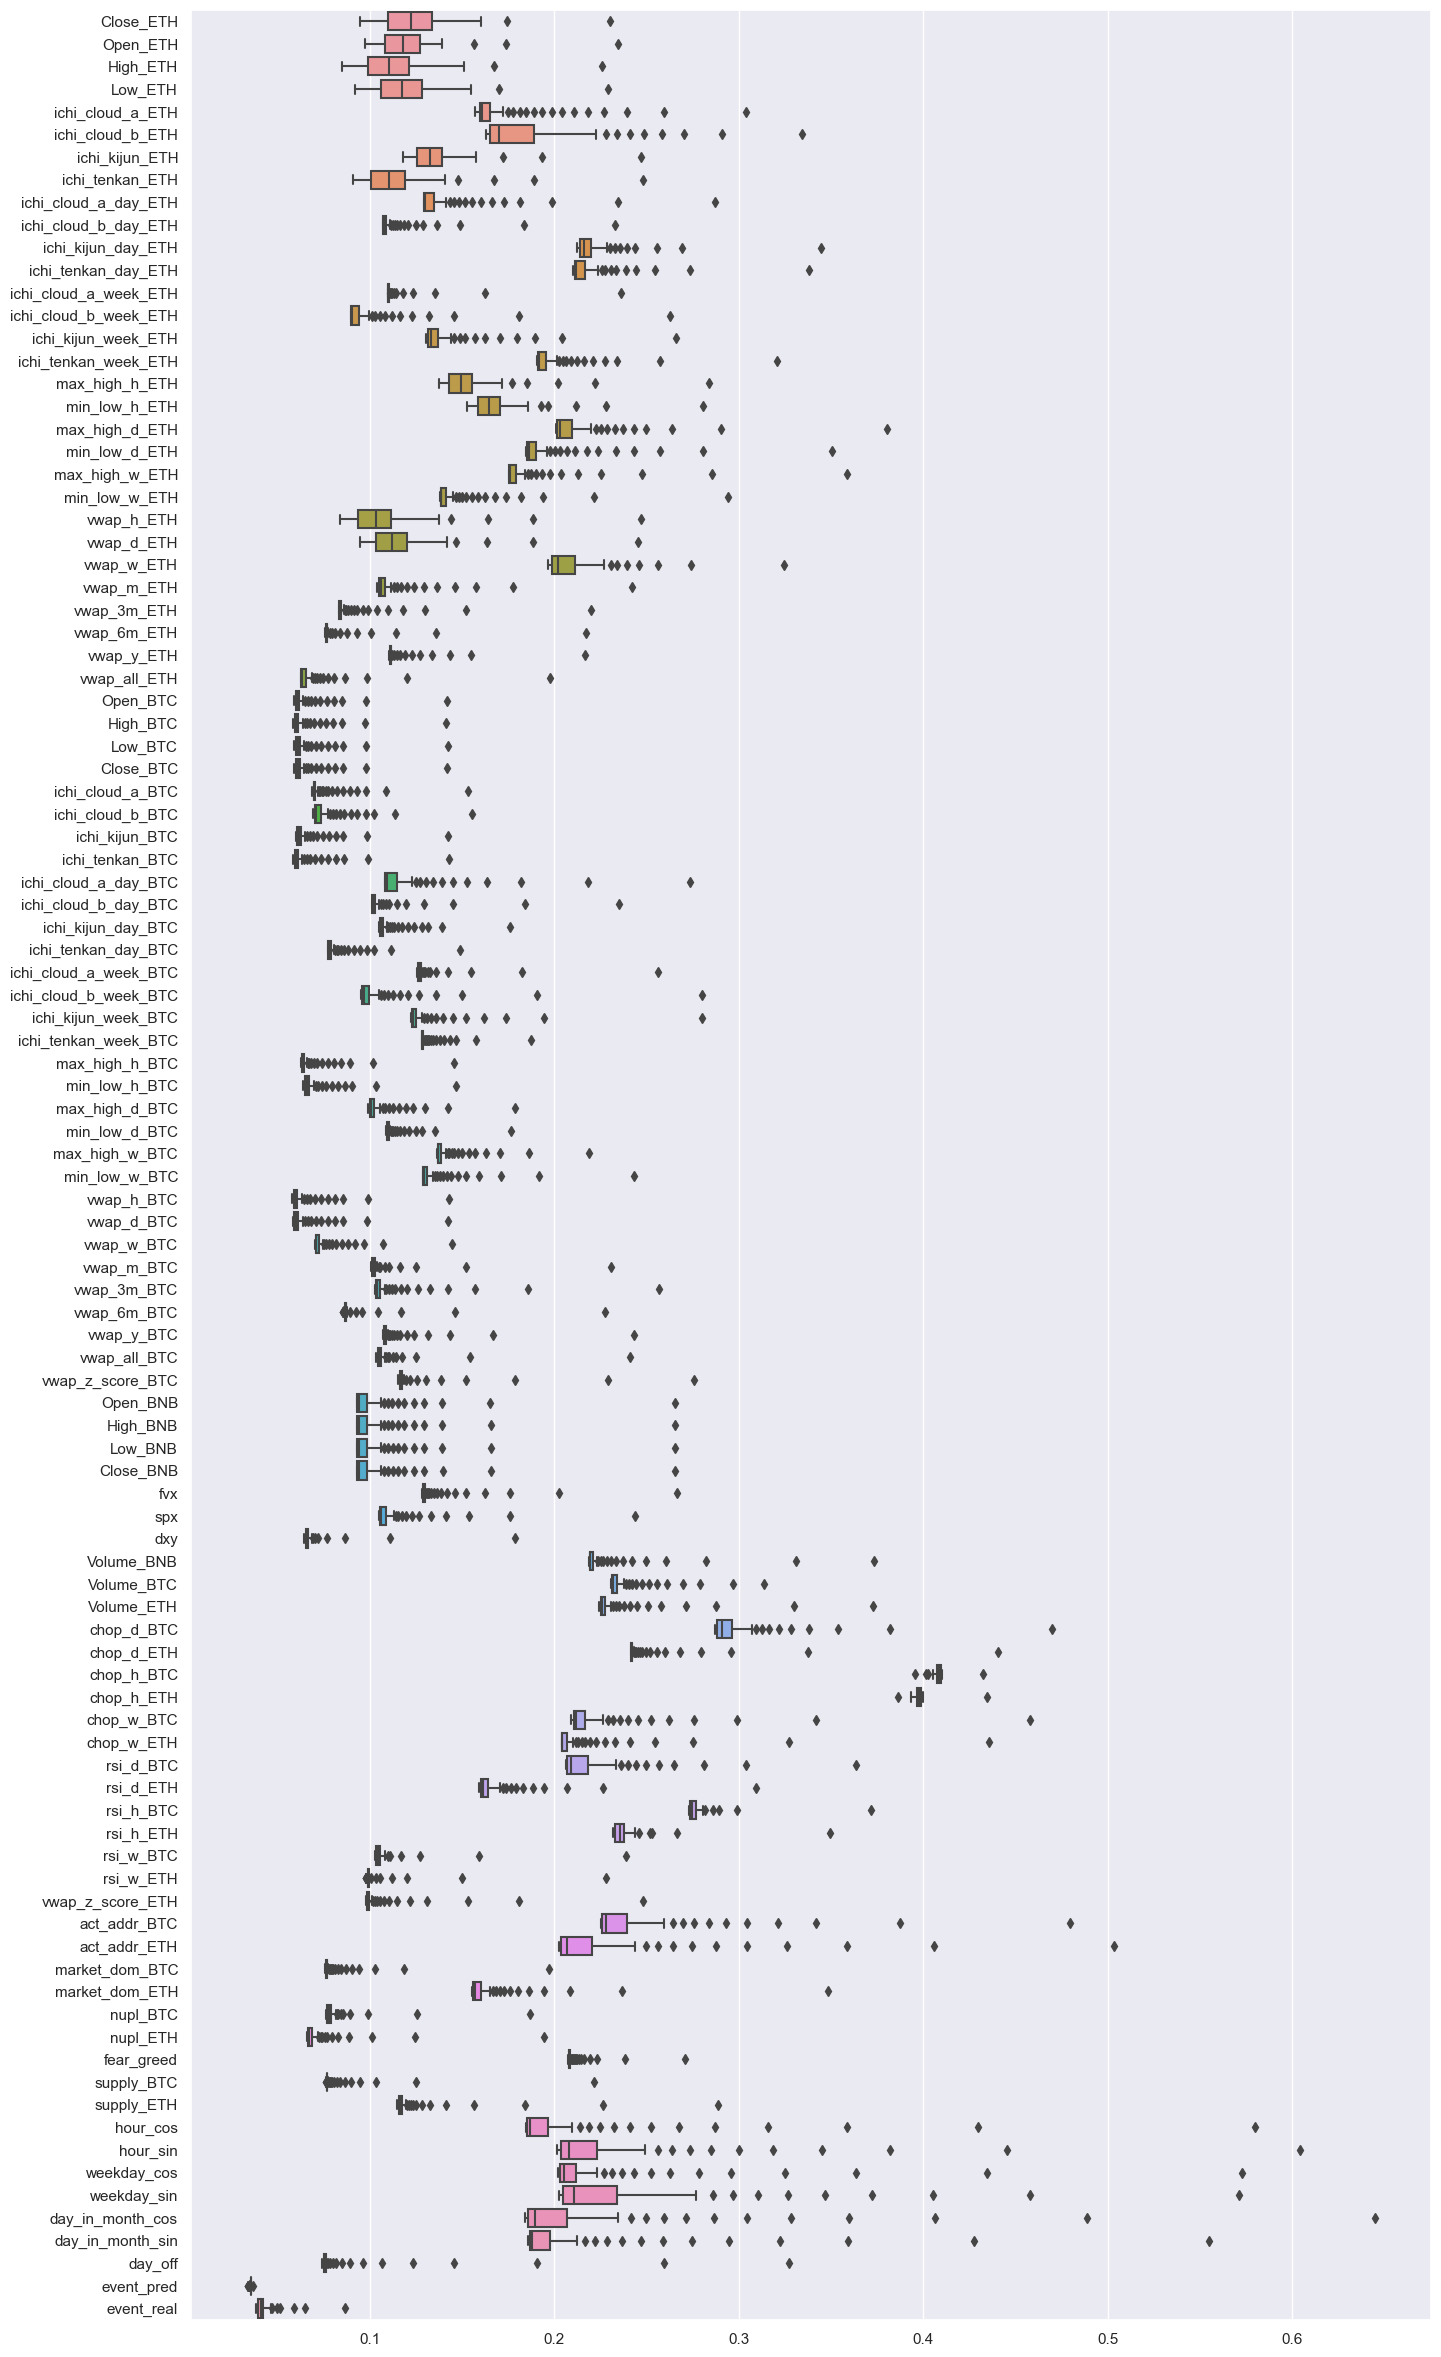

In [101]:
plt.figure(figsize=(16, 30))
sns.boxplot(data=df_mae_ae_train, orient="h")

In [102]:
df_mae_ae_train_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.123152  0.119762  0.111822  0.118686          0.170609   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.184653        0.135127         0.113471              0.138874   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.112791  ...    0.122945  0.207429  0.229817     0.223282   

   weekday_sin  day_in_month_cos  day_in_month_sin   day_off  event_pred  \
0      0.23599          0.216759          0.208882  0.086037    0.035309   

   event_real  
0    0.042356  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature')

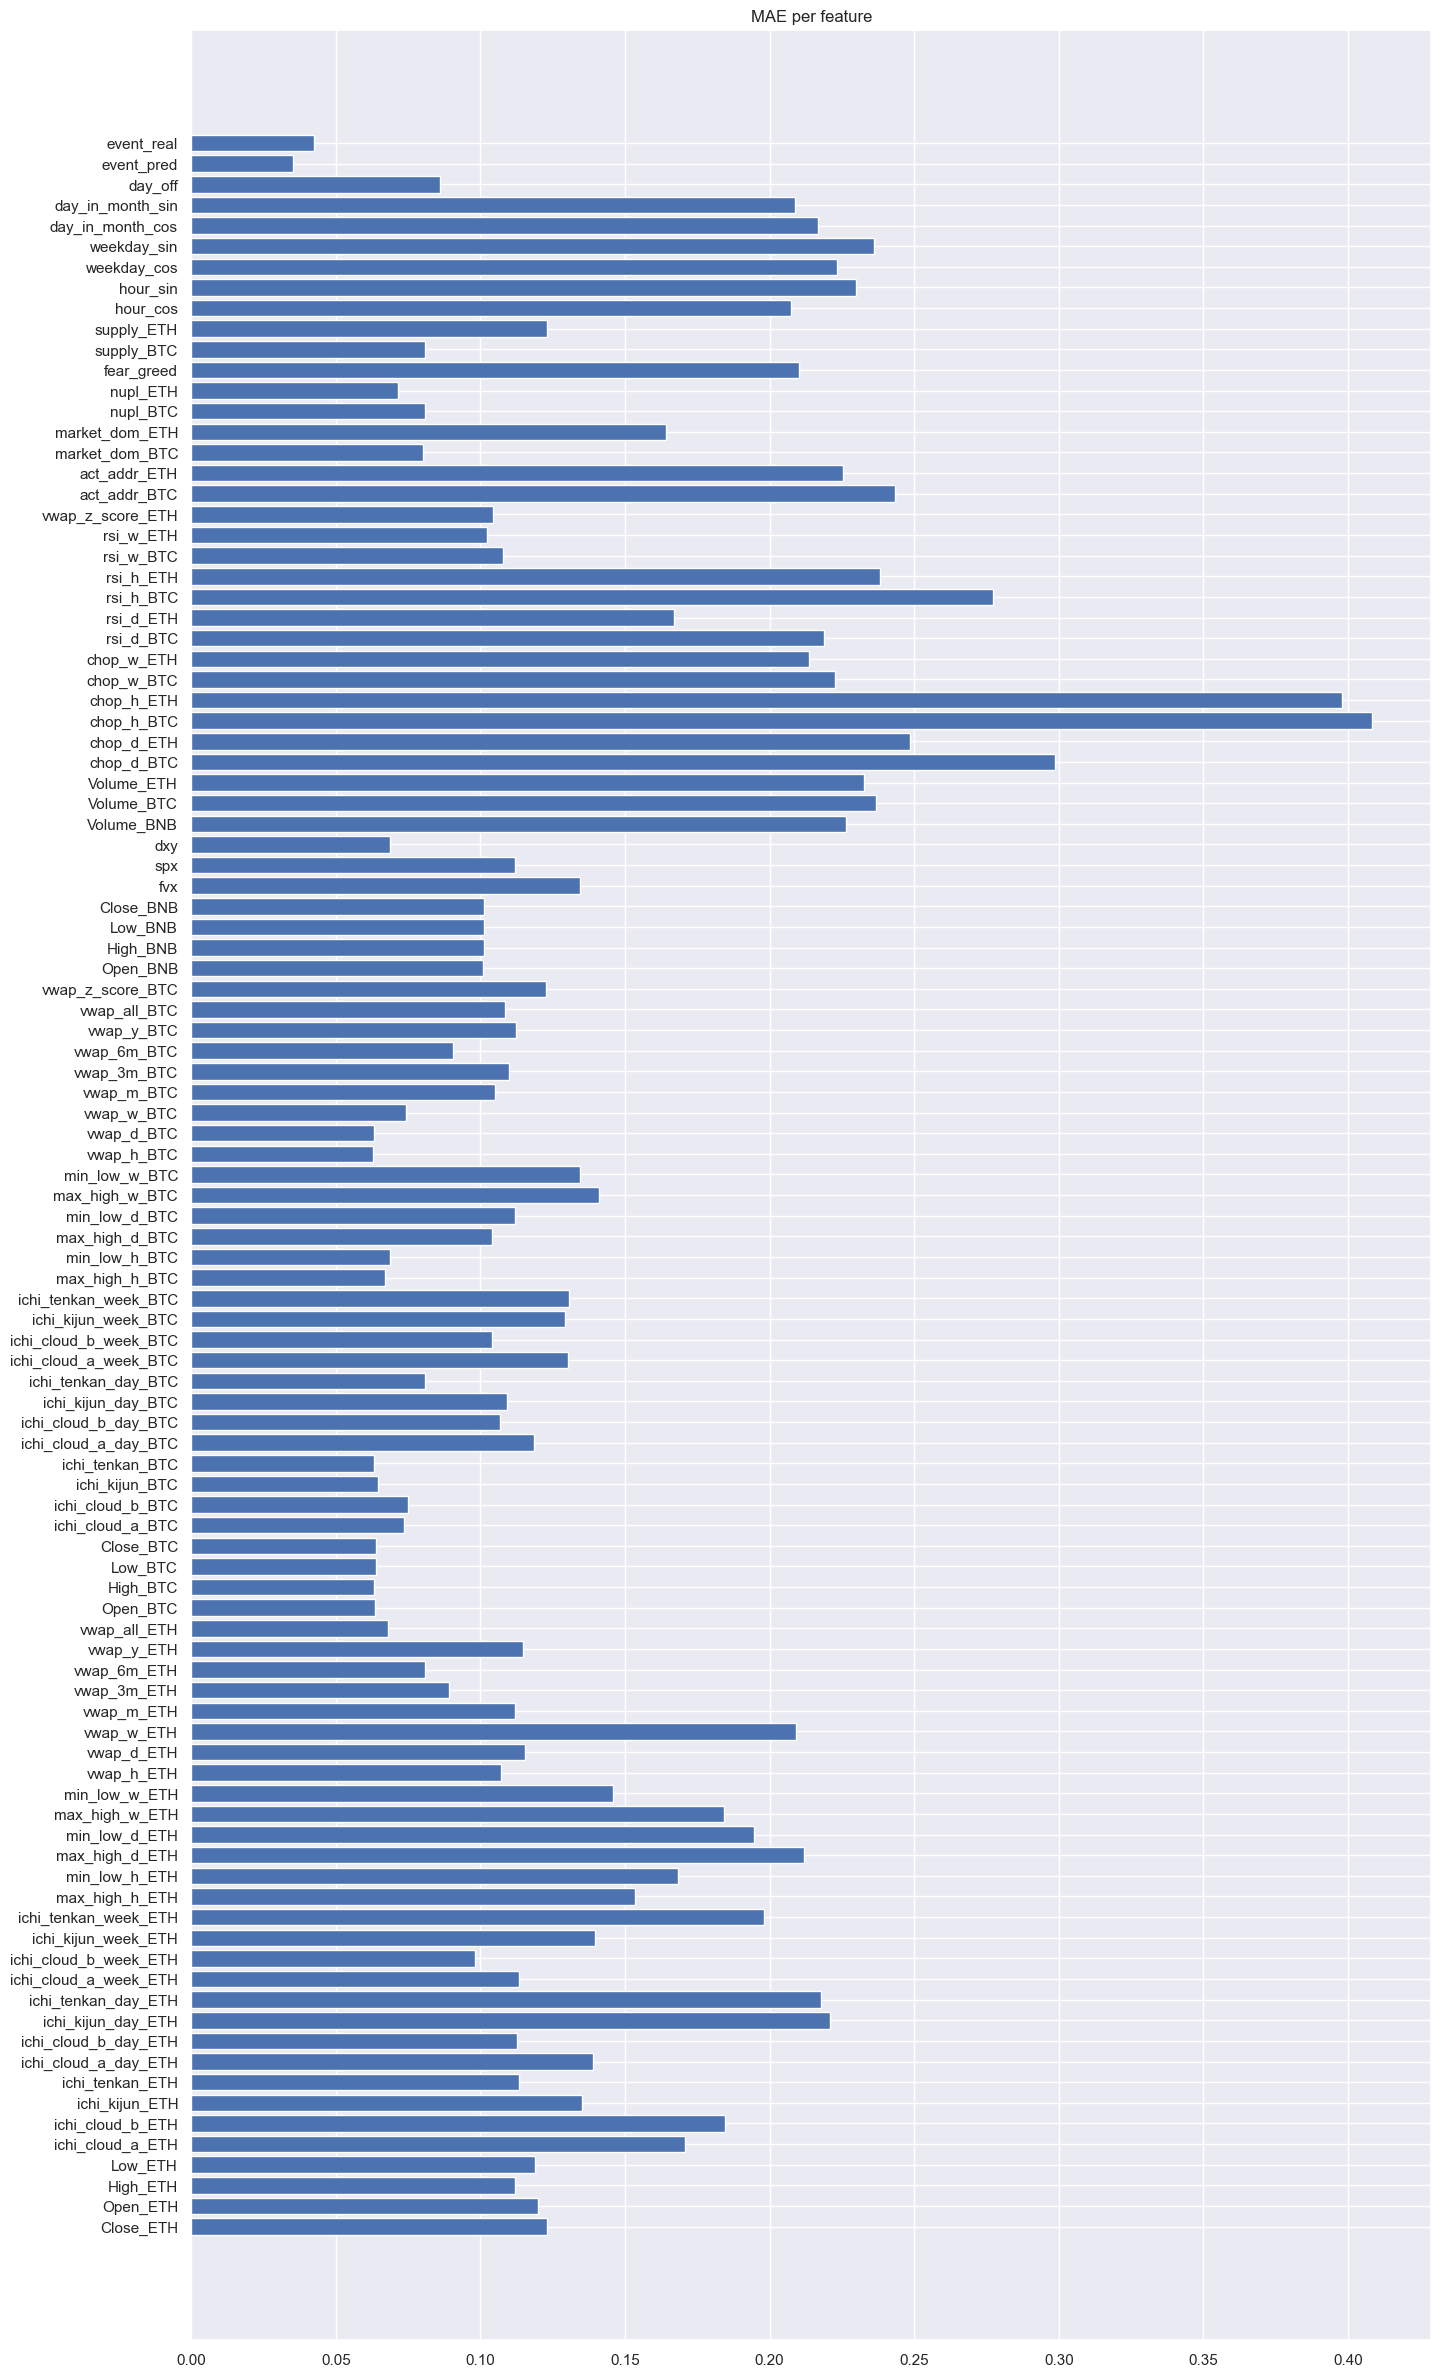

In [103]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_train_feat.columns, df_mae_ae_train_feat.values[0])
plt.title("MAE per feature")

In [104]:
# X_train_raw
# X_train[0,:10, 0] * X_train_raw[0,-1, 0]
# [samples, lags, features]
print(X_train[:,0, 0].shape)
print(X_train_raw[:,-1, 0].shape)
print(X_train[:,0, 0] * X_train_raw[:,-1, 0])
print(df_feat["Close_ETH"].values[:3])

(52444,)
(52444,)
[1196.32 1195.38 1194.55 ... 1919.29 1919.84 1915.43]
[1196.32 1195.38 1194.55]


In [105]:
X_train_pred = scaler.inverse_transform(X_train_sca_pred.reshape(-1,X_train_sca_pred.shape[-1])).reshape(X_train_sca_pred.shape)
X_train_pred[:,-1,0]

array([0.9997844 , 0.99953336, 0.99956787, ..., 1.0011419 , 1.0011039 ,
       1.0014092 ], dtype=float32)

[1196.32 1195.38 1194.55 ... 1919.29 1919.84 1915.43]
[1212.91803577 1213.41324271 1213.19906652 ... 1918.03469621 1920.23904853
 1917.99441482]


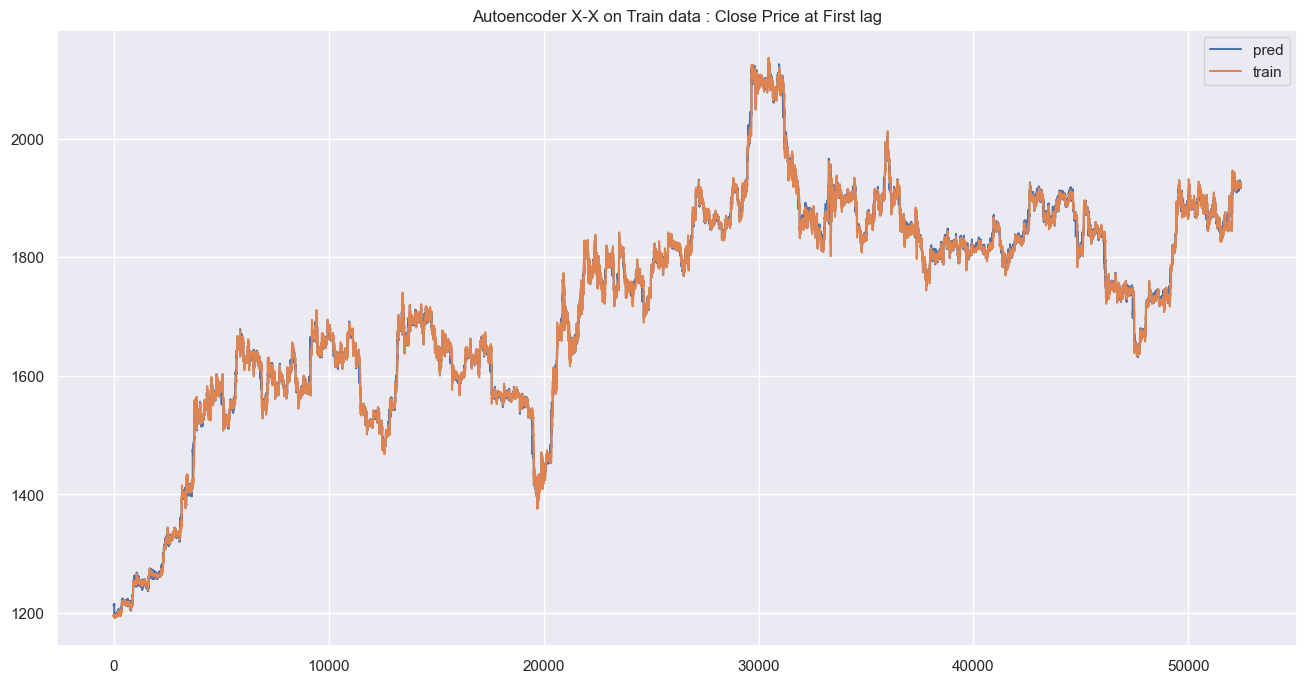

In [106]:
print(X_train_raw[:,0, 0])
print(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Train data : Close Price at First lag")
plt.plot(X_train_pred[:,0, 0] * X_train_raw[:,-1, 0], label="pred")
plt.plot(X_train_raw[:,0,0], label="train")
plt.legend(loc='upper right')

#### MAE TEST per features

In [107]:
X_test_sca_pred = autoencoder.predict(X_test_sca)
X_test_sca_pred.shape

408/408 [==============================] - 8s 21ms/step


(13044, 72, 102)

In [108]:
df_feat["date_ETH"].iloc[TRAIN_SPLIT]

'2023-07-02 09:30:00'

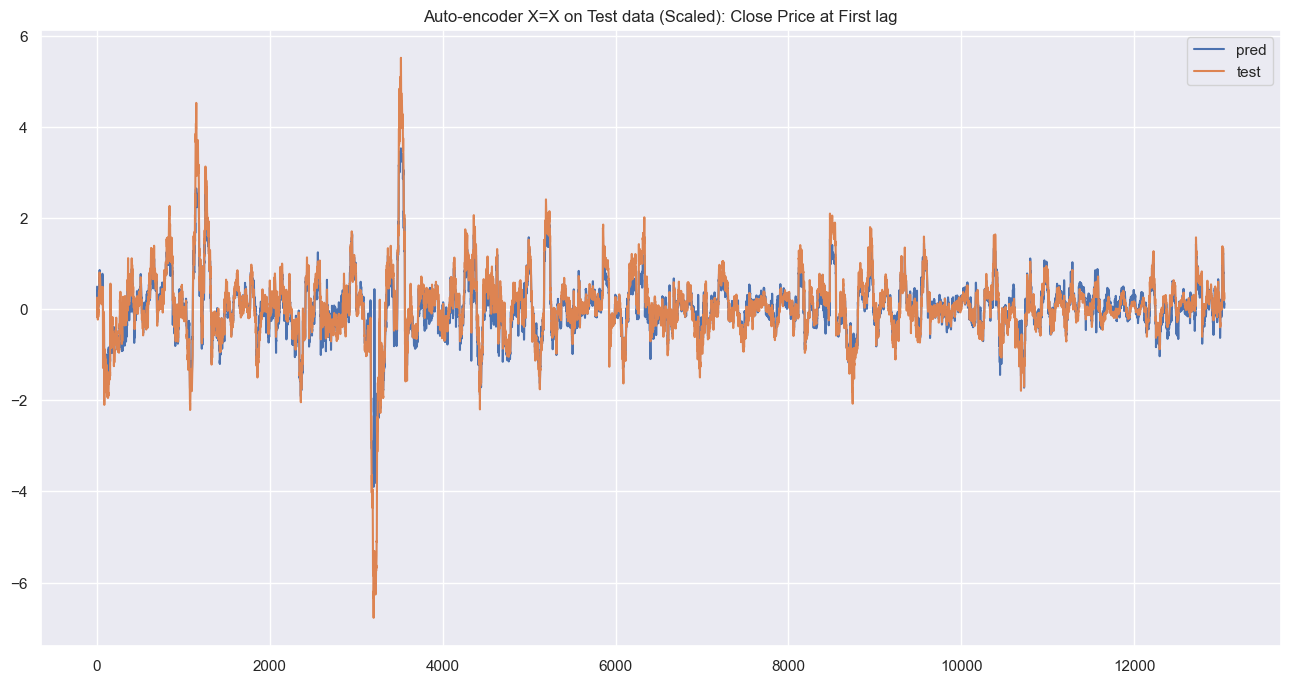

In [109]:
fig = plt.figure(figsize=(16, 8))
plt.title("Auto-encoder X=X on Test data (Scaled): Close Price at First lag")
plt.plot(X_test_sca_pred[:,0,0], label="pred")
plt.plot(X_test_sca[:,0,0], label="test")
plt.legend(loc='upper right')

In [110]:
# X  _raw : df feat raw data
# X : price normalized
# X  _sca : standardized use by model
# X      _pred : predict
X_test_pred = scaler.inverse_transform(X_test_sca_pred.reshape(-1,X_test_sca_pred.shape[-1])).reshape(X_test_sca_pred.shape)
print("X test raw  : ", X_test_raw[:,0, 0][:9])
print("X test pred : ", (X_test_pred[:,0,0] * X_test_raw[:,-1, 0])[:9])

X test raw  :  [1917.11 1917.3  1917.73 1917.29 1917.78 1918.92 1917.61 1917.73 1916.98]
X test pred :  [1921.38430405 1925.55779272 1925.12224049 1924.92988694 1923.23864493
 1923.89197042 1923.92735178 1922.707591   1920.75924093]


[1917.11 1917.3  1917.73 ... 1818.28 1816.59 1817.19]
[1921.38430405 1925.55779272 1925.12224049 ... 1814.47058385 1814.67416494
 1813.77032392]


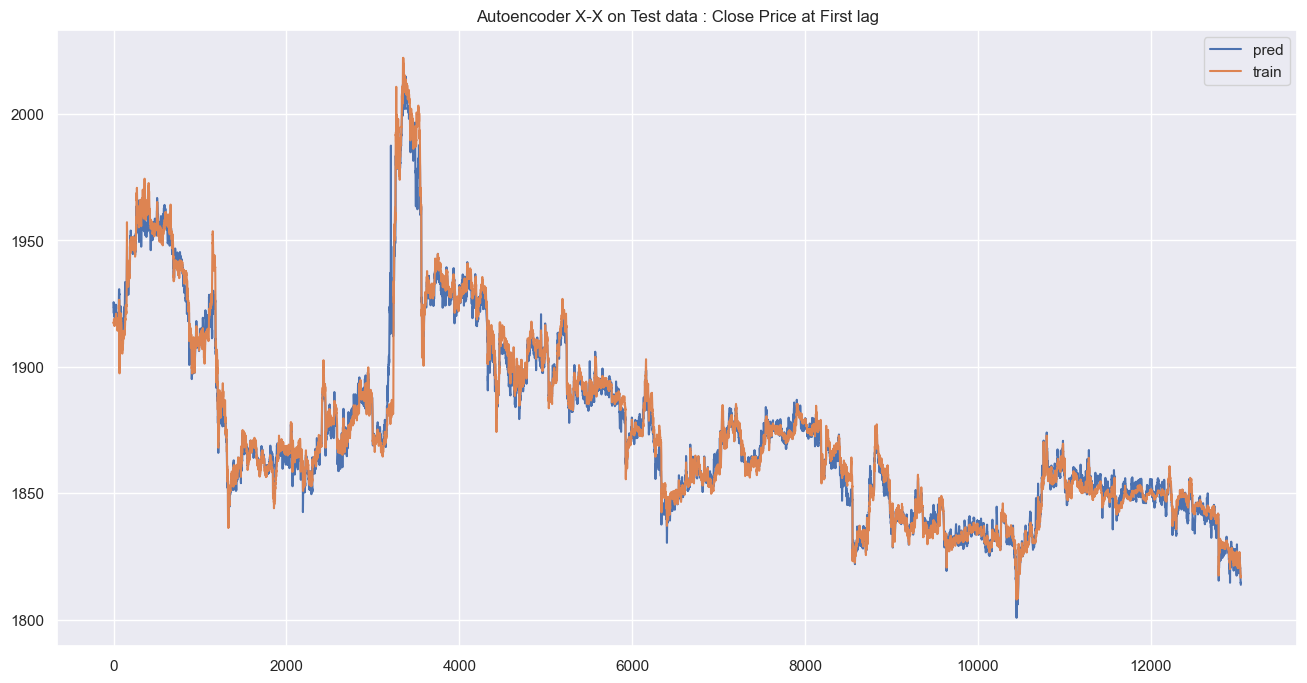

In [111]:
print(X_test_raw[:,0, 0])
print(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0])

fig = plt.figure(figsize=(16, 8))
plt.title("Autoencoder X-X on Test data : Close Price at First lag")
plt.plot(X_test_pred[:,0, 0] * X_test_raw[:,-1, 0], label="pred")
plt.plot(X_test_raw[:,0,0], label="train")
plt.legend(loc='upper right')

In [112]:
X_test_sca.shape

(13044, 72, 102)

In [113]:
mean_absolute_error(X_test_sca[:,0,:], X_test_sca_pred[:,0,:])

0.3740072838416378

In [114]:
print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mae_ae_test = np.mean(np.abs(X_test_sca_pred - X_test_sca), 0)
print(mae_ae_test.shape)
mae_ae_test_feat = np.mean(mae_ae_test, 0)[np.newaxis,:]
print(mae_ae_test_feat.shape)
df_mae_ae_test = pd.DataFrame(mae_ae_test, columns=list_col_select)
df_mae_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mae_ae_test.index))]
df_mae_ae_test_feat = pd.DataFrame(mae_ae_test_feat, columns=list_col_select)
df_mae_ae_test["dataset"] = "TEST"
df_mae_ae_train["dataset"] = "TRAIN"
df_mae_ae_comp = pd.concat([df_mae_ae_train, df_mae_ae_test], ignore_index=False)
df_mae_ae_comp

(13044, 72, 102)
(13044, 72, 102)
(72, 102)
(1, 102)


Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
lag_0    0.230332  0.234434  0.225714  0.228922          0.303582   
lag_1    0.174066  0.173803  0.167160  0.169838          0.259300   
lag_2    0.160084  0.156180  0.151251  0.154749          0.239541   
lag_3    0.145285  0.139152  0.134425  0.139662          0.227009   
lag_4    0.143960  0.136981  0.131898  0.138418          0.218393   
...           ...       ...       ...       ...               ...   
lag_67   0.114321  0.106095  0.123762  0.106912          0.153450   
lag_68   0.114232  0.105996  0.123720  0.106806          0.153523   
lag_69   0.114099  0.105934  0.123655  0.106769          0.153573   
lag_70   0.113933  0.105778  0.123531  0.106540          0.153601   
lag_71   0.113770  0.105716  0.123414  0.106440          0.153635   

        ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  \
lag_0           0.334060        0.246826         0.248012   
lag_1           0.290957        0.193371         0.188916   
lag_2           0.270087        0.172027         0.167299   
lag_3           0.258278        0.157299         0.147537   
lag_4           0.248540        0.153434         0.140523   
...                  ...             ...              ...   
lag_67          0.160051        0.094797         0.096719   
lag_68          0.160135        0.094718         0.096602   
lag_69          0.160219        0.094613         0.096447   
lag_70          0.160268        0.094515         0.096272   
lag_71          0.160325        0.094456         0.096072   

        ichi_cloud_a_day_ETH  ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  \
lag_0               0.287067              0.232724  ...  0.579441  0.604319   
lag_1               0.234613              0.183277  ...  0.429417  0.445139   
lag_2               0.198928              0.149095  ...  0.358796  0.381880   
lag_3               0.181215              0.136584  ...  0.315550  0.344866   
lag_4               0.172918              0.129028  ...  0.286853  0.318722   
...                      ...                   ...  ...       ...       ...   
lag_67              0.225256              0.228895  ...  0.233505  0.241050   
lag_68              0.225198              0.228859  ...  0.233397  0.240912   
lag_69              0.225164              0.228842  ...  0.233383  0.240834   
lag_70              0.225117              0.228790  ...  0.233281  0.240740   
lag_71              0.225091              0.228769  ...  0.233209  0.240671   

        weekday_cos  weekday_sin  day_in_month_cos  day_in_month_sin  \
lag_0      0.572851     0.571192          0.644694          0.554922   
lag_1      0.434583     0.457690          0.488862          0.427535   
lag_2      0.363304     0.404922          0.406138          0.359222   
lag_3      0.325130     0.372151          0.359882          0.322516   
lag_4      0.295985     0.346402          0.328256          0.294901   
...             ...          ...               ...               ...   
lag_67     0.229227     0.446937          1.171851          0.838760   
lag_68     0.229153     0.446657          1.172255          0.838621   
lag_69     0.229017     0.446398          1.172662          0.838513   
lag_70     0.228899     0.446090          1.173091          0.838375   
lag_71     0.228705     0.445800          1.173504          0.838262   

         day_off  event_pred  event_real  dataset  
lag_0   0.327114    0.036874    0.086292    TRAIN  
lag_1   0.259138    0.035594    0.064719    TRAIN  
lag_2   0.190724    0.034546    0.058632    TRAIN  
lag_3   0.145715    0.033801    0.051484    TRAIN  
lag_4   0.123558    0.033796    0.049662    TRAIN  
...          ...         ...         ...      ...  
lag_67  0.110543    0.030538    0.042335     TEST  
lag_68  0.110508    0.030535    0.042289     TEST  
lag_69  0.110484    0.030536    0.042257     TEST  
lag_70  0.110472    0.030528    0.042211     TEST  
lag_71  0.110455    0.030526    0.042143     TEST  

[144 ro

In [115]:
df_mae_ae_test_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.115303  0.107158  0.121056  0.110374           0.14669   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.158935        0.099133         0.099674              0.230983   

   ichi_cloud_b_day_ETH  ...  supply_ETH  hour_cos  hour_sin  weekday_cos  \
0              0.229076  ...    0.390559  0.243117  0.260003     0.247269   

   weekday_sin  day_in_month_cos  day_in_month_sin  day_off  event_pred  \
0     0.449267          1.150437          0.865382  0.11422    0.030238   

   event_real  
0    0.046243  

[1 rows x 102 columns]

Text(0.5, 1.0, 'MAE per feature on TEST')

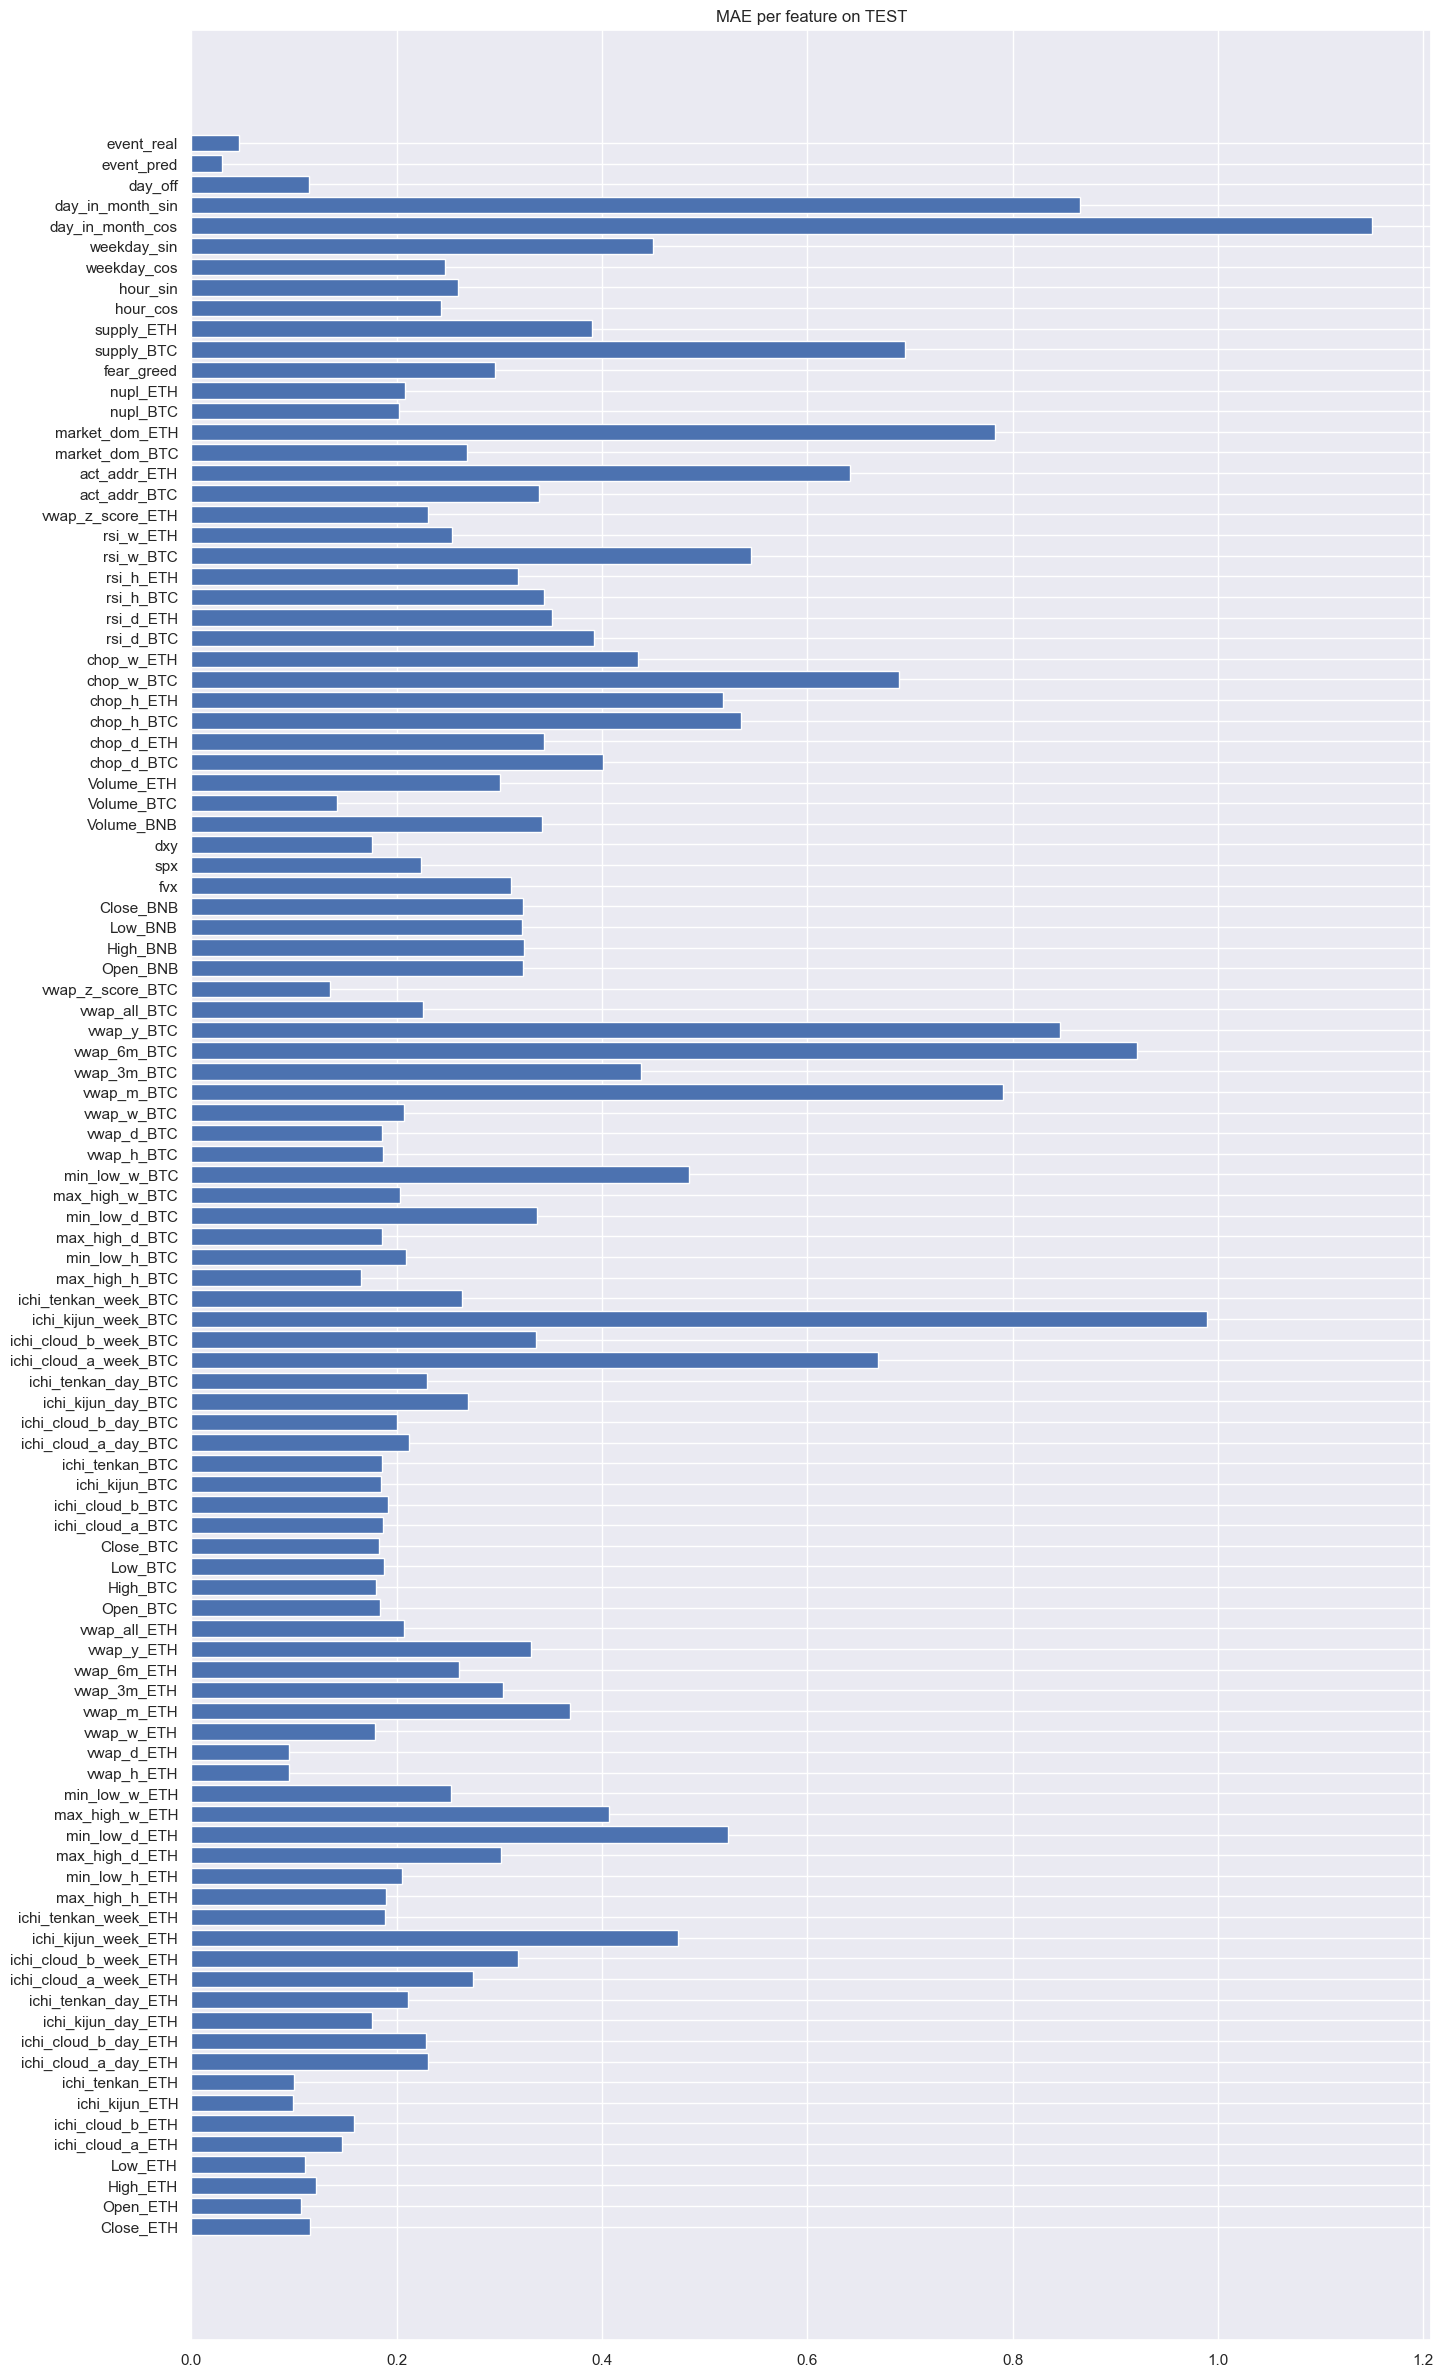

In [116]:
plt.figure(figsize=(16, 30))
plt.barh(df_mae_ae_test_feat.columns, df_mae_ae_test_feat.values[0])
plt.title("MAE per feature on TEST")

In [117]:
df_mae_ae_test_feat.values[0]

array([0.1153026 , 0.10715788, 0.12105558, 0.11037429, 0.14669025,
       0.15893538, 0.09913305, 0.09967407, 0.23098305, 0.22907615,
       0.1763733 , 0.21131346, 0.27403022, 0.31801378, 0.47430573,
       0.18819951, 0.18979036, 0.2053245 , 0.3013723 , 0.52297987,
       0.40662946, 0.25296509, 0.0948989 , 0.09485203, 0.17929087,
       0.36861099, 0.30380692, 0.26086418, 0.33087785, 0.2074761 ,
       0.18419067, 0.17948562, 0.18734925, 0.18287511, 0.18635491,
       0.19167912, 0.18435482, 0.1861653 , 0.21182388, 0.2004821 ,
       0.26990599, 0.22979965, 0.66882045, 0.33568601, 0.98955322,
       0.26365554, 0.16571778, 0.20914635, 0.18599394, 0.33639921,
       0.20338651, 0.48449496, 0.18641556, 0.18562172, 0.20761461,
       0.79074221, 0.43836554, 0.92076316, 0.84576671, 0.2255813 ,
       0.13490801, 0.32265257, 0.32397271, 0.32187117, 0.32315752,
       0.31160106, 0.22345984, 0.17562984, 0.34202975, 0.14143147,
       0.30112691, 0.40078292, 0.34321453, 0.53584   , 0.51790

In [118]:
2/df_mae_ae_test_feat.values[0].sum()

0.06186319258936518

In [119]:
df_comp = df_mae_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MAE")
df_comp

dataset    variable       MAE
0       TRAIN   Close_ETH  0.230332
1       TRAIN   Close_ETH  0.174066
2       TRAIN   Close_ETH  0.160084
3       TRAIN   Close_ETH  0.145285
4       TRAIN   Close_ETH  0.143960
...       ...         ...       ...
14683    TEST  event_real  0.042335
14684    TEST  event_real  0.042289
14685    TEST  event_real  0.042257
14686    TEST  event_real  0.042211
14687    TEST  event_real  0.042143

[14688 rows x 3 columns]

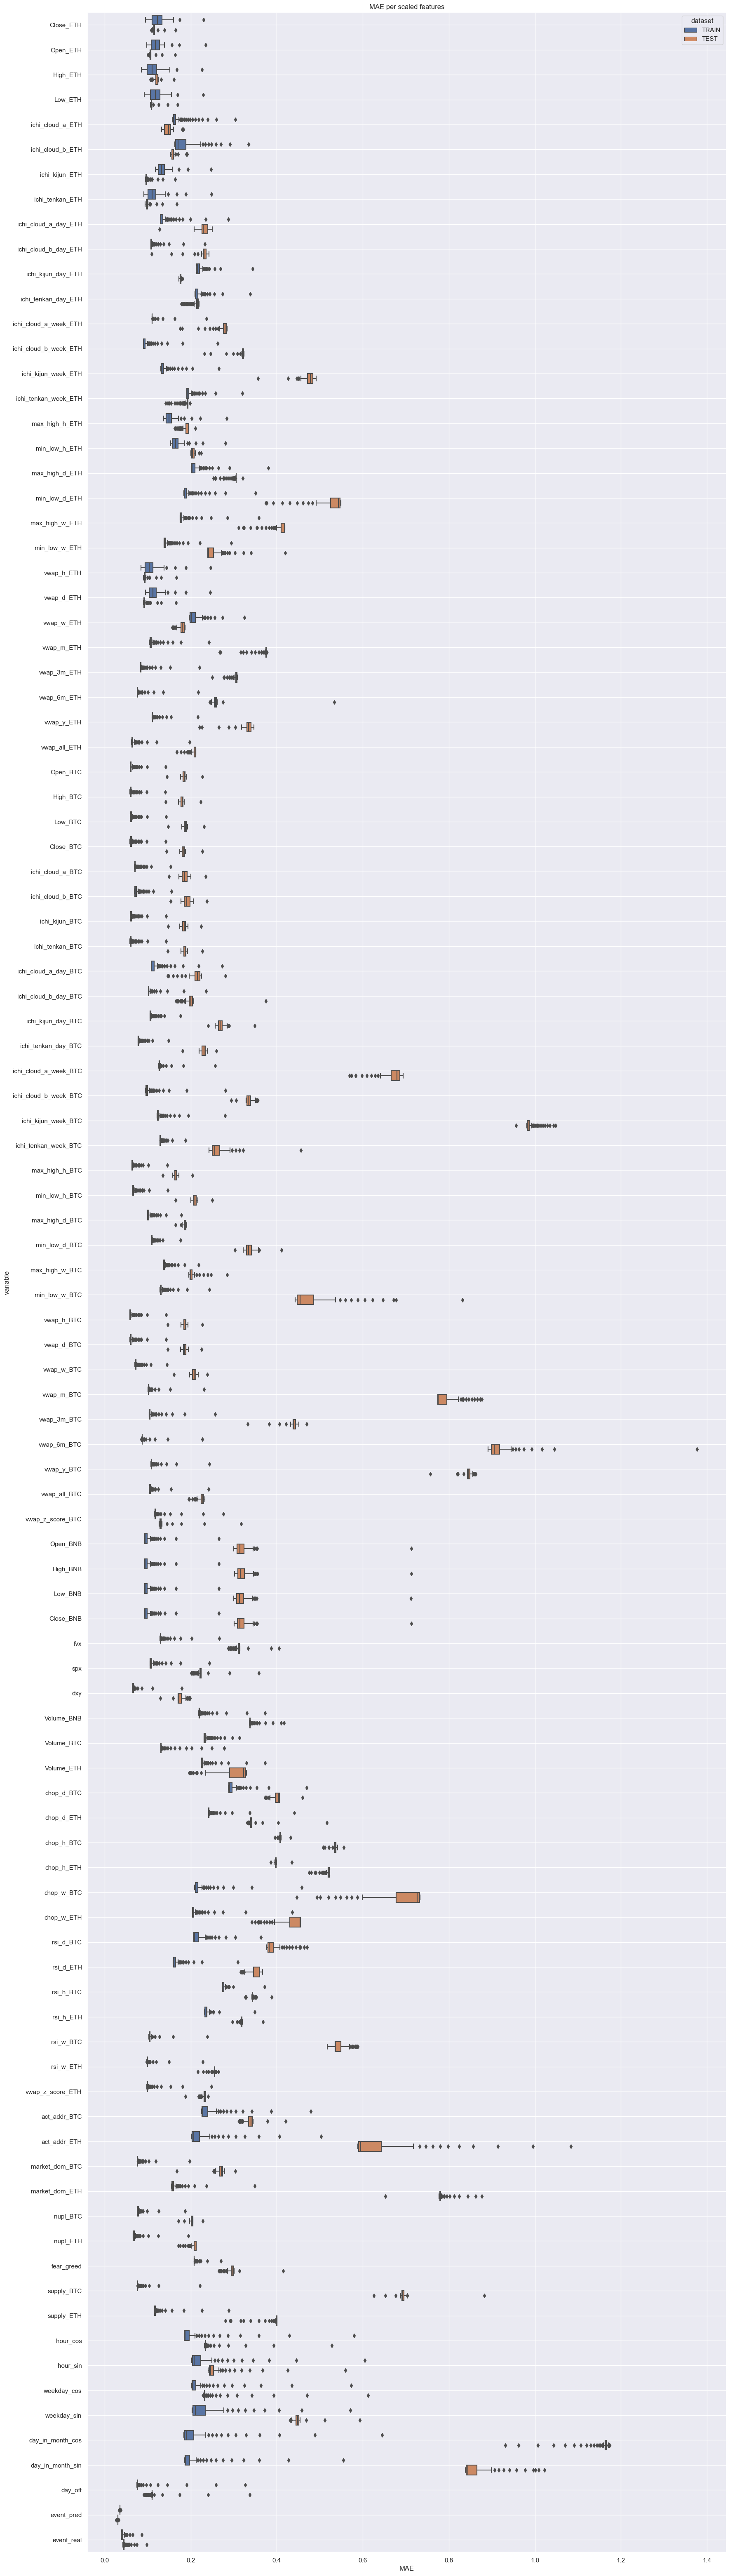

In [120]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_comp, x="MAE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MAE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MAE - {name_plt}.jpg")
)

#### MSE  per features

In [121]:
# values per feat.
print(X_train_sca_pred.shape) 
print(X_train_sca.shape)
mse_ae_train = np.mean(np.square(X_train_sca_pred - X_train_sca), 0)
print(mse_ae_train.shape)
df_mse_ae_train = pd.DataFrame(mse_ae_train, columns=list_col_select)
df_mse_ae_train.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_train.index))]

print(X_test_sca_pred.shape) 
print(X_test_sca.shape)
mse_ae_test = np.mean(np.square(X_test_sca_pred - X_test_sca), 0)
print(mse_ae_test.shape)
df_mse_ae_test = pd.DataFrame(mse_ae_test, columns=list_col_select)
df_mse_ae_test.index = [f"lag_{i_lag}" for i_lag in range(len(df_mse_ae_test.index))]

# mean per feat.
mse_ae_train_feat = np.mean(mse_ae_train, 0)[np.newaxis,:]
print(mse_ae_train_feat.shape)
df_mse_ae_train_feat = pd.DataFrame(mse_ae_train_feat, columns=list_col_select)

mse_ae_test_feat = np.mean(mse_ae_test, 0)[np.newaxis,:]
print(mse_ae_test_feat.shape)
df_mse_ae_test_feat = pd.DataFrame(mse_ae_test_feat, columns=list_col_select)

# comp train/test
df_mse_ae_test["dataset"] = "TEST"
df_mse_ae_train["dataset"] = "TRAIN"
df_mse_ae_comp = pd.concat([df_mse_ae_train, df_mse_ae_test], ignore_index=False)

df_mse_ae_test_feat["dataset"] = "TEST"
df_mse_ae_train_feat["dataset"] = "TRAIN"
df_mse_ae_comp_feat = pd.concat([df_mse_ae_train_feat, df_mse_ae_test_feat], ignore_index=False)

df_mse_ae_comp = df_mse_ae_comp.melt(id_vars=["dataset"], value_vars=list_col_select, value_name="MSE")



(52444, 72, 102)
(52444, 72, 102)
(72, 102)
(13044, 72, 102)
(13044, 72, 102)
(72, 102)
(1, 102)
(1, 102)


In [122]:
df_mse_ae_comp_feat

Close_ETH  Open_ETH  High_ETH   Low_ETH  ichi_cloud_a_ETH  \
0   0.034261  0.032866  0.028208  0.032137          0.116616   
0   0.022271  0.019453  0.024104  0.020625          0.037589   

   ichi_cloud_b_ETH  ichi_kijun_ETH  ichi_tenkan_ETH  ichi_cloud_a_day_ETH  \
0          0.114381        0.039616         0.029008              0.034680   
0          0.042402        0.017517         0.016821              0.072466   

   ichi_cloud_b_day_ETH  ...  hour_cos  hour_sin  weekday_cos  weekday_sin  \
0              0.024101  ...  0.064519  0.077316     0.075016     0.085858   
0              0.069530  ...  0.090459  0.097949     0.089297     0.289315   

   day_in_month_cos  day_in_month_sin   day_off  event_pred  event_real  \
0          0.080272          0.069217  0.053672    0.997363    0.990508   
0          1.986957          0.923672  0.092688    0.926417    1.595880   

   dataset  
0    TRAIN  
0     TEST  

[2 rows x 103 columns]

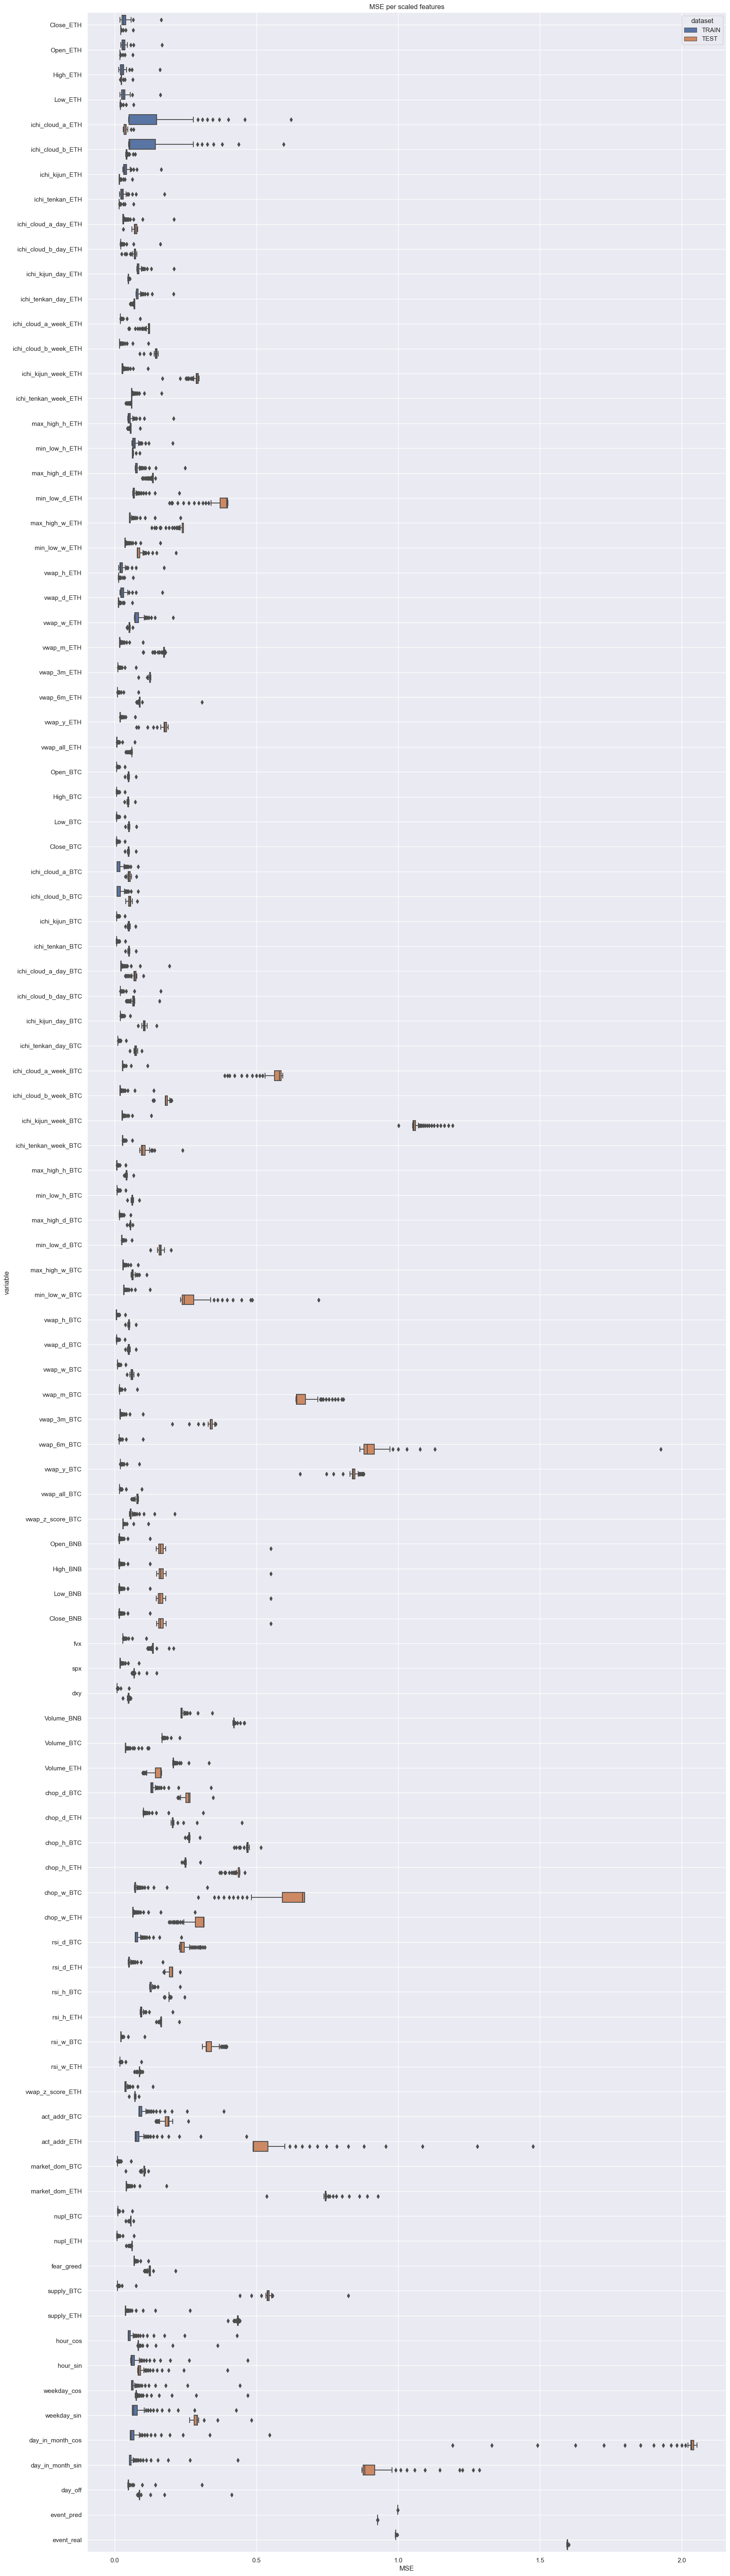

In [123]:
plt.figure(figsize=(20, 80))
sns.boxplot(data=df_mse_ae_comp, x="MSE", y="variable" , hue="dataset")
fig = plt.gcf()
ax = fig.gca()
ax.yaxis.grid(True)
#ax.set_xlim([-30,30])
plt.title("MSE per scaled features")

name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE_MSE - {name_plt}.jpg")
)

Text(0.5, 1.0, 'MSE per feature on TRAIN')

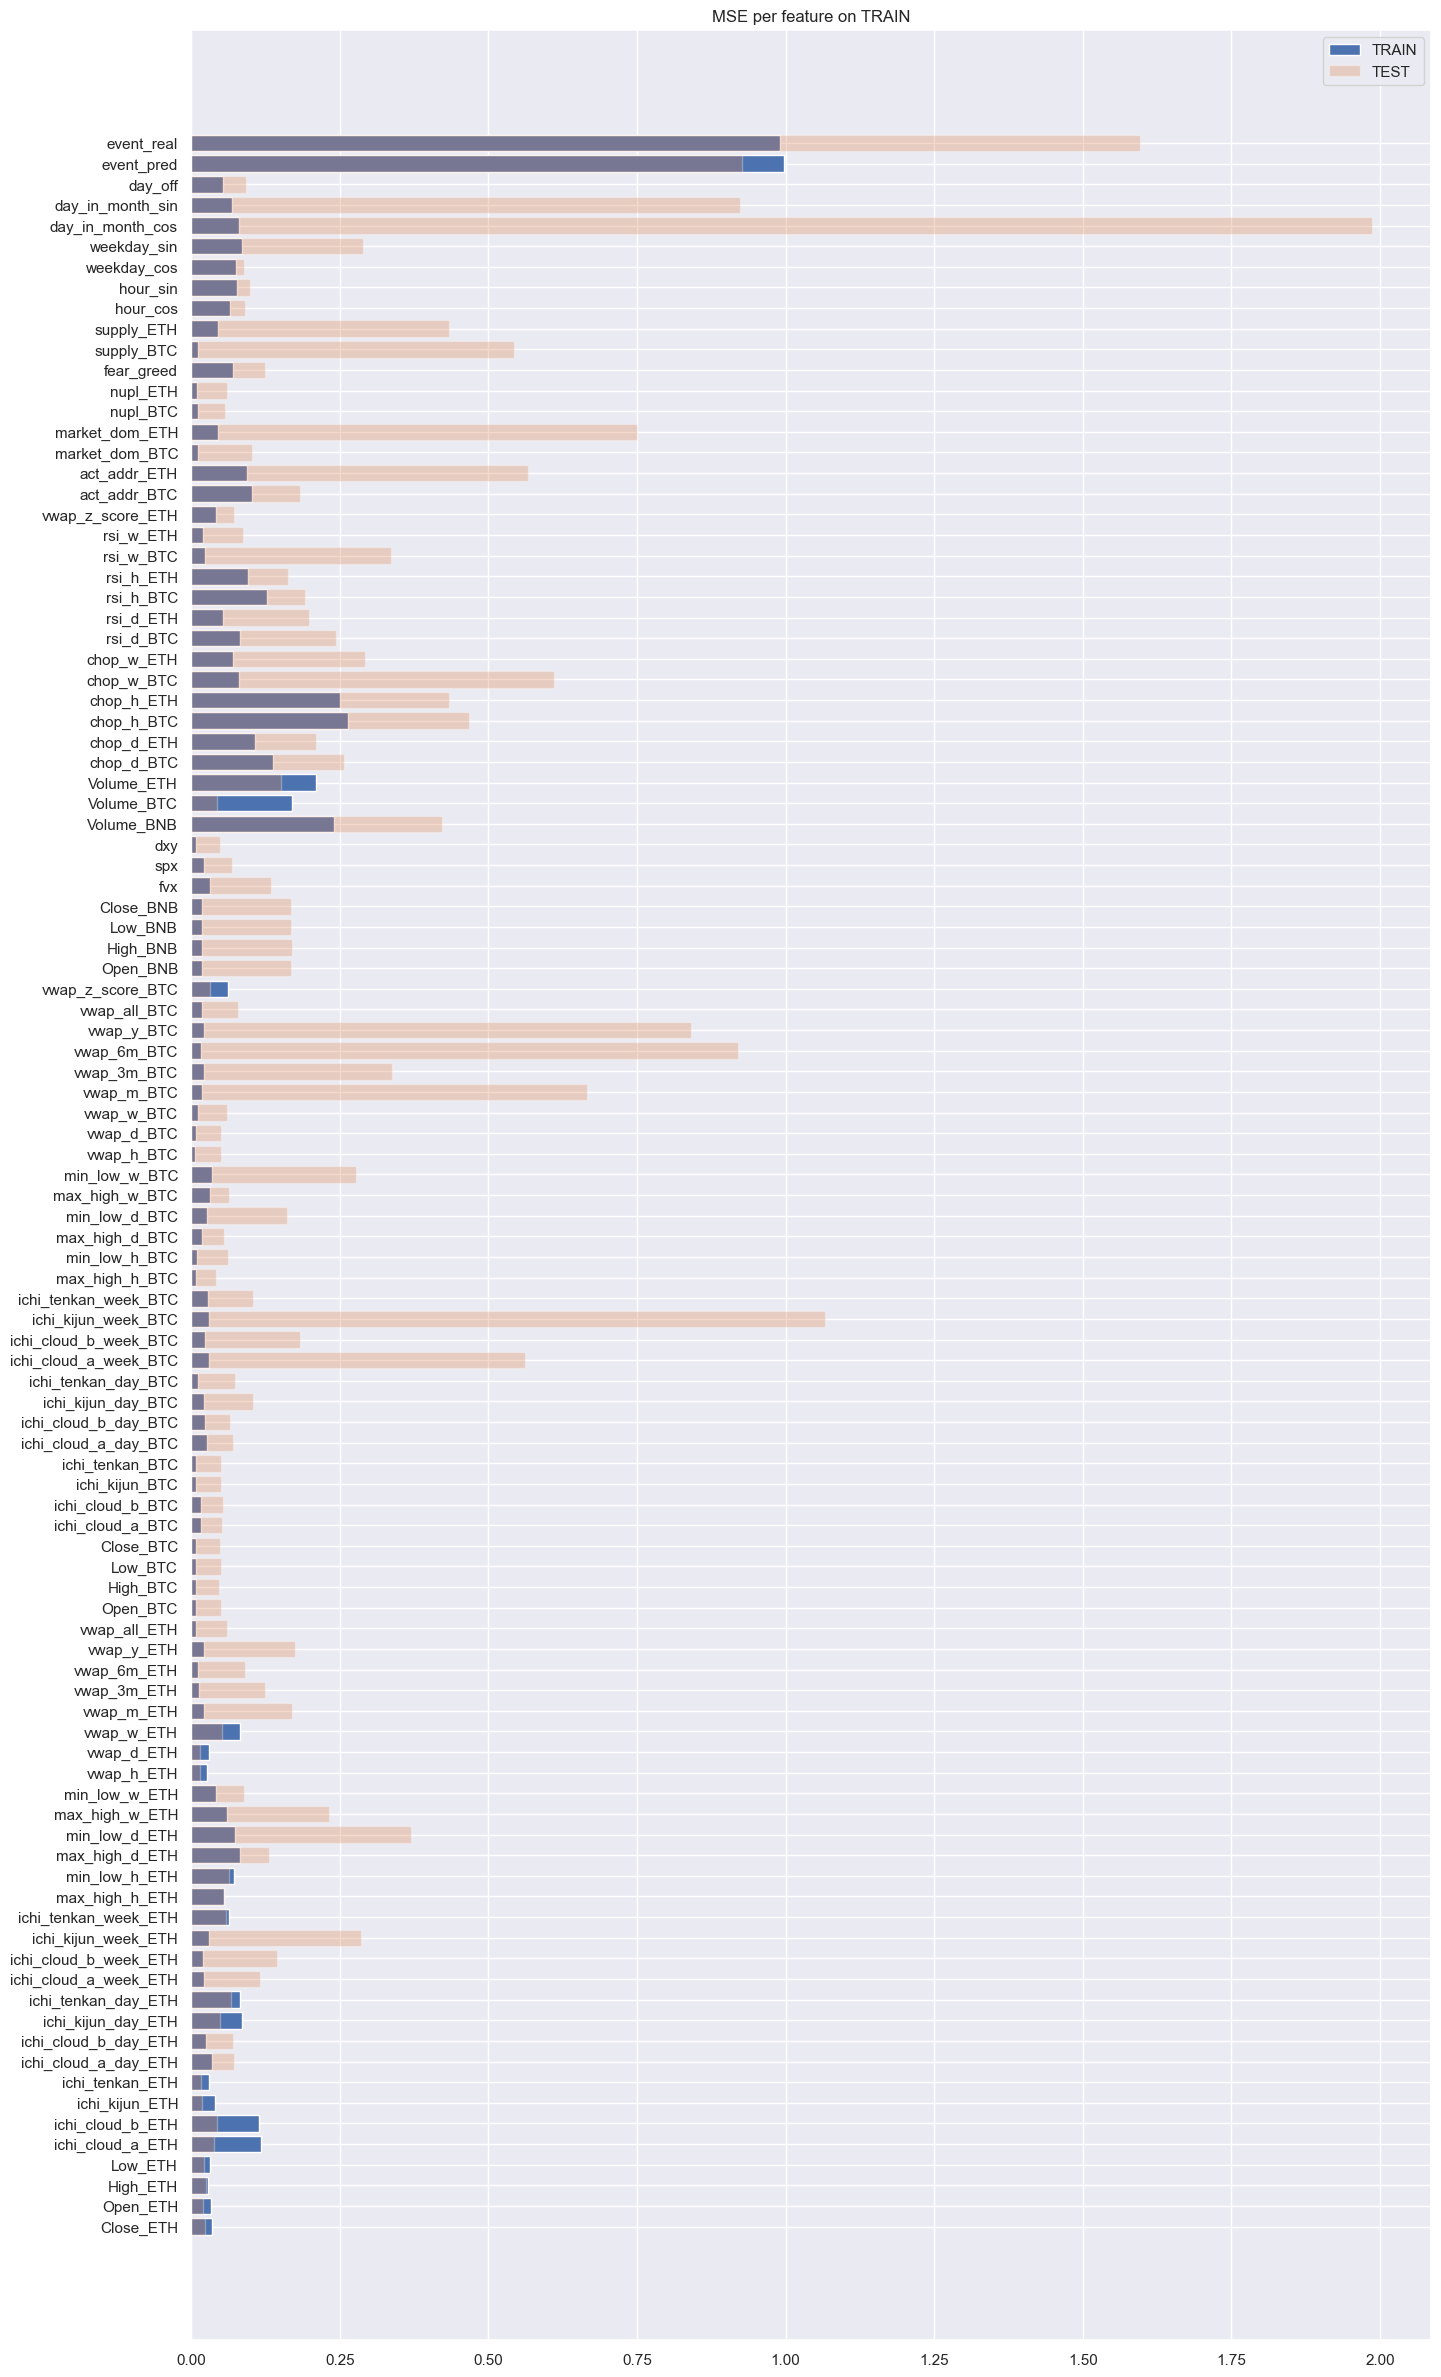

In [124]:
plt.figure(figsize=(16, 30))
plt.barh(list_col_select, df_mse_ae_train_feat.values[0,:-1], label="TRAIN")
plt.barh(list_col_select, df_mse_ae_test_feat.values[0,:-1], label="TEST", alpha=0.3)
plt.legend(loc='upper right')
#plt.barh(df_mse_ae_test_feat.columns, df_mse_ae_test_feat.values[0])
plt.title("MSE per feature on TRAIN")

In [125]:
encoder_model.layers[3].get_weights()

[array([[ 0.02182938, -0.09528786, -0.09147924, ..., -0.34689552,
          0.19291495,  0.4757567 ],
        [ 0.02232264,  0.03850359, -0.09623238, ..., -0.12217505,
         -0.038457  ,  0.22348209],
        [-0.08842385,  0.04371733, -0.6288176 , ...,  0.09193053,
          0.05969083, -0.16067399],
        ...,
        [-0.12482602, -0.2083723 ,  0.37110373, ..., -0.08544143,
          0.4130468 , -0.00161872],
        [ 0.08188225, -0.14513224, -0.15554987, ..., -0.08995036,
         -0.03502745,  0.24004102],
        [ 0.27375525, -0.05496555, -0.35563508, ...,  0.09179549,
          0.45449668, -0.2593887 ]], dtype=float32),
 array([ 0.17358558,  0.5915342 , -0.0919276 , -0.18060713,  0.180957  ,
         0.18204626,  0.5038824 , -0.1341259 ,  0.40375352, -0.21175836,
        -0.11680941, -0.5617096 ,  0.1231785 , -0.24076416,  0.22389746,
         0.2644809 ], dtype=float32)]

## Prediction Models

### LSTM all features

In [126]:
X_train_sca.shape

(52444, 72, 102)

In [127]:
X_train_sca.shape[-1]

102

In [128]:
X_train_sca.shape[-2:]

(72, 102)

In [129]:
# Init
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
if MODE_TRAIN_LSTM:
    EPOCHS = 5
    patience = 0
    dropout_rate = 0.05
    n_units = 128
    seed = 0
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # optimizer def 
    optim = tf.optimizers.Adam()

    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                    verbose=1, patience=patience,
                                    restore_best_weights=True)
    # create model
    multi_step_model_1 = tf.keras.models.Sequential()
    multi_step_model_1.add(tf.keras.layers.LSTM(n_units, 
                        return_sequences=False,
                        input_shape=X_train_sca.shape[-2:],
                        dropout=dropout_rate))
    multi_step_model_1.add(tf.keras.layers.LayerNormalization())
    multi_step_model_1.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
    # compile
    multi_step_model_1.compile(optimizer=optim, loss='mse')
    # fitting
    if patience == 0:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1
        )
    else:
        multi_step_history_1 = multi_step_model_1.fit(
            X_train_sca, y_train_sca, epochs=EPOCHS, 
            batch_size=BATCH_SIZE, 
            validation_data=(X_test_sca,y_test_sca), verbose=1, callbacks=[es])

    # eval
    mse_curr_1 = np.min(multi_step_history_1.history['val_loss'])
    print("mse_curr_1 = ", mse_curr_1)
    # plot mse
    plot_train_history(multi_step_history_1,
                        'Multi Step Training and validation loss', "data")
    # save mdl
    multi_step_model_1.save(path_mdl_predict_lstm)
    # results
    # _train_sca -> unscaler -> _train -> multiply by  Close price last lag
    y_train_pred_1 = multi_step_model_1.predict(X_train_sca)
    y_train_pred_unscaled_1 = scaler_y.inverse_transform(y_train_pred_1.reshape(-1,y_train_pred_1.shape[-1])).reshape(y_train_pred_1.shape)
    y_train_pred_raw_1 = y_train_pred_unscaled_1 * X_train_raw[:,-1, 0][:, np.newaxis]

    y_test_pred_1 = multi_step_model_1.predict(X_test_sca)
    y_test_pred_unscaled_1 = scaler_y.inverse_transform(y_test_pred_1.reshape(-1,y_test_pred_1.shape[-1])).reshape(y_test_pred_1.shape)
    y_test_pred_raw_1 = y_test_pred_unscaled_1 * X_test_raw[:,-1, 0][:, np.newaxis]
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TRAIN data : Close Price at 6th lag")
    plt.plot(y_train_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_train_raw[:1000, 5], label="TRAIN")
    plt.legend(loc='upper right')
    # plot predict TRAIN
    fig = plt.figure(figsize=(16, 8))
    plt.title("LSTM Prediction on TEST data : Close Price at 6th lag")
    plt.plot(y_test_pred_raw_1[:1000, 5], label="pred")
    plt.plot(y_test_raw[:1000, 5], label="TEST")
    plt.legend(loc='upper right')


### Autoencoder + LSTM reduced features

In [130]:
encoder_model = tf.keras.models.load_model(path_mdl_encoder)
encoder_model.layers

Concatenate 

In [131]:
X_train_encoded = encoder_model.predict(X_train_sca)
X_train_encoded.shape

1639/1639 [==============================] - 18s 11ms/step


(52444, 72, 16)

In [132]:
X_test_encoded = encoder_model.predict(X_test_sca)
X_test_encoded.shape

408/408 [==============================] - 4s 11ms/step


(13044, 72, 16)

In [133]:
if MODE_TRAIN_AE:
    scaler_enc = StandardScaler()
    X_train_encoded_sca = scaler_enc.fit_transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)

    joblib.dump(scaler_enc, path_scaler_enc)
    
else:
    print("reloading scaler_enc...")
    scaler_enc = joblib.load(path_scaler_enc)
    X_train_encoded_sca = scaler_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)

    X_test_encoded_sca = scaler_enc.transform(
        X_test_encoded.reshape(
            -1, 
            X_test_encoded.shape[-1]
        )
    ).reshape(X_test_encoded.shape)    



reloading scaler_enc...


In [134]:
"""path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")
joblib.dump(scaler_enc, path_scaler_enc)
sc_enc = joblib.load(path_scaler_enc)
sc_enc.transform(
        X_train_encoded.reshape(
            -1, 
            X_train_encoded.shape[-1]
        )
    ).reshape(X_train_encoded.shape)"""

'path_scaler_enc = os.path.join(path_data, "scaler_enc.bin")\njoblib.dump(scaler_enc, path_scaler_enc)\nsc_enc = joblib.load(path_scaler_enc)\nsc_enc.transform(\n        X_train_encoded.reshape(\n            -1, \n            X_train_encoded.shape[-1]\n        )\n    ).reshape(X_train_encoded.shape)'

In [135]:
"""# scale encoded data
scaler_enc = StandardScaler()
X_train_encoded_sca = scaler_enc.fit_transform(
    X_train_encoded.reshape(
        -1, 
        X_train_encoded.shape[-1]
    )
).reshape(X_train_encoded.shape)

X_test_encoded_sca = scaler_enc.transform(
    X_test_encoded.reshape(
        -1, 
        X_test_encoded.shape[-1]
    )
).reshape(X_test_encoded.shape)"""

'# scale encoded data\nscaler_enc = StandardScaler()\nX_train_encoded_sca = scaler_enc.fit_transform(\n    X_train_encoded.reshape(\n        -1, \n        X_train_encoded.shape[-1]\n    )\n).reshape(X_train_encoded.shape)\n\nX_test_encoded_sca = scaler_enc.transform(\n    X_test_encoded.reshape(\n        -1, \n        X_test_encoded.shape[-1]\n    )\n).reshape(X_test_encoded.shape)'

In [136]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
X_train_ = np.concatenate([X_train_sca[:,:,0:4], X_train_encoded_sca], axis=-1)
X_test_ = np.concatenate([X_test_sca[:,:,0:4], X_test_encoded_sca], axis=-1)

X_train_.shape, X_test_.shape

((52444, 72, 20), (13044, 72, 20))

#### Correlations

In [137]:
list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

list_corr = []
for i_lag in range(X_train_.shape[1]):

    df = pd.DataFrame(np.hstack((X_train_[:,i_lag,:], y_train)), 
        columns=list_col_corr)
    # Calculer la matrice de corrélation
    corr_matrix = df.corr()
    if len(list_corr) > 0:
        corr_matrix_min = list_corr[-1].combine(corr_matrix, np.minimum)
        corr_matrix_max = list_corr[-1].combine(corr_matrix, np.maximum)
    
    list_corr.append(corr_matrix)



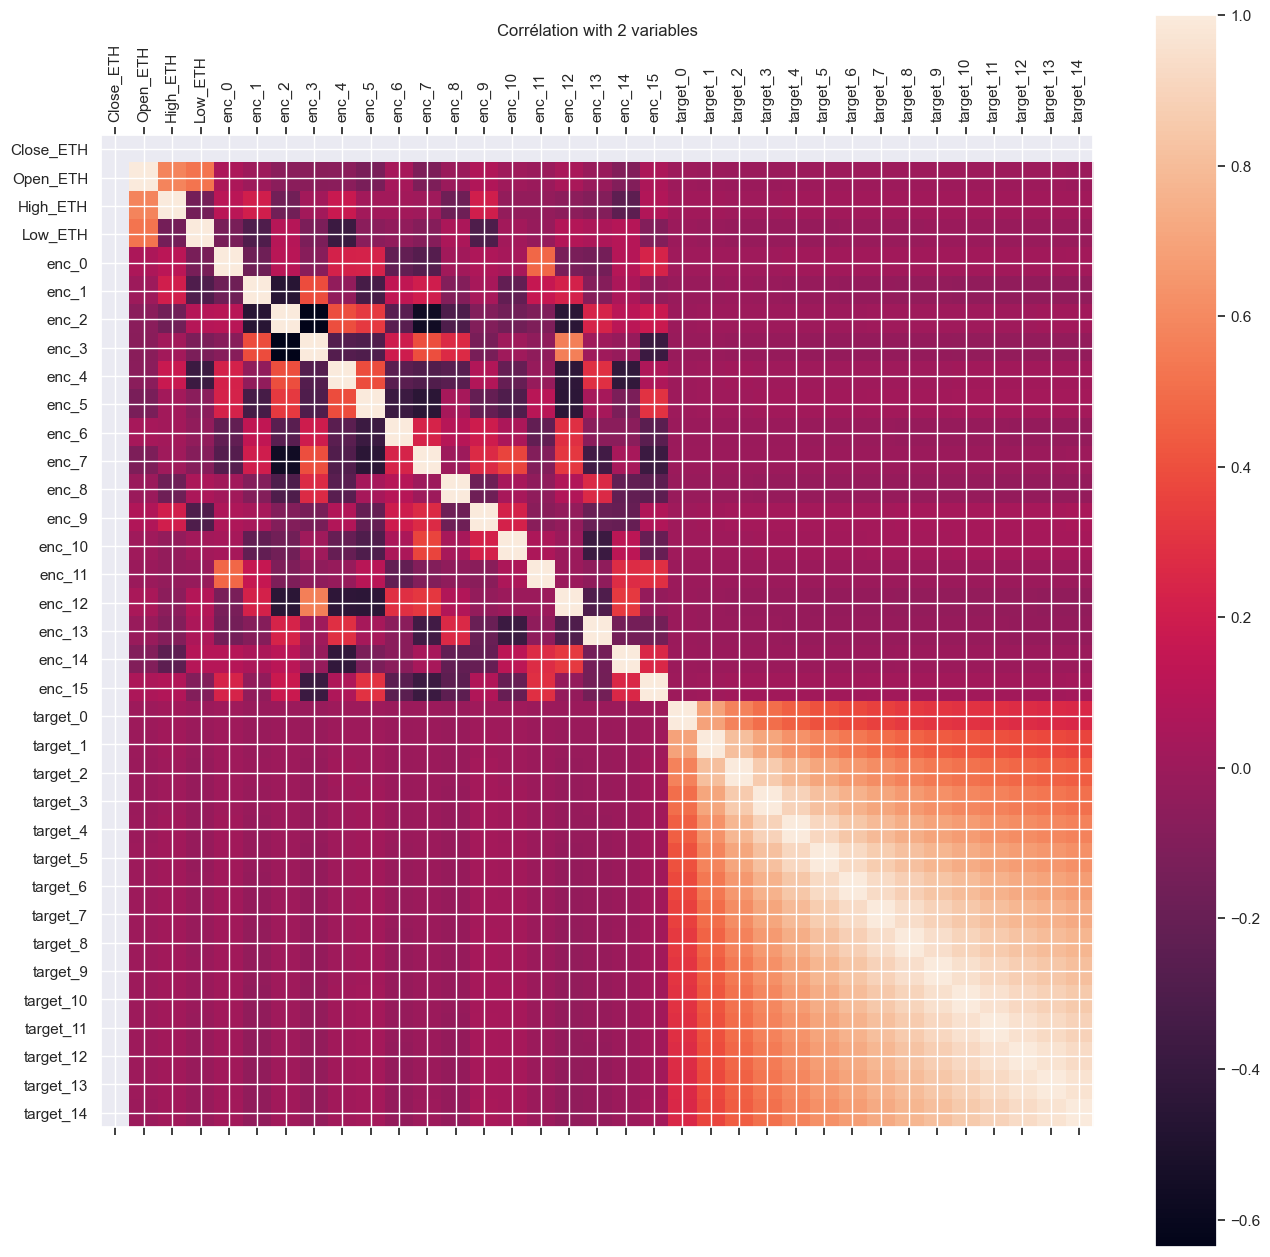

In [138]:
fig = plot_corr(corr_matrix_min)

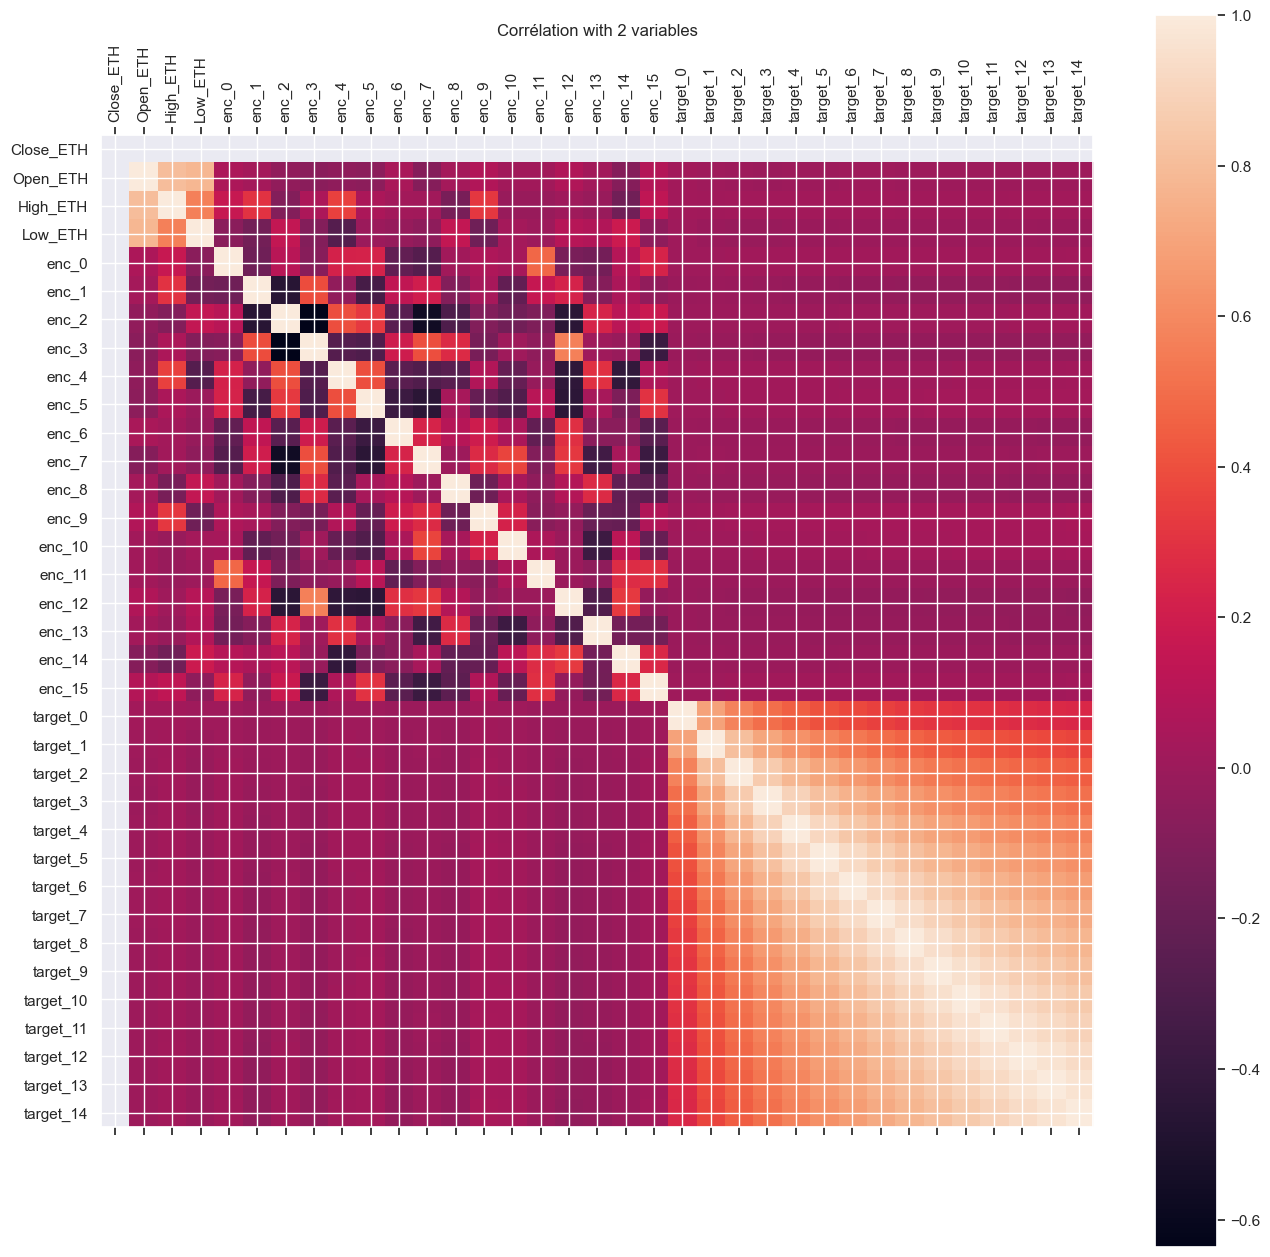

In [139]:
fig = plot_corr(corr_matrix_max) 

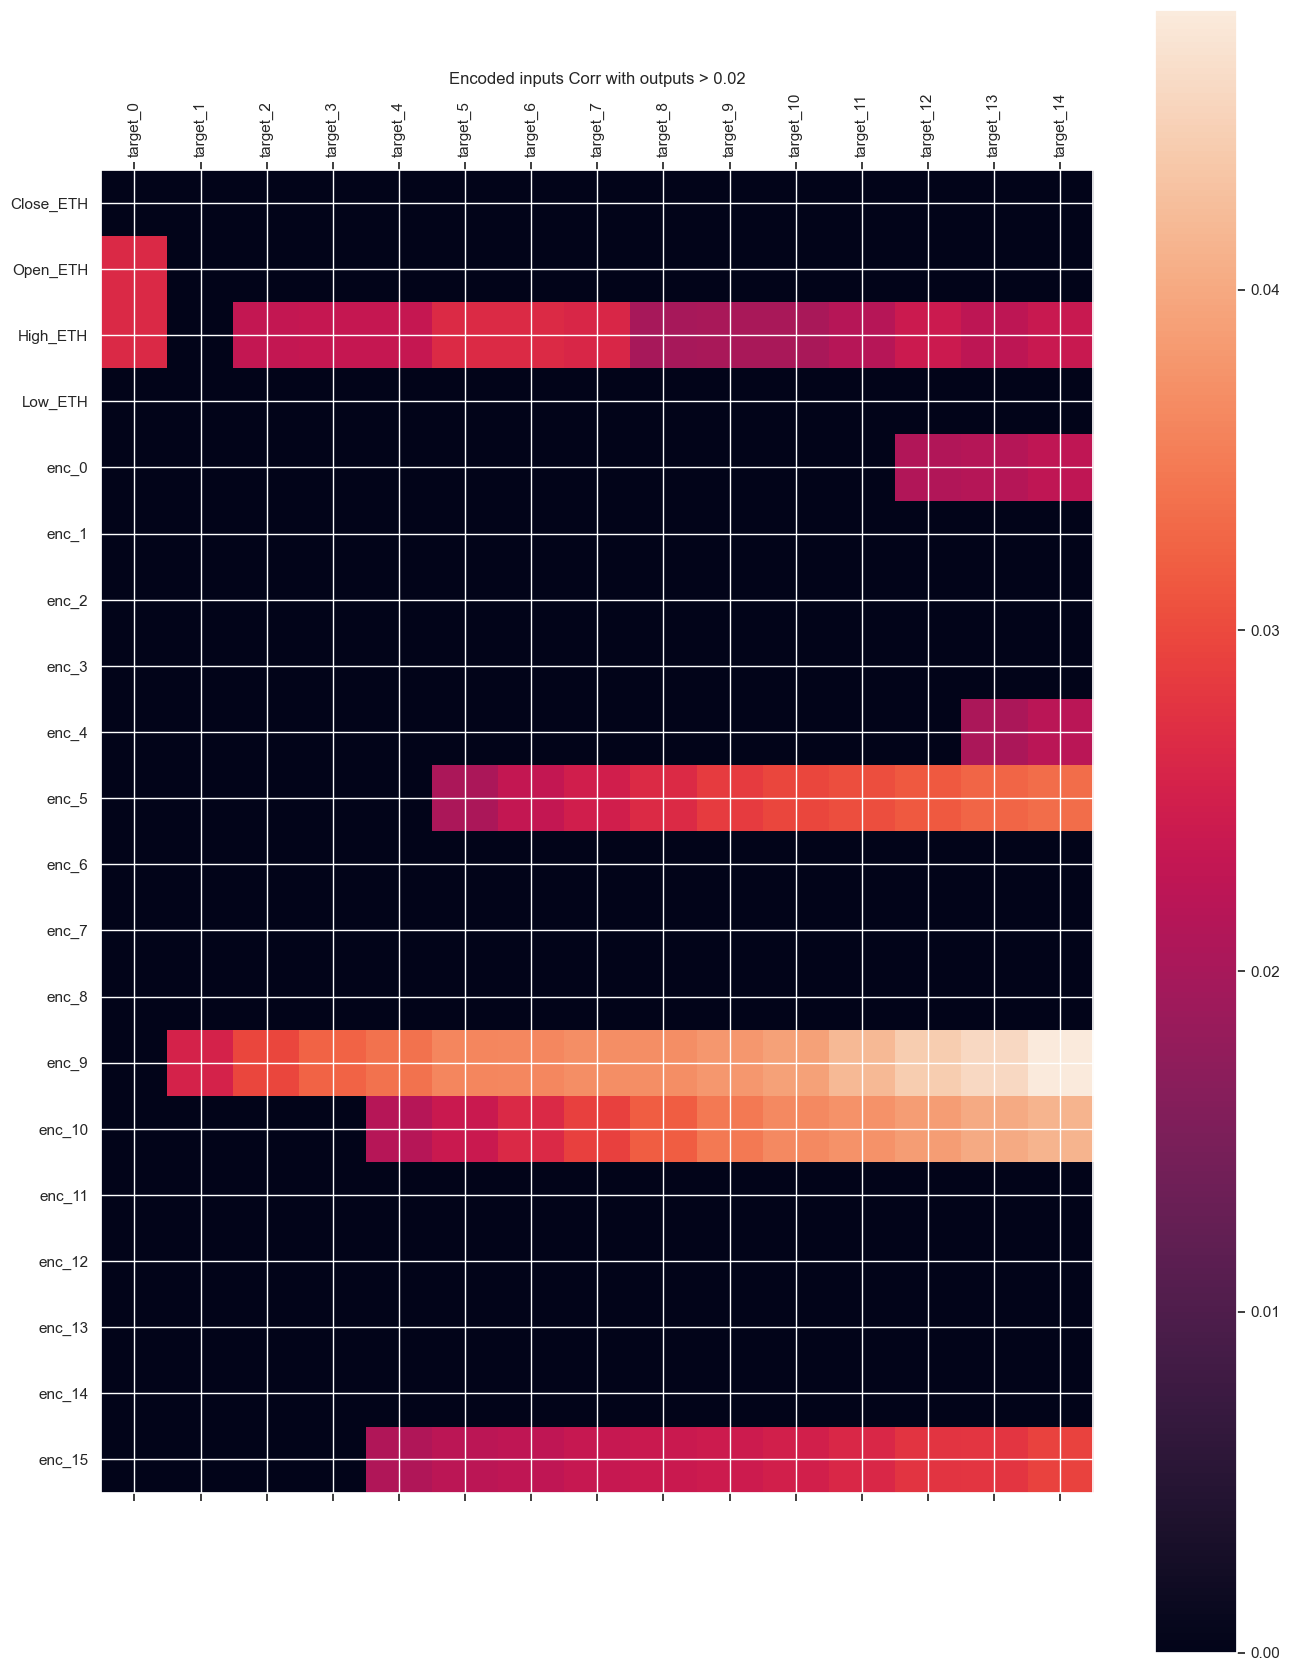

In [140]:
corr_matrix_targets_max = corr_matrix_max.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_max.where(corr_matrix_targets_max>0.02, 0), "Encoded inputs Corr with outputs > 0.02")

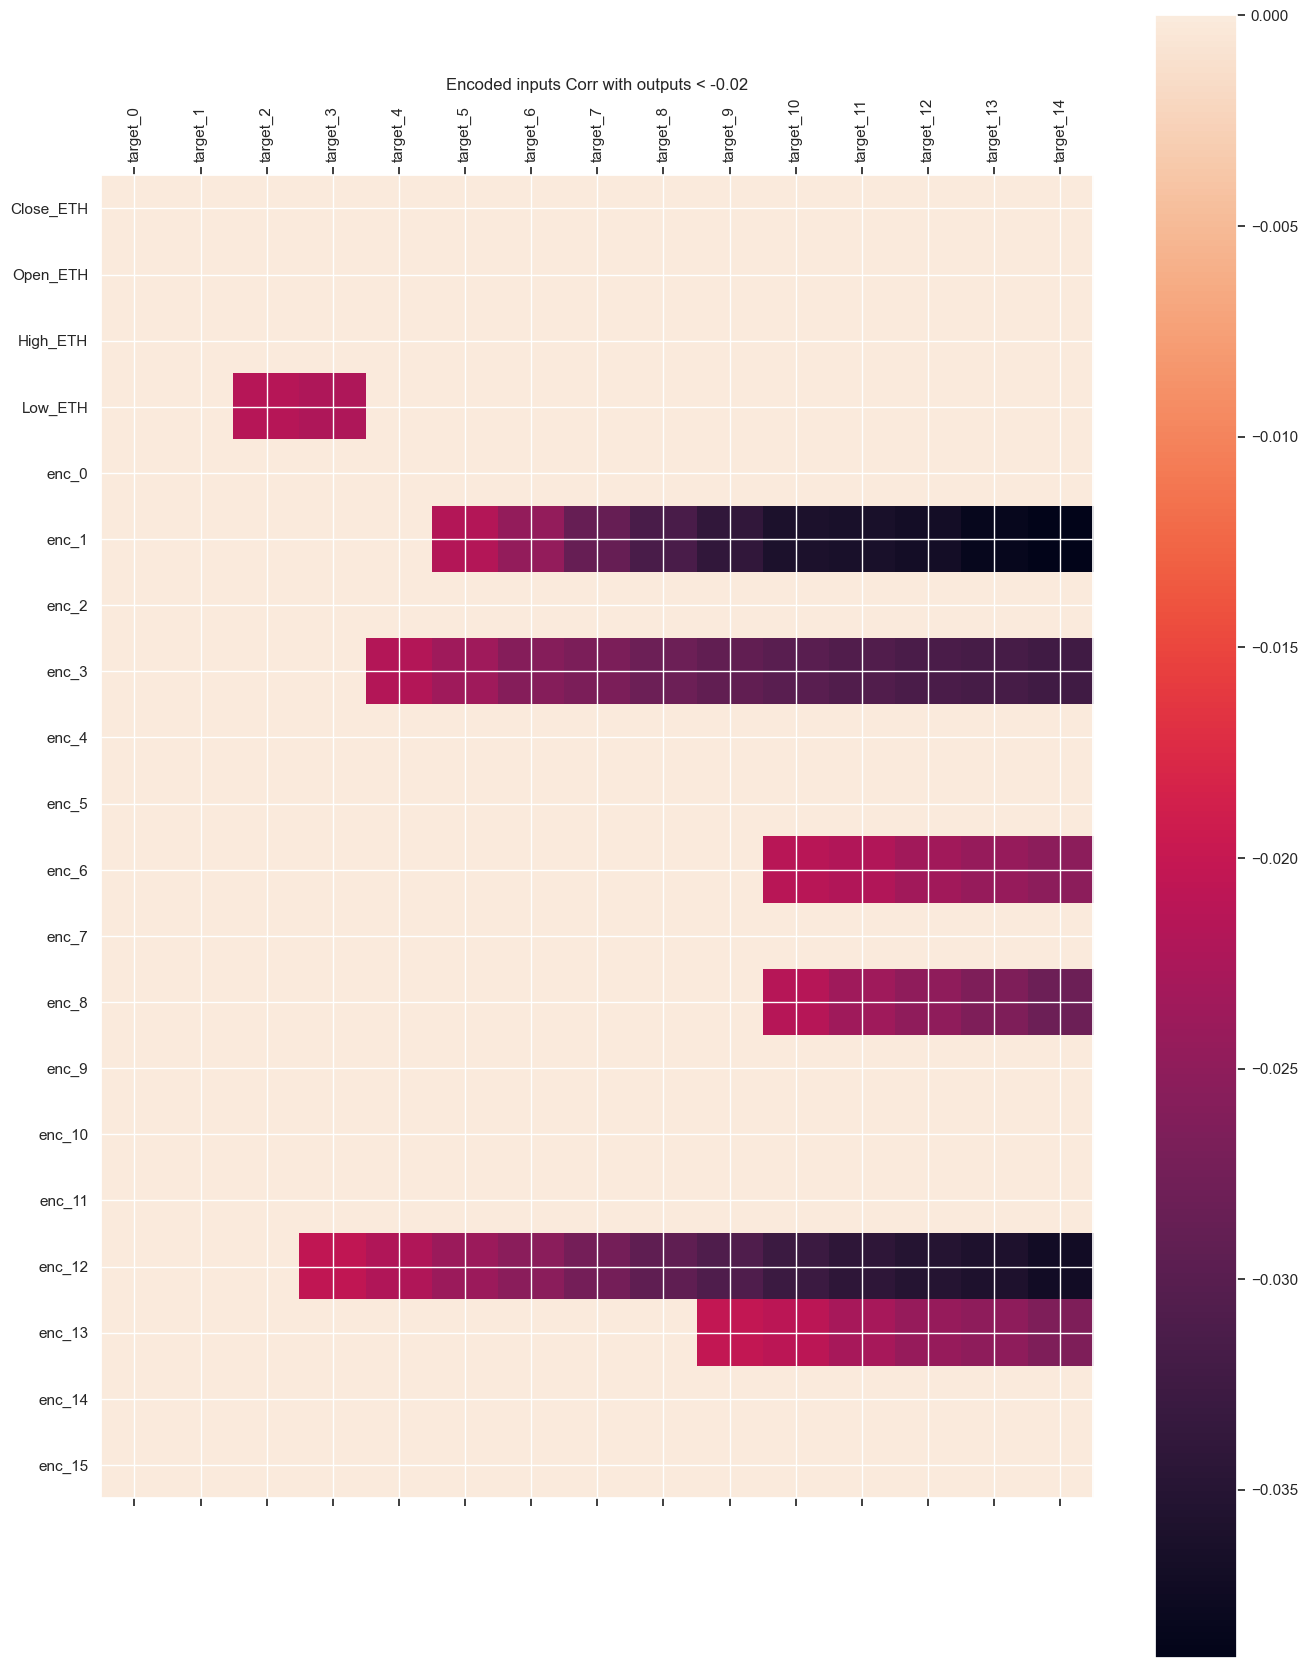

In [141]:
corr_matrix_targets_min = corr_matrix_min.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets_min.where(corr_matrix_targets_min < -0.02, 0), "Encoded inputs Corr with outputs < -0.02")

In [142]:
"""list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]
list_col_ae = list_col_select[:4] + list_col_enc
nb_plot = len(list_col_ae)
list_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]
list_col_corr = list_col_ae + list_col_targets

# Créer un DataFrame pandas à partir des données d'entrée X et de la variable à prédire y
#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), 
#    columns=list_col_select[:nb_plot] + ['target'])
df = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), 
    columns=list_col_corr)
# Calculer la matrice de corrélation
corr_matrix = df.corr()

fig = plot_corr(corr_matrix)"""

'list_col_enc =  [f"enc_{i_enc}" for i_enc in range(encoding_dim)]\nlist_col_ae = list_col_select[:4] + list_col_enc\nnb_plot = len(list_col_ae)\nlist_col_targets = [ f"target_{n_t}" for n_t in range(FUTURE_TARGET)]\nlist_col_corr = list_col_ae + list_col_targets\n\n# Créer un DataFrame pandas à partir des données d\'entrée X et de la variable à prédire y\n#df = pd.DataFrame(np.hstack((X_train[:,-1,:nb_plot], y_train[:,0][:, np.newaxis])), \n#    columns=list_col_select[:nb_plot] + [\'target\'])\ndf = pd.DataFrame(np.hstack((X_train_[:,-1,:], y_train)), \n    columns=list_col_corr)\n# Calculer la matrice de corrélation\ncorr_matrix = df.corr()\n\nfig = plot_corr(corr_matrix)'

In [143]:
"""corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]
fig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")"""


'corr_matrix_targets = corr_matrix.copy().loc[list_col_ae, list_col_targets]\nfig = plot_corr(corr_matrix_targets.where(corr_matrix_targets>0.02, 0), "Encoded inputs Corr with outputs > 0.02")'

In [144]:
"""fig = plot_corr(
    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),
    "Encoded inputs Corr with outputs < -0.02",
)"""

'fig = plot_corr(\n    corr_matrix_targets.where(corr_matrix_targets<-0.02, 0),\n    "Encoded inputs Corr with outputs < -0.02",\n)'

#### Auto select features 

In [145]:
MODE_AUTO_SELECT

2

In [146]:
# select corr var [1, 2, 5, 7, 10, 11, 16, 19, 23, 24, 27, 28, 31]
def unique_list(list1):
    x = np.array(list1)
    return list(np.unique(x))

if MODE_AUTO_SELECT == 1:
    #list_col_enc_select = []
    list_i_enc_select = []
    for i_enc , col_enc in enumerate(list_col_enc):
        if (np.any(corr_matrix_targets_min.loc[col_enc].values <  -0.02) |
            np.any(corr_matrix_targets_max.loc[col_enc].values >  0.02)
            ):
            #list_col_enc_select.append(col_enc)
            list_i_enc_select.append(i_enc)
    list_i_enc_select = unique_list(list_i_enc_select)
    # save list
    save_list(list_i_enc_select, path_save_auto_select)

elif MODE_AUTO_SELECT == 2:
    list_i_enc_select = load_list(path_save_auto_select)
else:
    list_i_enc_select = list(range(X_train_encoded_sca.shape[-1]))


print(list_i_enc_select)
print("nb encoded features: ", len(list_i_enc_select))

[0, 1, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15]
nb encoded features:  12


In [147]:
X_train_.shape

(52444, 72, 20)

In [148]:
np.array(list(range(4)) + list(4+ np.array(list_i_enc_select)))

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14, 16, 17, 19])

In [149]:
X_train_ = X_train_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]
X_test_ = X_test_[:,:, np.array(list(range(4)) + list(4 + np.array(list_i_enc_select)))]

In [150]:
X_train_.shape

(52444, 72, 16)

#### Train

In [151]:
#NB_TRY = 50
#STEPS_PER_EPOCH = math.ceil(BUFFER_SIZE / BATCH_SIZE)
EPOCHS = 20#30
patience = 0#10
#dropout_rate = 0.25#0.1
#n_units = 128#32
#reg = L1L2(l1=0.0001, l2=0.0001)
seed = 1
mse_curr_min = None
if MODE_TRAIN_PREDICTOR:
    for n_units in [128]: #[32, 64, 128]: #[128]: #
        for dropout_rate in  [0.15]: #[0.05, 0.15, 0.25]: #[0.1]:

            tf.keras.backend.clear_session()
            np.random.seed(seed)
            random.seed(seed)
            tf.random.set_seed(seed)
            optim = tf.keras.optimizers.legacy.Adam()
            if patience is not None:
                es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                verbose=1, patience=patience,
                                                restore_best_weights=True)
            # create model
            multi_step_model = tf.keras.models.Sequential()
            multi_step_model.add(
                tf.keras.layers.LSTM(
                    n_units,
                    return_sequences=False,
                    input_shape=X_train_.shape[-2:],
                    #kernel_regularizer=reg,
                    #bias_regularizer=reg,
                )
            )
            multi_step_model.add(tf.keras.layers.LayerNormalization())
            multi_step_model.add(tf.keras.layers.Dropout(dropout_rate))
            #multi_step_model.add(tf.keras.layers.BatchNormalization())
            multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
            # compile
            multi_step_model.compile(optimizer=optim, loss='mse')
            # fitting
            if patience == 0:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1,
                )
            else:
                multi_step_history = multi_step_model.fit(
                    X_train_, y_train_sca, epochs=EPOCHS,
                    batch_size=BATCH_SIZE, 
                    validation_data=(X_test_, y_test_sca), 
                    verbose=1, 
                    callbacks=[es],
                )
            # eval
            mse_curr = np.min(multi_step_history.history['val_loss'])
            print("MSE TEST : ", mse_curr)

            # plot MSE
            name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
            plot_train_history(
                multi_step_history,
                f"AE_LSTM MSE - units {n_units} - drop {dropout_rate} -\n AE {name_plt} \n MSE_TEST={mse_curr:2f}",
                saveFolder="data",
            )

            # save the best
            if mse_curr_min == None:
                mse_curr_min = mse_curr
                n_units_min = n_units
                dropout_rate_min = dropout_rate

                print("Save model: ", path_mdl_predict_autoenc_lstm)
                multi_step_model.save(path_mdl_predict_autoenc_lstm)
            else:
                if mse_curr < mse_curr_min:
                    mse_curr_min = mse_curr
                    n_units_min = n_units
                    dropout_rate_min = dropout_rate
                    print("Save model: ", path_mdl_predict_autoenc_lstm)
                    multi_step_model.save(path_mdl_predict_autoenc_lstm)
    
    n_units = n_units_min#32
    dropout_rate = dropout_rate_min #0.25
    mse_curr = mse_curr_min

else:
    
    print("Load model: ", path_mdl_predict_autoenc_lstm)
    multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
    n_units = multi_step_model.layers[0].units#32
    dropout_rate = multi_step_model.layers[2].rate#0.25
    print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")
    print(multi_step_model.summary())

Load model:  data/mdl_predict_autoenc_lstm
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 layer_normalization (Layer  (None, 128)               256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 15)                1935      
                                                                 
Total params: 76431 (298.56 KB)
Trainable params: 76431 (298.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [194]:
 print(f"Best model: n_units={n_units} / dropout= {dropout_rate}")

Best model: n_units=128 / dropout= 0.15


In [152]:
np.min(y_train)

0.925613296000411

In [153]:
np.max(y_train)

1.0749270774292548

#### Results

##### Save mdl

In [154]:
X_train_.shape

(52444, 72, 16)

##### Predict

In [155]:
# _train_sca -> unscaler -> _train -> multiply by  Close price last lag
# predict
y_train_pred = multi_step_model.predict(X_train_)
# unscale
#y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1,y_train_pred.shape[-1])).reshape(y_train_pred.shape)
y_train_pred_unscaled = scaler_y.inverse_transform(
    y_train_pred.ravel().reshape(-1, 1)).reshape(y_train_pred.shape)
#  multiply by  Close price last lag
y_train_pred_raw = y_train_pred_unscaled * X_train_raw[:,-1, 0][:, np.newaxis]
# predict
y_test_pred = multi_step_model.predict(X_test_)
# unscale
y_test_pred_unscaled = scaler_y.inverse_transform(
    y_test_pred.ravel().reshape(-1, 1)).reshape(y_test_pred.shape)
#  multiply by  Close price last lag
y_test_pred_raw = y_test_pred_unscaled * X_test_raw[:,-1, 0][:, np.newaxis]

408/408 [==============================] - 4s 10ms/step


##### Plots

In [156]:
print(y_train_raw[0::FUTURE_TARGET,:].ravel().shape)
print(y_train_pred_raw[0::FUTURE_TARGET,:].ravel().shape)

(52455,)
(52455,)


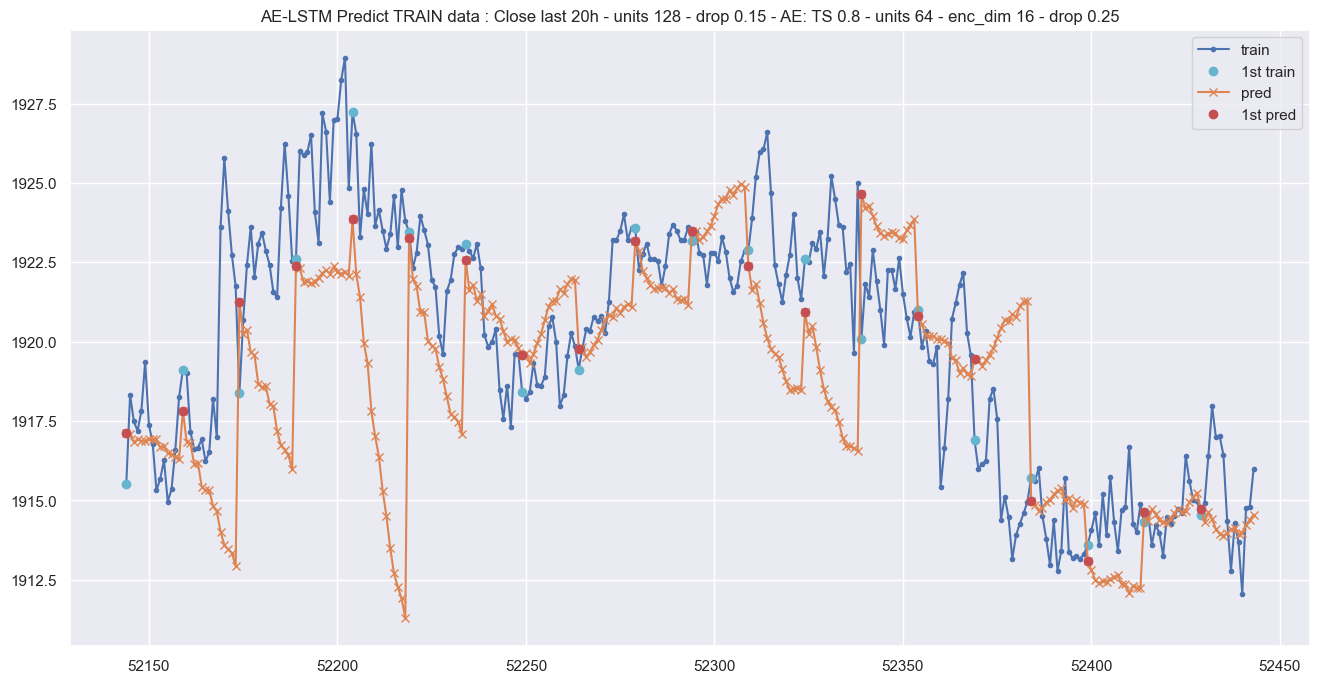

In [157]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TRAIN data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_train_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_train_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_train_raw_1 = y_train_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_train_pred_raw_1 = y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_train_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="train")
plt.plot(x_axis_1[-nb_pred:], y_train_raw_1[-nb_pred:], 'oc', label ='1st train')
plt.plot(x_axis[-nb_points:], y_train_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_train_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TRAIN - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

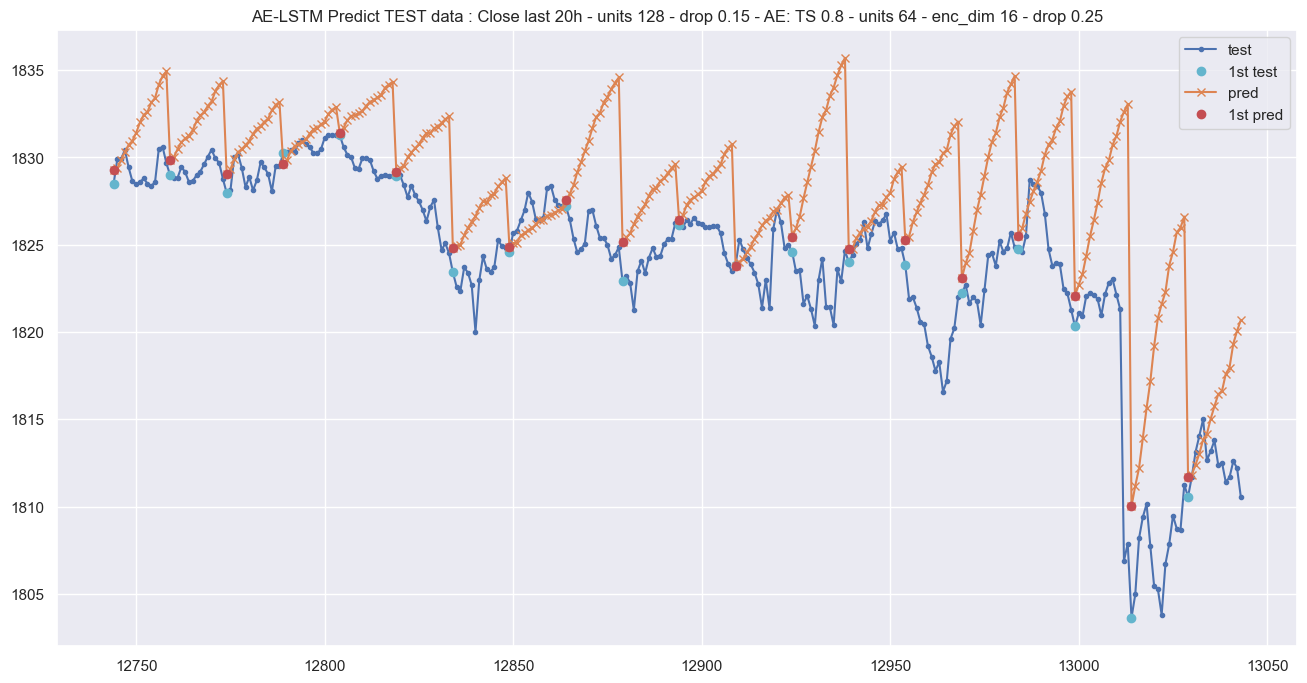

In [158]:
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
fig = plt.figure(figsize=(16, 8))
plt.title(f"AE-LSTM Predict TEST data : Close last 20h - units {n_units} - drop {dropout_rate} - AE: {name_plt}")
nb_pred = 20
nb_points = nb_pred*FUTURE_TARGET

x_axis = np.array(range(y_test_raw.shape[0]))
x_axis_1 =  np.flip(np.array(range(y_test_raw.shape[0]-FUTURE_TARGET,0, -FUTURE_TARGET)))
y_test_raw_1 = y_test_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
y_test_pred_raw_1 = y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[0::FUTURE_TARGET]
plt.plot(x_axis[-nb_points:], y_test_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], '.-', label="test")
plt.plot(x_axis_1[-nb_pred:], y_test_raw_1[-nb_pred:], 'oc', label ='1st test')
plt.plot(x_axis[-nb_points:], y_test_pred_raw[0::FUTURE_TARGET,:].ravel()[-nb_points:], 'x-', label="pred")
plt.plot(x_axis_1[-nb_pred:], y_test_pred_raw_1[-nb_pred:], 'or', label ='1st pred')
plt.legend(loc='upper right')
name_plt = naming_plot(n_unit_enc, encoding_dim, dropout_autoenc)
plt.savefig(
    os.path.join(path_data, f"output_AE pred TEST - units {n_units} - drop {dropout_rate} - AE {name_plt}.jpg")
)

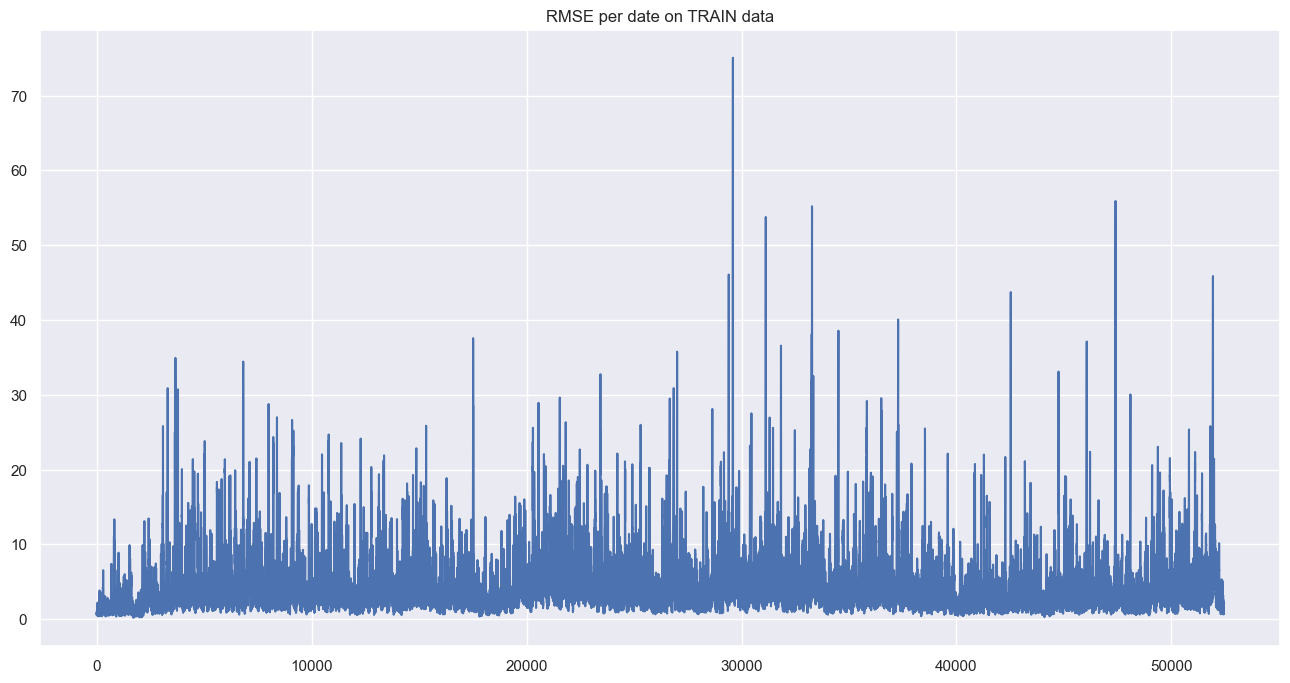

In [159]:
arr_mse_train = np.zeros((y_train_raw.shape[0]))
for i_date in range(y_train_raw.shape[0]):
    arr_mse_train[i_date] = mean_squared_error(
        y_train_raw[i_date], 
        y_train_pred_raw[i_date], 
        squared=False,
    )
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on TRAIN data")
plt.plot(arr_mse_train, label="mse")

Text(0.5, 1.0, 'Distrib. RMSE on TRAIN')

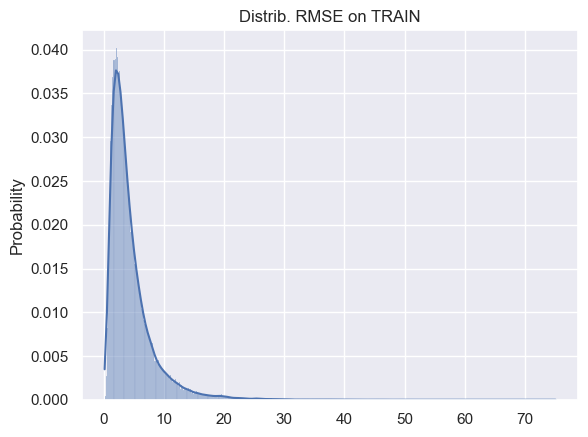

In [160]:
sns.histplot(x=arr_mse_train, stat="probability", kde=True)
fig = plt.gcf()
plt.title("Distrib. RMSE on TRAIN")

Text(0.5, 1.0, 'RMSE on TRAIN: mean= 4.53')

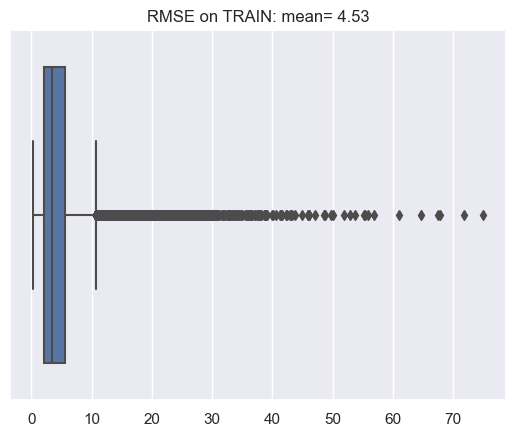

In [161]:

sns.boxplot(x=arr_mse_train)
fig = plt.gcf()
plt.title(f"RMSE on TRAIN: mean= {np.mean(arr_mse_train):.2f}")

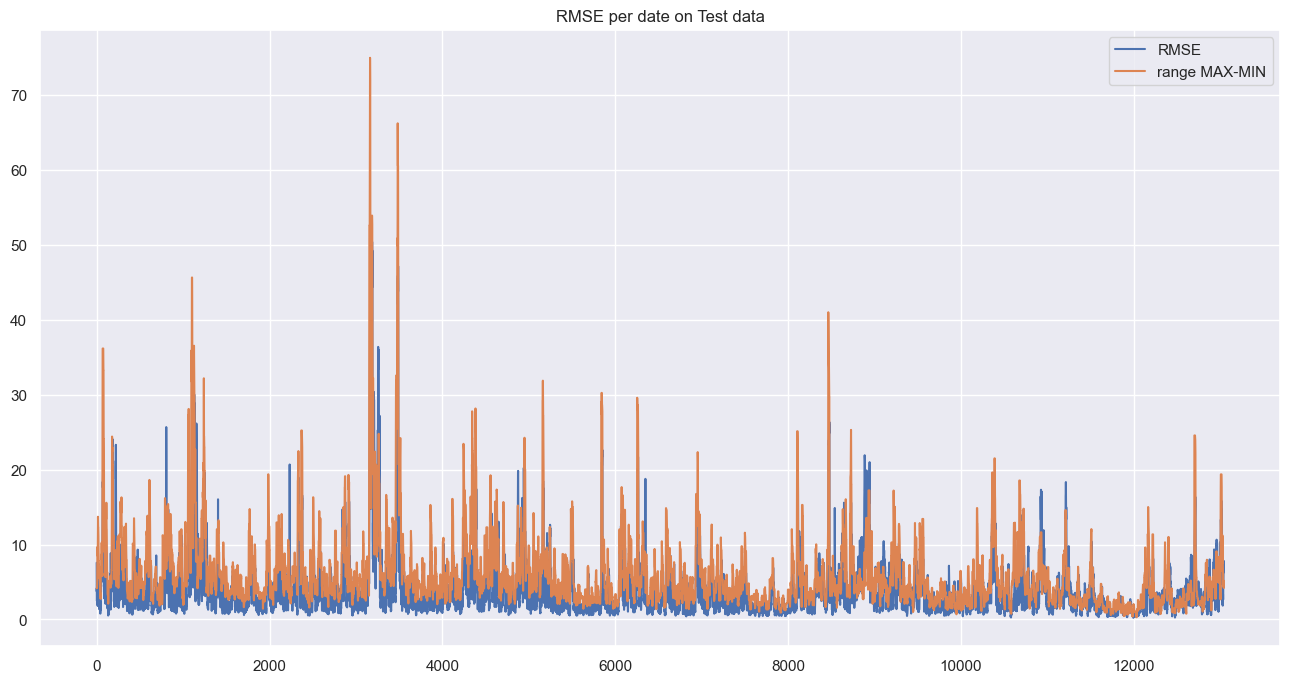

In [162]:
arr_mse = np.zeros((y_test_raw.shape[0]))
arr_range = np.zeros((y_test_raw.shape[0]))
for i_date in range(y_test_raw.shape[0]):
    arr_mse[i_date] = mean_squared_error(
        y_test_raw[i_date], 
        y_test_pred_raw[i_date],
        squared=False,
    )
    arr_range[i_date] = np.max(y_test_raw[i_date]) - np.min(y_test_raw[i_date])
fig = plt.figure(figsize=(16, 8))
plt.title("RMSE per date on Test data")
plt.plot(arr_mse, label="RMSE")
plt.plot(arr_range, label="range MAX-MIN")
plt.legend(loc='upper right')

In [163]:
np.mean(arr_range)

6.240021465808035

<AxesSubplot: ylabel='Probability'>

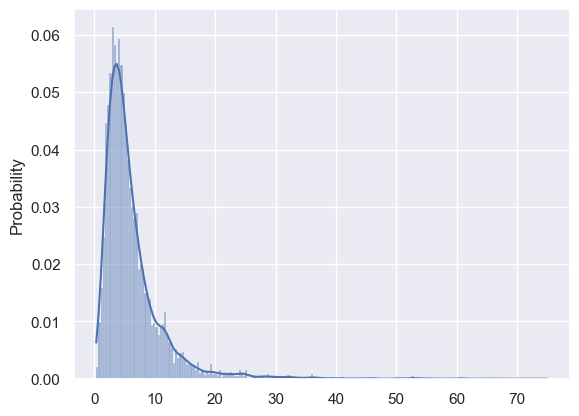

In [164]:
sns.histplot(x=arr_range,  stat="probability", kde=True)

In [165]:
np.mean(3*np.sqrt(np.var(y_test_raw, axis=1)))

5.550694347846673

<AxesSubplot: ylabel='Probability'>

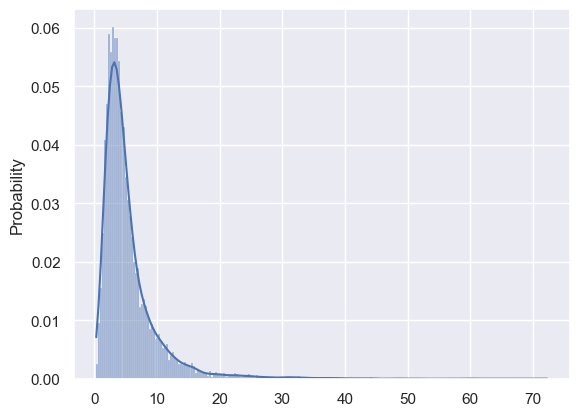

In [166]:
sns.histplot(x=3*np.sqrt(np.var(y_test_raw, axis=1)),  stat="probability", kde=True)

Text(0.5, 1.0, 'probability of RSME on each sequence')

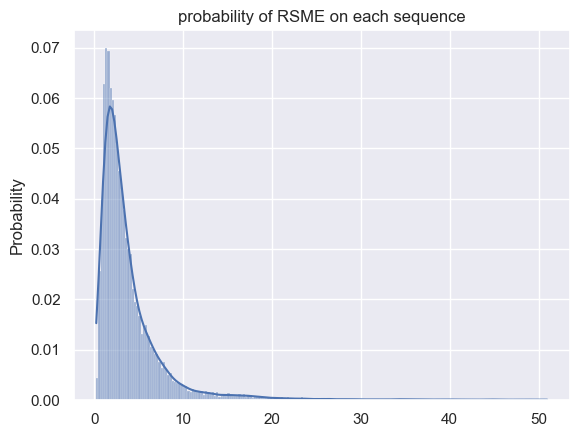

In [167]:
sns.histplot(x=arr_mse,  stat="probability", kde=True)
plt.title("probability of RSME on each sequence")

(0.0, 31.200107329040176)

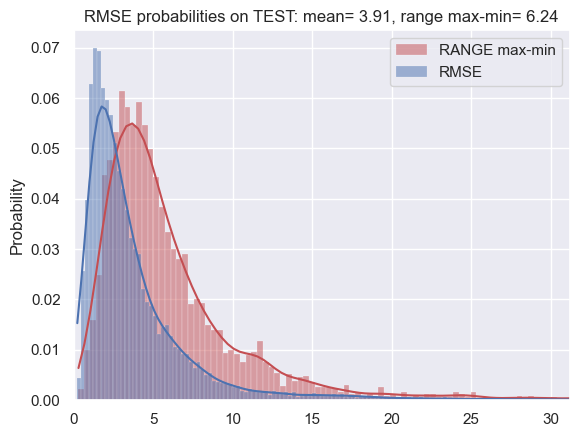

In [205]:
ax = sns.histplot(x=arr_range,  stat="probability", kde=True, label="RANGE max-min", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="RMSE", ax=ax)
plt.title(f"RMSE probabilities on TEST: mean= {np.mean(arr_mse):.2f}, range max-min= {np.mean(arr_range):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_range)*5])

(0.0, 19.568069612199047)

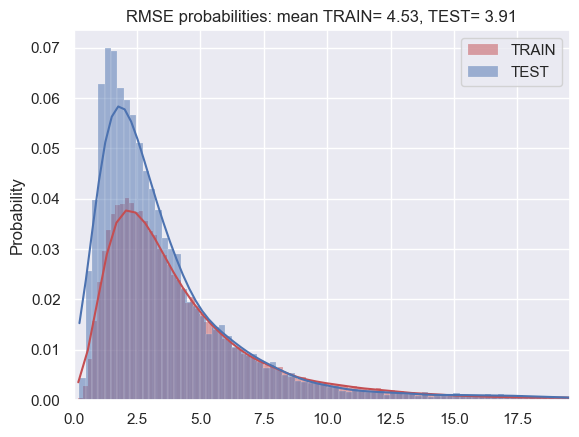

In [204]:
ax = sns.histplot(x=arr_mse_train,  stat="probability", kde=True, label="TRAIN", color="r")
sns.histplot(x=arr_mse,  stat="probability", kde=True, label="TEST", ax=ax)
plt.title(f"RMSE probabilities: mean TRAIN= {np.mean(arr_mse_train):.2f}, TEST= {np.mean(arr_mse):.2f}")
plt.legend(loc='upper right')
ax.set_xlim([0,np.mean(arr_mse)*5])

Text(0.5, 1.0, 'RMSE on TEST: mean= 3.91')

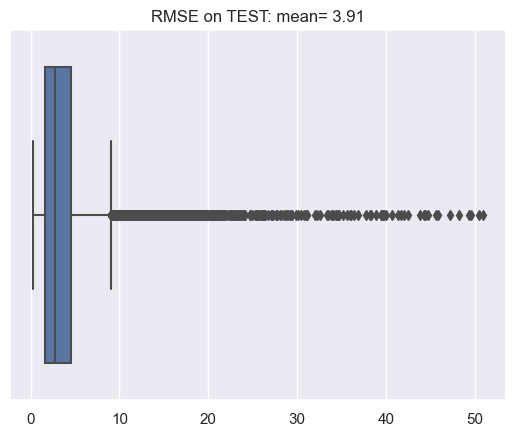

In [169]:
sns.boxplot(x=arr_mse)
fig = plt.gcf()
plt.title(f"RMSE on TEST: mean= {np.mean(arr_mse):.2f}")

In [170]:
print(y_test_raw[-3,:])
print(y_test_pred_raw[-3,:])

[1813.17 1813.79 1812.39 1812.52 1811.41 1811.68 1812.6  1812.21 1810.55
 1810.39 1809.99 1811.5  1810.64 1809.58 1810.2 ]
[1813.11356433 1813.36271138 1814.00254176 1814.68126761 1815.24006577
 1815.65365421 1816.2550213  1816.95665225 1817.45970025 1817.73304893
 1818.37784929 1818.67042961 1819.55119578 1820.12663256 1820.45076143]


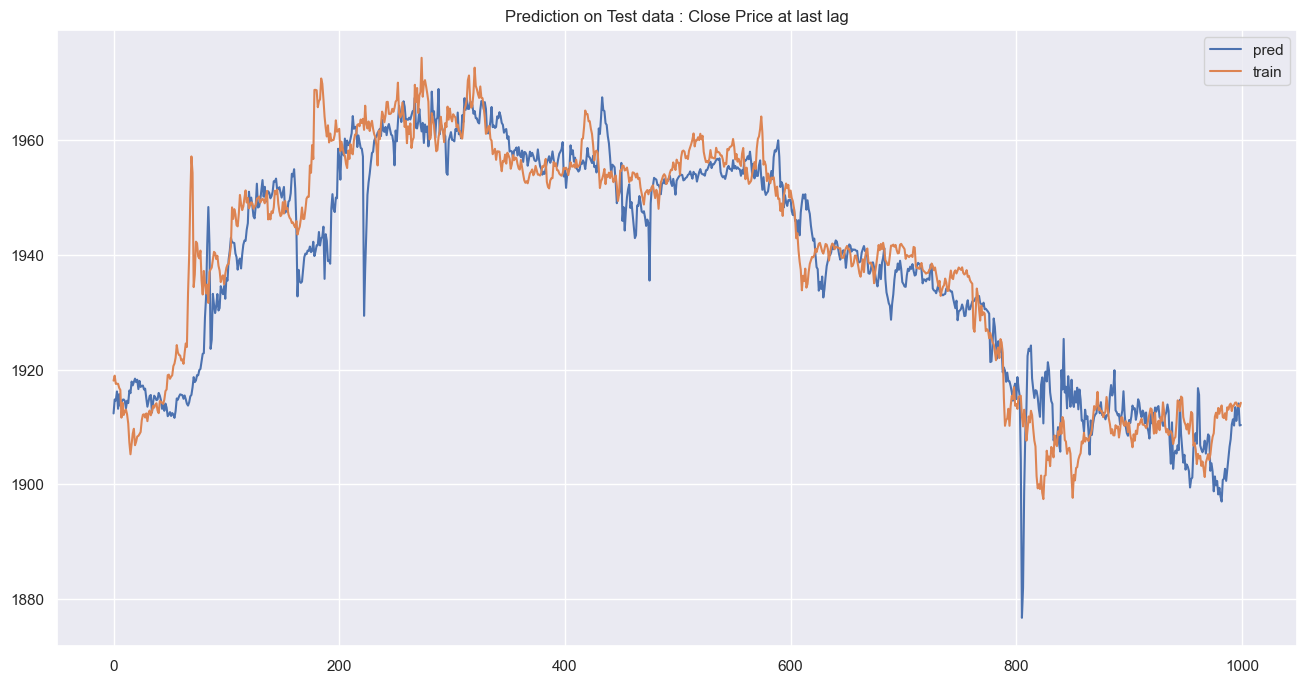

In [171]:
fig = plt.figure(figsize=(16, 8))
plt.title("Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

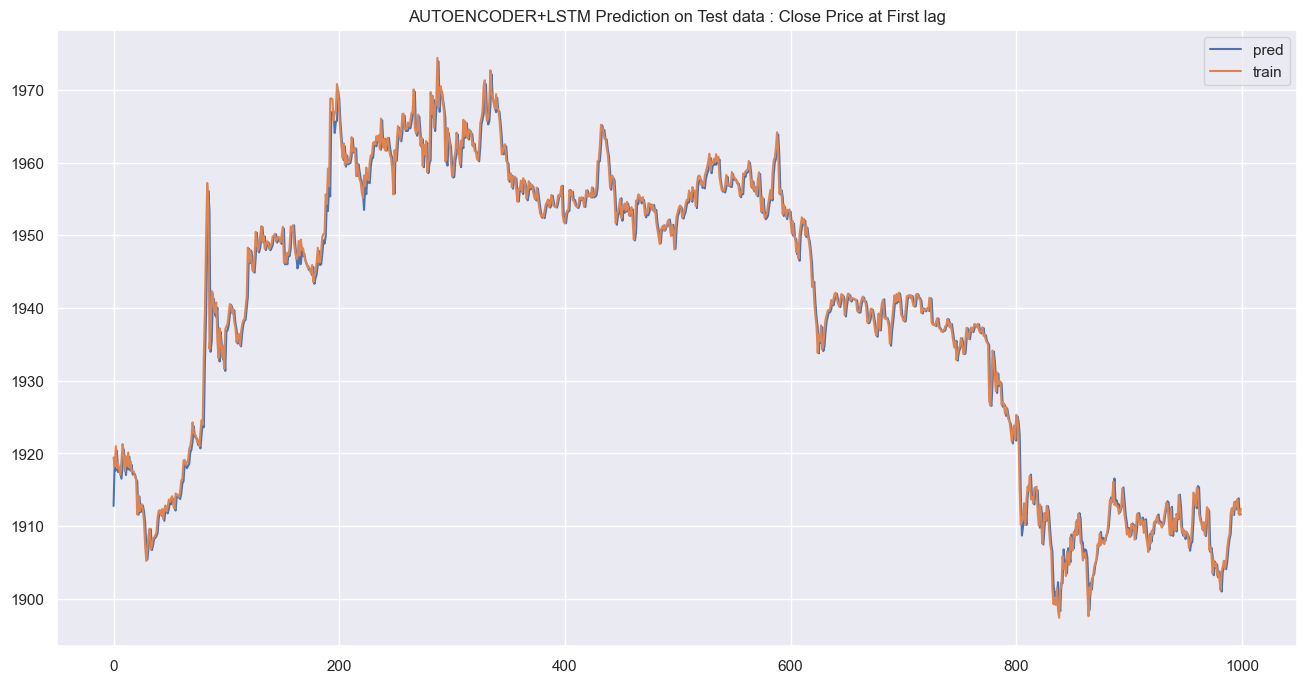

In [172]:
fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at First lag")
plt.plot(y_test_pred_raw[:1000, 0], label="pred")
plt.plot(y_test_raw[:1000, 0], label="train")
plt.legend(loc='upper right')

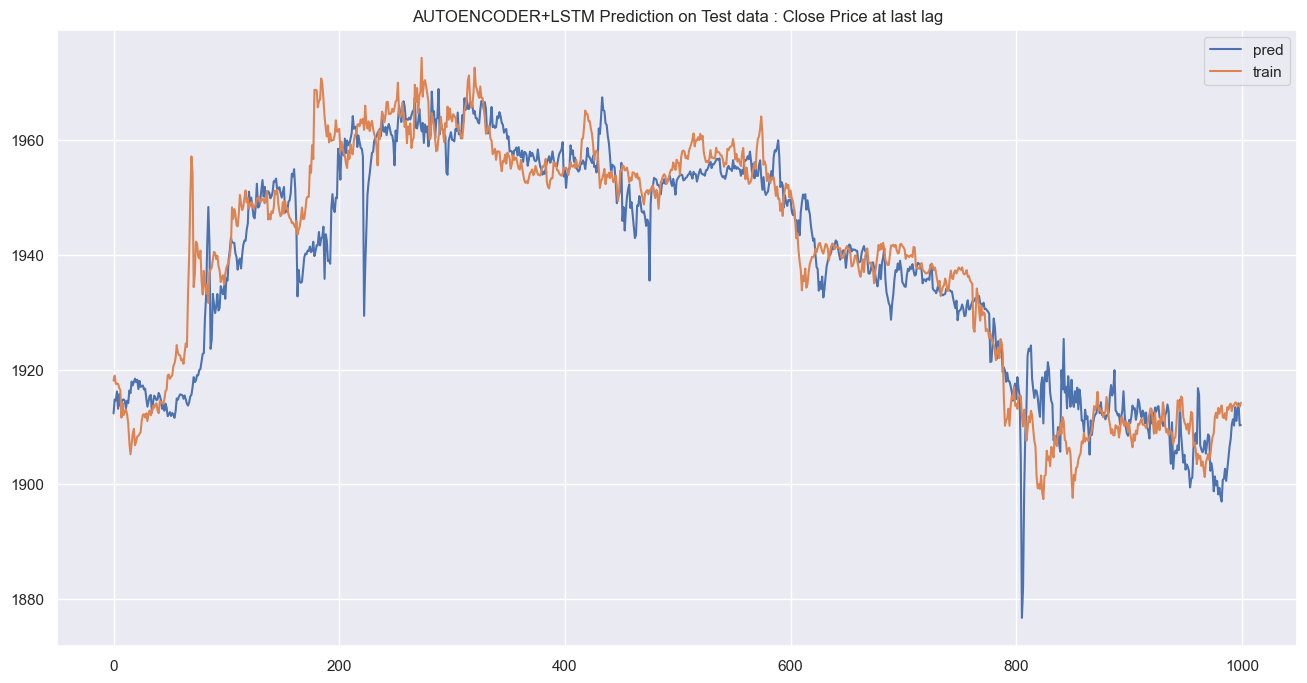

In [173]:

fig = plt.figure(figsize=(16, 8))
plt.title("AUTOENCODER+LSTM Prediction on Test data : Close Price at last lag")
plt.plot(y_test_pred_raw[:1000,-1], label="pred")
plt.plot(y_test_raw[:1000, -1], label="train")
plt.legend(loc='upper right')

## Compare

## Predict last prediction

In [174]:
X_test_sca.shape

(13044, 72, 102)

In [175]:
df_feat["Close_ETH"].iloc[-1]

1809.4

In [176]:
df_feat["Close_ETH"].iloc[-1]

1809.4

In [177]:
len(list_i_enc_select)

12

In [178]:
# reload MDLS
#multi_step_model = tf.keras.models.load_model(path_mdl_predict_autoenc_lstm)
#encoder_model = tf.keras.models.load_model(path_mdl_encoder)
print("[batch, lags, features]")
X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
X_last = X_last_raw.copy()
#list(np.array(list_col_select)[i_col_price_dep])/ df_feat["Close_ETH"].iloc[-1]
print("X_last[0,:,0]:")
print(X_last[0,:,0])
# Scale by ETH price
X_last[:,:,i_col_price_dep] = X_last[:,:,i_col_price_dep] / df_feat["Close_ETH"].iloc[-1]
assert X_last[0,-1,0] == 1, "Scaling by ETH price is not good!"
print("X_last[0,:,0] after divide by price:")
print(X_last[0,:,0])
print(X_last.shape)
# Standardize
X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
print("X_last_sca[0,:,0]:")
print(X_last_sca[0,:,0])
print(X_last_sca.shape)
# Encode
X_last_encoded = encoder_model.predict(X_last_sca)
print("X_last_encoded[0,:,0]:")
print(X_last_encoded[0,:,0])
print(X_last_encoded.shape)
# Standardize encoded
X_last_encoded_sca = scaler_enc.transform(
    X_last_encoded.reshape(
        -1, 
        X_last_encoded.shape[-1]
    )
).reshape(X_last_encoded.shape)
print("X_last_encoded_sca[0,:,0]:")
print(X_last_encoded_sca[0,:,0])
print(X_last_encoded_sca.shape)
print("X_last_sca[0,0,0:4]:")
print(X_last_sca[0,0,0:4])
print("X_last_encoded_sca[0,0,:]:")
print(X_last_encoded_sca[0,0,:])
# Concatenate (auto selected encoded features)
X_last_ = np.concatenate([
        X_last_sca[:,:,0:4], 
        X_last_encoded_sca[:, :, np.array(list_i_enc_select)]
    ],
    axis=-1,
)
print("X_last_[0,0,:]:")
print(X_last_[0,0,:])
print(X_last_.shape)
# Predict
y_last_pred = multi_step_model.predict(X_last_)
print("y_last_pred (scaled):")
print(y_last_pred)
print(y_last_pred.shape)
# Unscale
#scaler_y.transform(y_test.ravel().reshape(-1, 1)).reshape(y_test.shape)
y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.ravel().reshape(-1, 1)).reshape(y_last_pred.shape)
print("y_last_pred_unscaled:")
print(y_last_pred_unscaled)
print(y_last_pred_unscaled.shape)
# Multiply by price
y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
print("y_last_pred_raw:")
print(y_last_pred_raw)
print(y_last_pred_raw.shape)
nb_last_hour = 12
list_pred = list(y_last_pred_raw.squeeze()[-nb_last_hour:])
print("list_pred:")
print(list_pred)
print(len(list_pred))


[batch, lags, features]
X_last[0,:,0]:
[1824.79 1825.7  1824.86 1824.76 1824.58 1825.49 1828.71 1828.48 1828.37
 1827.99 1826.79 1824.74 1823.8  1823.93 1823.87 1822.44 1822.21 1821.29
 1820.32 1821.08 1820.9  1822.07 1822.21 1822.12 1821.9  1820.95 1822.18
 1822.83 1823.01 1822.14 1821.31 1806.9  1807.87 1803.63 1804.97 1808.18
 1809.39 1810.15 1807.73 1805.45 1805.27 1803.8  1806.71 1807.85 1809.48
 1808.74 1808.68 1811.25 1810.56 1811.71 1813.14 1814.06 1815.01 1812.66
 1813.17 1813.79 1812.39 1812.52 1811.41 1811.68 1812.6  1812.21 1810.55
 1810.39 1809.99 1811.5  1810.64 1809.58 1810.2  1808.61 1807.99 1809.4 ]
X_last[0,:,0] after divide by price:
[1.00850558 1.00900851 1.00854427 1.008489   1.00838952 1.00889245
 1.01067205 1.01054493 1.01048414 1.01027412 1.00961092 1.00847795
 1.00795844 1.00803029 1.00799713 1.00720681 1.00707969 1.00657124
 1.00603515 1.00645518 1.0063557  1.00700232 1.00707969 1.00702995
 1.00690837 1.00638333 1.00706311 1.00742235 1.00752183 1.00704101
 1.0

1/1 [==============================] - 0s 115ms/step
y_last_pred (scaled):
[[ 0.00338125 -0.00264718  0.0462109   0.06605897  0.07156572  0.10255488
   0.10323735  0.1020619   0.10136186  0.08134551  0.0798399   0.04494024
   0.09115425  0.09589604  0.10059875]]
(1, 15)
y_last_pred_unscaled:
[[1.0000966 1.00007   1.0002854 1.0003729 1.0003971 1.0005337 1.0005367
  1.0005316 1.0005285 1.0004402 1.0004336 1.0002798 1.0004835 1.0005044
  1.0005251]]
(1, 15)
y_last_pred_raw:
[[1809.5747 1809.5266 1809.9164 1810.0747 1810.1185 1810.3657 1810.3711
  1810.3618 1810.3562 1810.1967 1810.1846 1809.9062 1810.2749 1810.3126
  1810.3502]]
(1, 15)
list_pred:
[1810.0747, 1810.1185, 1810.3657, 1810.3711, 1810.3618, 1810.3562, 1810.1967, 1810.1846, 1809.9062, 1810.2749, 1810.3126, 1810.3502]
12


In [179]:
X_last_encoded_sca.shape

(1, 72, 16)

In [180]:
list_i_enc_select

[0, 1, 3, 4, 5, 6, 8, 9, 10, 12, 13, 15]

In [181]:
X_last_encoded_sca[:,:, np.array(list_i_enc_select)].shape

(1, 72, 12)

In [182]:
X_last_sca[:,:,0:4].shape

(1, 72, 4)

In [183]:
X_train_.shape

(52444, 72, 16)

In [184]:
df_feat

Time  Open_ETH  High_ETH  Low_ETH  Close_ETH  Volume_ETH  \
0      1672531200000   1196.13   1196.32  1195.65    1196.32    334.5592   
1      1672531500000   1196.31   1196.69  1194.90    1195.38    682.3876   
2      1672531800000   1195.38   1195.81  1194.55    1194.55    228.9387   
3      1672532100000   1194.55   1195.98  1194.31    1195.98    601.8903   
4      1672532400000   1195.98   1196.37  1195.97    1196.06    144.8048   
...              ...       ...       ...      ...        ...         ...   
65657  1692228300000   1810.64   1810.64  1809.20    1809.58    208.5162   
65658  1692228600000   1809.58   1811.00  1809.41    1810.20    503.7164   
65659  1692228900000   1810.20   1810.21  1806.02    1808.61   1317.2484   
65660  1692229200000   1808.60   1809.56  1807.16    1807.99    384.6119   
65661  1692229500000   1807.99   1809.40  1807.81    1809.40    195.7627   

                  date_ETH  ichi_cloud_a_ETH  ichi_cloud_b_ETH  \
0      2023-01-01 00:00:00       1753.872341       1753.333968   
1      2023-01-01 00:05:00       1753.872341       1753.333968   
2      2023-01-01 00:10:00       1753.872341       1753.333968   
3      2023-01-01 00:15:00       1753.872341       1753.333968   
4      2023-01-01 00:20:00       1753.872341       1753.333968   
...                    ...               ...               ...   
65657  2023-08-16 23:25:00       1807.440000       1813.695000   
65658  2023-08-16 23:30:00       1807.440000       1813.695000   
65659  2023-08-16 23:35:00       1808.677500       1813.695000   
65660  2023-08-16 23:40:00       1808.677500       1813.695000   
65661  2023-08-16 23:45:00       1808.677500       1813.695000   

       ichi_kijun_ETH  ...  Actual_num  Consensus_num  Previous_num  \
0            1194.710  ...         0.0            0.0           0.0   
1            1194.710  ...         0.0            0.0           0.0   
2            1194.710  ...         0.0            0.0           0.0   
3            1194.710  ...         0.0            0.0           0.0   
4            1194.710  ...         0.0            0.0           0.0   
...               ...  ...         ...            ...           ...   
65657        1809.495  ...         NaN            NaN           NaN   
65658        1810.720  ...         NaN            NaN           NaN   
65659        1810.605  ...         NaN            NaN           NaN   
65660        1810.605  ...         NaN            NaN           NaN   
65661        1810.605  ...         NaN            NaN           NaN   

       delta_event_pred  event_pred  delta_event_real  event_real  day_off  \
0                   0.0         0.0               0.0         0.0      0.0   
1                   0.0         0.0               0.0         0.0      0.0   
2                   0.0         0.0               0.0         0.0      0.0   
3                   0.0         0.0               0.0         0.0      0.0   
4                   0.0         0.0               0.0         0.0      0.0   
...                 ...         ...               ...         ...      ...   
65657               NaN         0.0               NaN         0.0      0.0   
65658               NaN         0.0               NaN         0.0      0.0   
65659               NaN         0.0               NaN         0.0      0.0   
65660               NaN         0.0               NaN         0.0      0.0   
65661               NaN         0.0               NaN         0.0      0.0   

                      date  train  
0      2023-01-02 05:00:00   True  
1      2023-01-02 05:00:00   True  
2      2023-01-02 05:00:00   True  
3      2023-01-02 05:00:00   True  
4      2023-01-02 05:00:00   True  
...                    ...    ...  
65657                  NaN  False  
65658                  NaN  False  
65659                  NaN  False  
65660                  NaN  False  
65661                  NaN  False  

[65662 rows x 136 columns]

In [185]:
mode_lstm_simple = False
if mode_lstm_simple:
    # TODO : finish pred
    X_last_raw = df_feat[list_col_select].iloc[-PAST_HISTORY:].values[np.newaxis,:]
    # divided price
    X_last = X_last_raw / df_feat["Close_ETH"].iloc[-1]
    # scaler
    X_last_sca = scaler.transform(X_last.reshape(-1,X_last.shape[-1])).reshape(X_last.shape)
    y_last_pred = multi_step_model_1.predict(X_last_sca)
    y_last_pred_unscaled = scaler_y.inverse_transform(y_last_pred.reshape(-1,y_last_pred.shape[-1])).reshape(y_last_pred.shape)
    y_last_pred_raw = y_last_pred_unscaled * df_feat["Close_ETH"].iloc[-1]
    print(y_last_pred_raw)
    nb_last_pred = 12
    list_pred = list(y_last_pred_raw.squeeze()[-nb_last_pred:])
    print(list_pred)

In [186]:
y_last_pred_unscaled

array([[1.0000966, 1.00007  , 1.0002854, 1.0003729, 1.0003971, 1.0005337,
        1.0005367, 1.0005316, 1.0005285, 1.0004402, 1.0004336, 1.0002798,
        1.0004835, 1.0005044, 1.0005251]], dtype=float32)

In [187]:
df_feat["Close_ETH"].iloc[-1]

1809.4

In [188]:
y_last_pred_raw

array([[1809.5747, 1809.5266, 1809.9164, 1810.0747, 1810.1185, 1810.3657,
        1810.3711, 1810.3618, 1810.3562, 1810.1967, 1810.1846, 1809.9062,
        1810.2749, 1810.3126, 1810.3502]], dtype=float32)

In [189]:
y_last_pred_raw.shape

(1, 15)

## Save last prediction

In [190]:
list_pred

[1810.0747,
 1810.1185,
 1810.3657,
 1810.3711,
 1810.3618,
 1810.3562,
 1810.1967,
 1810.1846,
 1809.9062,
 1810.2749,
 1810.3126,
 1810.3502]

In [191]:
save_list(list_pred, path_save_pred_vals)

In [192]:
list_pred_reload = load_list(path_save_pred_vals)
from numpy.testing import assert_almost_equal
assert_almost_equal(list_pred_reload,list_pred, decimal=3)
#"Reload prediction list not good!"

In [193]:
list_pred_reload

[1810.0747,
 1810.1185,
 1810.3657,
 1810.3711,
 1810.3618,
 1810.3562,
 1810.1967,
 1810.1846,
 1809.9062,
 1810.2749,
 1810.3126,
 1810.3502]